In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scipy
warnings.filterwarnings('ignore')

import sklearn.linear_model as lm
import sklearn.ensemble as en

import torch
import os
import sys
sys.path.append(os.path.abspath('../python'))

import train_arvae
import verify_causal_model

# DGP + Synthetic Control

$y_i(0) = \mu_i \lambda_t + \delta_t + \epsilon_{i,t}$ \
$y_i(1) = \alpha_{i,t} + y_i(0)$

In [10]:
def gen_data( n_donor=10, T=20, T0=12, noise=1 ):
    lmbda = np.random.normal(0,1,size=(T,1))
    delta = np.random.normal(0,1,size=(T,1))
    mu = np.random.normal(0,1,size=(1+n_donor,1))
    epsilon = np.random.normal(0,1,size=(T,1+n_donor))
    y0 = np.matmul(lmbda,mu.T) + np.matmul(delta,np.ones((1,1+n_donor))) + epsilon
    y1 = y0
    intervention = np.zeros((T,1+n_donor))
    intervention[T0:T,0] = 1
    y = intervention*y1 + (1-intervention)*y0
    return y,intervention,y1,y0

def synthetic_control( y, T0 ):
    y_target = y[:,0]
    y_donors = y[:,1:]
    ypre_target = y[:T0,0]
    ypre_donors = y[:T0,1:]
    m_lasso = lm.LassoCV().fit(ypre_donors,ypre_target)
    y_target_lasso = m_lasso.predict(y_donors)
    effect = y_target - y_target_lasso
    return effect, y_target, y_target_lasso

In [13]:
n_donor=10 
T=20
T0=12
noise=1 
y,intervention,y1,y0 = gen_data( n_donor=n_donor, T=T, T0=T0, noise=noise )

In [17]:
effect, y_target, y_target_lasso = synthetic_control( y, T0 )

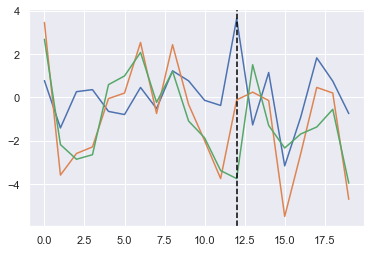

In [18]:
plt.plot(effect)
plt.plot(y_target)
plt.plot(y_target_lasso)
plt.axvline(T0,c='black',ls='--')

# Credence

In [21]:
B = 100
for i in range(B):
    y,intervention,y1,y0 = gen_data( n_donor=n_donor, T=T, T0=T0, noise=noise )
    y_donors = ( y[:,1:] - np.mean(y[:,1:]) ) / np.std(y[:,1:])
    if i==0:
        data = y_donors.reshape(T,1,n_donor)
    else:
        data = np.concatenate((data,y_donors.reshape(T,1,n_donor)),axis=1)

data_2d = train_arvae.convert_to_2d(data)

In [23]:
print(f"Shape: {data_2d.shape}")
print(f"\nMean of raw data: {np.mean(data_2d):.3f}")
print(f"Std. dev of raw data: {np.std(data_2d):.3f}")

Shape: (100, 200)

Mean of raw data: 0.000
Std. dev of raw data: 1.000


In [27]:
hyper_params = {}
hyper_params['epochs'] = 5000
hyper_params['latent_dim'] = 2 #Z
hyper_params['hidden_dims'] = [16,8]
hyper_params['kld_weight'] = 5e-08
vae_model, runner = train_arvae.train(data_2d, hyper_params, output_checkpoint_path='ar_vae_coverage_2d.ckpt')

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name          | Type       | Params
---------------------------------------------
0 | encoder       | Sequential | 3.4 K 
1 | fc_mu         | Linear     | 18    
2 | fc_var        | Linear     | 18    
3 | decoder_input | Linear     | 24    
4 | decoder       | Sequential | 144   
5 | final_layer   | Sequential | 3.4 K 
---------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)


Loss Before Training
{'loss': tensor(1.0355, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(1.0355, grad_fn=<MseLossBackward>), 'KLD_Loss': tensor(0.0338, grad_fn=<MeanBackward0>), 'KLD_weight': 5e-08}


Validation sanity check: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0346), 'kld_loss': tensor(0.0338), 'reconstruction_loss': tensor(1.0346)}


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0290), 'kld_loss': tensor(0.0329), 'reconstruction_loss': tensor(1.0290)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0248), 'kld_loss': tensor(0.0323), 'reconstruction_loss': tensor(1.0248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0186), 'kld_loss': tensor(0.0315), 'reconstruction_loss': tensor(1.0186)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0158), 'kld_loss': tensor(0.0311), 'reconstruction_loss': tensor(1.0158)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0130), 'kld_loss': tensor(0.0309), 'reconstruction_loss': tensor(1.0130)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0095), 'kld_loss': tensor(0.0317), 'reconstruction_loss': tensor(1.0095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0084), 'kld_loss': tensor(0.0346), 'reconstruction_loss': tensor(1.0084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0053), 'kld_loss': tensor(0.0408), 'reconstruction_loss': tensor(1.0053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0041), 'kld_loss': tensor(0.0519), 'reconstruction_loss': tensor(1.0041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0007), 'kld_loss': tensor(0.0694), 'reconstruction_loss': tensor(1.0007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0003), 'kld_loss': tensor(0.0952), 'reconstruction_loss': tensor(1.0003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9992), 'kld_loss': tensor(0.1330), 'reconstruction_loss': tensor(0.9992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9965), 'kld_loss': tensor(0.1877), 'reconstruction_loss': tensor(0.9965)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9963), 'kld_loss': tensor(0.2636), 'reconstruction_loss': tensor(0.9963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9930), 'kld_loss': tensor(0.3680), 'reconstruction_loss': tensor(0.9930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9930), 'kld_loss': tensor(0.5075), 'reconstruction_loss': tensor(0.9930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9913), 'kld_loss': tensor(0.6882), 'reconstruction_loss': tensor(0.9913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9901), 'kld_loss': tensor(0.9262), 'reconstruction_loss': tensor(0.9901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9888), 'kld_loss': tensor(1.1655), 'reconstruction_loss': tensor(0.9888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(1.4097), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9851), 'kld_loss': tensor(1.6481), 'reconstruction_loss': tensor(0.9851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9843), 'kld_loss': tensor(1.8962), 'reconstruction_loss': tensor(0.9843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9831), 'kld_loss': tensor(2.1946), 'reconstruction_loss': tensor(0.9831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9804), 'kld_loss': tensor(2.5534), 'reconstruction_loss': tensor(0.9804)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9789), 'kld_loss': tensor(2.9869), 'reconstruction_loss': tensor(0.9789)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9775), 'kld_loss': tensor(3.5334), 'reconstruction_loss': tensor(0.9775)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9751), 'kld_loss': tensor(4.2054), 'reconstruction_loss': tensor(0.9751)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9746), 'kld_loss': tensor(4.9281), 'reconstruction_loss': tensor(0.9746)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9730), 'kld_loss': tensor(5.6787), 'reconstruction_loss': tensor(0.9730)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9710), 'kld_loss': tensor(6.4853), 'reconstruction_loss': tensor(0.9710)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9693), 'kld_loss': tensor(7.3946), 'reconstruction_loss': tensor(0.9693)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(8.3249), 'reconstruction_loss': tensor(0.9666)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(9.3040), 'reconstruction_loss': tensor(0.9653)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(10.3107), 'reconstruction_loss': tensor(0.9630)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(11.3732), 'reconstruction_loss': tensor(0.9616)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(12.5776), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(13.8248), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(15.0780), 'reconstruction_loss': tensor(0.9546)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(16.4826), 'reconstruction_loss': tensor(0.9535)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(18.0466), 'reconstruction_loss': tensor(0.9516)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9493), 'kld_loss': tensor(19.8171), 'reconstruction_loss': tensor(0.9493)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9475), 'kld_loss': tensor(21.7146), 'reconstruction_loss': tensor(0.9475)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9453), 'kld_loss': tensor(23.7200), 'reconstruction_loss': tensor(0.9453)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9430), 'kld_loss': tensor(25.6629), 'reconstruction_loss': tensor(0.9430)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9407), 'kld_loss': tensor(27.4652), 'reconstruction_loss': tensor(0.9407)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9390), 'kld_loss': tensor(29.1986), 'reconstruction_loss': tensor(0.9390)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9370), 'kld_loss': tensor(31.2800), 'reconstruction_loss': tensor(0.9370)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9359), 'kld_loss': tensor(33.7453), 'reconstruction_loss': tensor(0.9359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9338), 'kld_loss': tensor(36.1387), 'reconstruction_loss': tensor(0.9338)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9326), 'kld_loss': tensor(38.1740), 'reconstruction_loss': tensor(0.9326)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9309), 'kld_loss': tensor(40.0266), 'reconstruction_loss': tensor(0.9309)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9291), 'kld_loss': tensor(42.1212), 'reconstruction_loss': tensor(0.9291)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9276), 'kld_loss': tensor(44.3170), 'reconstruction_loss': tensor(0.9276)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9264), 'kld_loss': tensor(46.2703), 'reconstruction_loss': tensor(0.9264)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9247), 'kld_loss': tensor(47.9431), 'reconstruction_loss': tensor(0.9247)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9242), 'kld_loss': tensor(49.8680), 'reconstruction_loss': tensor(0.9242)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9223), 'kld_loss': tensor(52.2737), 'reconstruction_loss': tensor(0.9223)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9213), 'kld_loss': tensor(54.4380), 'reconstruction_loss': tensor(0.9213)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9201), 'kld_loss': tensor(55.7804), 'reconstruction_loss': tensor(0.9200)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9191), 'kld_loss': tensor(57.3536), 'reconstruction_loss': tensor(0.9191)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9181), 'kld_loss': tensor(59.3625), 'reconstruction_loss': tensor(0.9181)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9175), 'kld_loss': tensor(61.0344), 'reconstruction_loss': tensor(0.9175)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9165), 'kld_loss': tensor(62.6771), 'reconstruction_loss': tensor(0.9165)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9153), 'kld_loss': tensor(64.2575), 'reconstruction_loss': tensor(0.9153)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9145), 'kld_loss': tensor(65.5680), 'reconstruction_loss': tensor(0.9145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9136), 'kld_loss': tensor(67.7461), 'reconstruction_loss': tensor(0.9136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9130), 'kld_loss': tensor(69.0885), 'reconstruction_loss': tensor(0.9130)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9117), 'kld_loss': tensor(70.1357), 'reconstruction_loss': tensor(0.9117)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9106), 'kld_loss': tensor(71.5405), 'reconstruction_loss': tensor(0.9106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9101), 'kld_loss': tensor(72.6296), 'reconstruction_loss': tensor(0.9101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9091), 'kld_loss': tensor(74.0518), 'reconstruction_loss': tensor(0.9091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9079), 'kld_loss': tensor(75.5110), 'reconstruction_loss': tensor(0.9079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9075), 'kld_loss': tensor(76.4801), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9065), 'kld_loss': tensor(78.1159), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9059), 'kld_loss': tensor(78.3438), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9047), 'kld_loss': tensor(79.7813), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9035), 'kld_loss': tensor(81.5788), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9033), 'kld_loss': tensor(81.6342), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9022), 'kld_loss': tensor(82.5262), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9008), 'kld_loss': tensor(83.5187), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9008), 'kld_loss': tensor(83.8383), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8996), 'kld_loss': tensor(85.0531), 'reconstruction_loss': tensor(0.8996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8993), 'kld_loss': tensor(86.5484), 'reconstruction_loss': tensor(0.8993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8975), 'kld_loss': tensor(86.3826), 'reconstruction_loss': tensor(0.8975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8967), 'kld_loss': tensor(87.5517), 'reconstruction_loss': tensor(0.8967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8952), 'kld_loss': tensor(89.2466), 'reconstruction_loss': tensor(0.8952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8943), 'kld_loss': tensor(89.2999), 'reconstruction_loss': tensor(0.8942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8935), 'kld_loss': tensor(89.5334), 'reconstruction_loss': tensor(0.8935)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8921), 'kld_loss': tensor(91.0483), 'reconstruction_loss': tensor(0.8921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8914), 'kld_loss': tensor(92.2773), 'reconstruction_loss': tensor(0.8914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8903), 'kld_loss': tensor(92.2904), 'reconstruction_loss': tensor(0.8903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8885), 'kld_loss': tensor(93.0148), 'reconstruction_loss': tensor(0.8885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8876), 'kld_loss': tensor(94.9726), 'reconstruction_loss': tensor(0.8876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8861), 'kld_loss': tensor(94.6740), 'reconstruction_loss': tensor(0.8861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8852), 'kld_loss': tensor(95.2851), 'reconstruction_loss': tensor(0.8852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8843), 'kld_loss': tensor(97.9093), 'reconstruction_loss': tensor(0.8843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8828), 'kld_loss': tensor(98.7577), 'reconstruction_loss': tensor(0.8828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8815), 'kld_loss': tensor(99.1186), 'reconstruction_loss': tensor(0.8815)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8803), 'kld_loss': tensor(100.7834), 'reconstruction_loss': tensor(0.8803)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8794), 'kld_loss': tensor(102.4338), 'reconstruction_loss': tensor(0.8794)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8775), 'kld_loss': tensor(103.3520), 'reconstruction_loss': tensor(0.8775)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8769), 'kld_loss': tensor(104.5795), 'reconstruction_loss': tensor(0.8769)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8758), 'kld_loss': tensor(106.1259), 'reconstruction_loss': tensor(0.8758)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8743), 'kld_loss': tensor(107.2619), 'reconstruction_loss': tensor(0.8743)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8731), 'kld_loss': tensor(108.5040), 'reconstruction_loss': tensor(0.8731)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8720), 'kld_loss': tensor(109.8705), 'reconstruction_loss': tensor(0.8720)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8708), 'kld_loss': tensor(112.0989), 'reconstruction_loss': tensor(0.8708)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8699), 'kld_loss': tensor(113.6360), 'reconstruction_loss': tensor(0.8699)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8688), 'kld_loss': tensor(113.8386), 'reconstruction_loss': tensor(0.8688)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8674), 'kld_loss': tensor(115.9157), 'reconstruction_loss': tensor(0.8674)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8660), 'kld_loss': tensor(117.7899), 'reconstruction_loss': tensor(0.8660)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8647), 'kld_loss': tensor(118.2521), 'reconstruction_loss': tensor(0.8647)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8638), 'kld_loss': tensor(120.5892), 'reconstruction_loss': tensor(0.8638)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8628), 'kld_loss': tensor(122.5255), 'reconstruction_loss': tensor(0.8628)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8620), 'kld_loss': tensor(122.8042), 'reconstruction_loss': tensor(0.8620)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8606), 'kld_loss': tensor(124.1509), 'reconstruction_loss': tensor(0.8606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8595), 'kld_loss': tensor(126.7570), 'reconstruction_loss': tensor(0.8595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8587), 'kld_loss': tensor(127.7421), 'reconstruction_loss': tensor(0.8587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8578), 'kld_loss': tensor(130.0183), 'reconstruction_loss': tensor(0.8578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8571), 'kld_loss': tensor(131.3042), 'reconstruction_loss': tensor(0.8571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8566), 'kld_loss': tensor(133.8734), 'reconstruction_loss': tensor(0.8566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8547), 'kld_loss': tensor(133.8463), 'reconstruction_loss': tensor(0.8547)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8536), 'kld_loss': tensor(135.5311), 'reconstruction_loss': tensor(0.8536)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8533), 'kld_loss': tensor(138.9202), 'reconstruction_loss': tensor(0.8533)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8515), 'kld_loss': tensor(138.2050), 'reconstruction_loss': tensor(0.8515)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8506), 'kld_loss': tensor(139.0443), 'reconstruction_loss': tensor(0.8506)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8493), 'kld_loss': tensor(141.1720), 'reconstruction_loss': tensor(0.8493)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8485), 'kld_loss': tensor(141.9333), 'reconstruction_loss': tensor(0.8485)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8482), 'kld_loss': tensor(143.5482), 'reconstruction_loss': tensor(0.8482)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8465), 'kld_loss': tensor(144.5813), 'reconstruction_loss': tensor(0.8465)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8450), 'kld_loss': tensor(147.0005), 'reconstruction_loss': tensor(0.8450)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8444), 'kld_loss': tensor(148.0411), 'reconstruction_loss': tensor(0.8444)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8437), 'kld_loss': tensor(149.4207), 'reconstruction_loss': tensor(0.8437)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8429), 'kld_loss': tensor(151.6817), 'reconstruction_loss': tensor(0.8429)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8415), 'kld_loss': tensor(151.1659), 'reconstruction_loss': tensor(0.8415)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8410), 'kld_loss': tensor(153.4661), 'reconstruction_loss': tensor(0.8410)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8396), 'kld_loss': tensor(155.0131), 'reconstruction_loss': tensor(0.8396)}


Validating: 0it [00:01, ?it/s]

{'avg_val_loss': tensor(0.8389), 'kld_loss': tensor(155.8791), 'reconstruction_loss': tensor(0.8389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8385), 'kld_loss': tensor(157.4135), 'reconstruction_loss': tensor(0.8385)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8371), 'kld_loss': tensor(158.5683), 'reconstruction_loss': tensor(0.8371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8365), 'kld_loss': tensor(160.5281), 'reconstruction_loss': tensor(0.8365)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8349), 'kld_loss': tensor(161.7325), 'reconstruction_loss': tensor(0.8349)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8337), 'kld_loss': tensor(164.0234), 'reconstruction_loss': tensor(0.8337)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8330), 'kld_loss': tensor(165.0848), 'reconstruction_loss': tensor(0.8330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8320), 'kld_loss': tensor(166.0096), 'reconstruction_loss': tensor(0.8320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8312), 'kld_loss': tensor(168.1900), 'reconstruction_loss': tensor(0.8312)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8302), 'kld_loss': tensor(168.6668), 'reconstruction_loss': tensor(0.8302)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8293), 'kld_loss': tensor(171.1120), 'reconstruction_loss': tensor(0.8293)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8280), 'kld_loss': tensor(172.4052), 'reconstruction_loss': tensor(0.8280)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8270), 'kld_loss': tensor(174.3431), 'reconstruction_loss': tensor(0.8270)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8258), 'kld_loss': tensor(175.3848), 'reconstruction_loss': tensor(0.8258)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8248), 'kld_loss': tensor(179.1077), 'reconstruction_loss': tensor(0.8248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8235), 'kld_loss': tensor(180.4580), 'reconstruction_loss': tensor(0.8235)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8226), 'kld_loss': tensor(180.4195), 'reconstruction_loss': tensor(0.8226)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8224), 'kld_loss': tensor(183.8443), 'reconstruction_loss': tensor(0.8224)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8208), 'kld_loss': tensor(184.8552), 'reconstruction_loss': tensor(0.8208)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8201), 'kld_loss': tensor(187.0978), 'reconstruction_loss': tensor(0.8201)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8194), 'kld_loss': tensor(187.8366), 'reconstruction_loss': tensor(0.8194)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8179), 'kld_loss': tensor(191.1980), 'reconstruction_loss': tensor(0.8179)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8167), 'kld_loss': tensor(190.7999), 'reconstruction_loss': tensor(0.8167)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8157), 'kld_loss': tensor(192.6413), 'reconstruction_loss': tensor(0.8157)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8148), 'kld_loss': tensor(194.8973), 'reconstruction_loss': tensor(0.8148)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8132), 'kld_loss': tensor(193.7980), 'reconstruction_loss': tensor(0.8132)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8123), 'kld_loss': tensor(195.8462), 'reconstruction_loss': tensor(0.8123)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8112), 'kld_loss': tensor(197.9298), 'reconstruction_loss': tensor(0.8112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8104), 'kld_loss': tensor(198.4473), 'reconstruction_loss': tensor(0.8104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8097), 'kld_loss': tensor(200.5884), 'reconstruction_loss': tensor(0.8097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8087), 'kld_loss': tensor(203.2030), 'reconstruction_loss': tensor(0.8087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8079), 'kld_loss': tensor(205.5771), 'reconstruction_loss': tensor(0.8079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8065), 'kld_loss': tensor(206.5520), 'reconstruction_loss': tensor(0.8065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8059), 'kld_loss': tensor(208.3719), 'reconstruction_loss': tensor(0.8059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8055), 'kld_loss': tensor(210.6203), 'reconstruction_loss': tensor(0.8055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8044), 'kld_loss': tensor(212.0542), 'reconstruction_loss': tensor(0.8044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8036), 'kld_loss': tensor(214.0677), 'reconstruction_loss': tensor(0.8036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8029), 'kld_loss': tensor(215.7680), 'reconstruction_loss': tensor(0.8029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8024), 'kld_loss': tensor(218.0959), 'reconstruction_loss': tensor(0.8024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8022), 'kld_loss': tensor(218.1219), 'reconstruction_loss': tensor(0.8022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8014), 'kld_loss': tensor(222.1225), 'reconstruction_loss': tensor(0.8014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.8008), 'kld_loss': tensor(222.2333), 'reconstruction_loss': tensor(0.8008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7992), 'kld_loss': tensor(222.8455), 'reconstruction_loss': tensor(0.7992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7980), 'kld_loss': tensor(225.9434), 'reconstruction_loss': tensor(0.7980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7978), 'kld_loss': tensor(227.8993), 'reconstruction_loss': tensor(0.7978)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7976), 'kld_loss': tensor(227.2964), 'reconstruction_loss': tensor(0.7976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7970), 'kld_loss': tensor(228.2967), 'reconstruction_loss': tensor(0.7970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7958), 'kld_loss': tensor(231.4841), 'reconstruction_loss': tensor(0.7957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7948), 'kld_loss': tensor(230.3594), 'reconstruction_loss': tensor(0.7948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7945), 'kld_loss': tensor(231.2171), 'reconstruction_loss': tensor(0.7945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7940), 'kld_loss': tensor(235.4397), 'reconstruction_loss': tensor(0.7940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7928), 'kld_loss': tensor(234.1618), 'reconstruction_loss': tensor(0.7928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7925), 'kld_loss': tensor(235.3349), 'reconstruction_loss': tensor(0.7925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7916), 'kld_loss': tensor(239.2144), 'reconstruction_loss': tensor(0.7916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7909), 'kld_loss': tensor(239.7997), 'reconstruction_loss': tensor(0.7909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7905), 'kld_loss': tensor(239.4097), 'reconstruction_loss': tensor(0.7905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7898), 'kld_loss': tensor(242.2887), 'reconstruction_loss': tensor(0.7898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7893), 'kld_loss': tensor(244.9640), 'reconstruction_loss': tensor(0.7892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7885), 'kld_loss': tensor(244.3179), 'reconstruction_loss': tensor(0.7884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7880), 'kld_loss': tensor(245.3677), 'reconstruction_loss': tensor(0.7880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7875), 'kld_loss': tensor(249.5445), 'reconstruction_loss': tensor(0.7875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7867), 'kld_loss': tensor(250.6906), 'reconstruction_loss': tensor(0.7867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7864), 'kld_loss': tensor(251.2088), 'reconstruction_loss': tensor(0.7864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7857), 'kld_loss': tensor(253.1817), 'reconstruction_loss': tensor(0.7857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7852), 'kld_loss': tensor(256.1359), 'reconstruction_loss': tensor(0.7852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7848), 'kld_loss': tensor(256.4833), 'reconstruction_loss': tensor(0.7848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7841), 'kld_loss': tensor(258.4498), 'reconstruction_loss': tensor(0.7841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7836), 'kld_loss': tensor(260.4622), 'reconstruction_loss': tensor(0.7835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7839), 'kld_loss': tensor(263.5252), 'reconstruction_loss': tensor(0.7839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7831), 'kld_loss': tensor(262.7453), 'reconstruction_loss': tensor(0.7831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7828), 'kld_loss': tensor(266.7229), 'reconstruction_loss': tensor(0.7828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7814), 'kld_loss': tensor(266.6737), 'reconstruction_loss': tensor(0.7814)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7806), 'kld_loss': tensor(267.9082), 'reconstruction_loss': tensor(0.7806)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7794), 'kld_loss': tensor(269.3740), 'reconstruction_loss': tensor(0.7794)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7793), 'kld_loss': tensor(269.9637), 'reconstruction_loss': tensor(0.7793)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7792), 'kld_loss': tensor(271.7794), 'reconstruction_loss': tensor(0.7792)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7785), 'kld_loss': tensor(272.8030), 'reconstruction_loss': tensor(0.7784)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7777), 'kld_loss': tensor(276.9040), 'reconstruction_loss': tensor(0.7777)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7771), 'kld_loss': tensor(277.2161), 'reconstruction_loss': tensor(0.7771)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7766), 'kld_loss': tensor(277.4027), 'reconstruction_loss': tensor(0.7766)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7759), 'kld_loss': tensor(280.3587), 'reconstruction_loss': tensor(0.7759)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7761), 'kld_loss': tensor(281.7319), 'reconstruction_loss': tensor(0.7760)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7749), 'kld_loss': tensor(282.5832), 'reconstruction_loss': tensor(0.7749)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7742), 'kld_loss': tensor(283.5847), 'reconstruction_loss': tensor(0.7742)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7738), 'kld_loss': tensor(286.9943), 'reconstruction_loss': tensor(0.7738)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7732), 'kld_loss': tensor(288.7220), 'reconstruction_loss': tensor(0.7732)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7729), 'kld_loss': tensor(289.2086), 'reconstruction_loss': tensor(0.7729)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7720), 'kld_loss': tensor(292.1538), 'reconstruction_loss': tensor(0.7720)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7714), 'kld_loss': tensor(292.8087), 'reconstruction_loss': tensor(0.7714)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7710), 'kld_loss': tensor(294.4174), 'reconstruction_loss': tensor(0.7710)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7704), 'kld_loss': tensor(297.1772), 'reconstruction_loss': tensor(0.7704)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7700), 'kld_loss': tensor(298.4109), 'reconstruction_loss': tensor(0.7700)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7699), 'kld_loss': tensor(300.0828), 'reconstruction_loss': tensor(0.7699)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7696), 'kld_loss': tensor(300.9560), 'reconstruction_loss': tensor(0.7695)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7693), 'kld_loss': tensor(304.6539), 'reconstruction_loss': tensor(0.7693)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7689), 'kld_loss': tensor(303.6503), 'reconstruction_loss': tensor(0.7689)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7680), 'kld_loss': tensor(307.2797), 'reconstruction_loss': tensor(0.7680)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7668), 'kld_loss': tensor(306.5250), 'reconstruction_loss': tensor(0.7668)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7666), 'kld_loss': tensor(308.8005), 'reconstruction_loss': tensor(0.7665)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7670), 'kld_loss': tensor(311.6003), 'reconstruction_loss': tensor(0.7670)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7662), 'kld_loss': tensor(311.8873), 'reconstruction_loss': tensor(0.7662)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7658), 'kld_loss': tensor(314.0759), 'reconstruction_loss': tensor(0.7658)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7654), 'kld_loss': tensor(314.5887), 'reconstruction_loss': tensor(0.7654)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7647), 'kld_loss': tensor(316.1349), 'reconstruction_loss': tensor(0.7647)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7645), 'kld_loss': tensor(317.7266), 'reconstruction_loss': tensor(0.7645)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7646), 'kld_loss': tensor(319.4450), 'reconstruction_loss': tensor(0.7646)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7639), 'kld_loss': tensor(322.1274), 'reconstruction_loss': tensor(0.7638)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7639), 'kld_loss': tensor(319.5626), 'reconstruction_loss': tensor(0.7639)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7640), 'kld_loss': tensor(324.5415), 'reconstruction_loss': tensor(0.7639)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7641), 'kld_loss': tensor(323.7090), 'reconstruction_loss': tensor(0.7641)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7629), 'kld_loss': tensor(327.6575), 'reconstruction_loss': tensor(0.7629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7619), 'kld_loss': tensor(325.4557), 'reconstruction_loss': tensor(0.7619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7623), 'kld_loss': tensor(326.1425), 'reconstruction_loss': tensor(0.7623)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7612), 'kld_loss': tensor(328.1434), 'reconstruction_loss': tensor(0.7612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7609), 'kld_loss': tensor(327.5197), 'reconstruction_loss': tensor(0.7609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7606), 'kld_loss': tensor(330.1344), 'reconstruction_loss': tensor(0.7606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7613), 'kld_loss': tensor(328.7738), 'reconstruction_loss': tensor(0.7613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7607), 'kld_loss': tensor(330.3807), 'reconstruction_loss': tensor(0.7607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7600), 'kld_loss': tensor(330.9751), 'reconstruction_loss': tensor(0.7599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7601), 'kld_loss': tensor(332.4680), 'reconstruction_loss': tensor(0.7601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7587), 'kld_loss': tensor(333.2132), 'reconstruction_loss': tensor(0.7587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7591), 'kld_loss': tensor(332.6250), 'reconstruction_loss': tensor(0.7590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7596), 'kld_loss': tensor(334.2843), 'reconstruction_loss': tensor(0.7596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7585), 'kld_loss': tensor(334.1973), 'reconstruction_loss': tensor(0.7585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7588), 'kld_loss': tensor(335.8711), 'reconstruction_loss': tensor(0.7588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7585), 'kld_loss': tensor(334.4534), 'reconstruction_loss': tensor(0.7585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7574), 'kld_loss': tensor(336.2859), 'reconstruction_loss': tensor(0.7574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7569), 'kld_loss': tensor(337.9464), 'reconstruction_loss': tensor(0.7569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7568), 'kld_loss': tensor(339.5353), 'reconstruction_loss': tensor(0.7568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7561), 'kld_loss': tensor(339.5493), 'reconstruction_loss': tensor(0.7560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7564), 'kld_loss': tensor(339.5507), 'reconstruction_loss': tensor(0.7564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7562), 'kld_loss': tensor(341.2203), 'reconstruction_loss': tensor(0.7562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7557), 'kld_loss': tensor(341.9474), 'reconstruction_loss': tensor(0.7557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7550), 'kld_loss': tensor(342.8714), 'reconstruction_loss': tensor(0.7550)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7550), 'kld_loss': tensor(344.2767), 'reconstruction_loss': tensor(0.7549)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7546), 'kld_loss': tensor(344.7756), 'reconstruction_loss': tensor(0.7545)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7547), 'kld_loss': tensor(346.5583), 'reconstruction_loss': tensor(0.7546)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7548), 'kld_loss': tensor(345.5972), 'reconstruction_loss': tensor(0.7548)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7552), 'kld_loss': tensor(349.5176), 'reconstruction_loss': tensor(0.7552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7569), 'kld_loss': tensor(346.9678), 'reconstruction_loss': tensor(0.7569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7578), 'kld_loss': tensor(351.9583), 'reconstruction_loss': tensor(0.7578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7577), 'kld_loss': tensor(346.3319), 'reconstruction_loss': tensor(0.7577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7539), 'kld_loss': tensor(348.5000), 'reconstruction_loss': tensor(0.7538)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7531), 'kld_loss': tensor(346.5406), 'reconstruction_loss': tensor(0.7531)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7550), 'kld_loss': tensor(344.6555), 'reconstruction_loss': tensor(0.7550)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7542), 'kld_loss': tensor(348.6594), 'reconstruction_loss': tensor(0.7542)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7527), 'kld_loss': tensor(344.3123), 'reconstruction_loss': tensor(0.7527)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7523), 'kld_loss': tensor(344.1958), 'reconstruction_loss': tensor(0.7523)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7532), 'kld_loss': tensor(347.0969), 'reconstruction_loss': tensor(0.7532)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7531), 'kld_loss': tensor(344.2472), 'reconstruction_loss': tensor(0.7531)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7518), 'kld_loss': tensor(346.3693), 'reconstruction_loss': tensor(0.7517)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7521), 'kld_loss': tensor(346.9716), 'reconstruction_loss': tensor(0.7521)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7516), 'kld_loss': tensor(344.9303), 'reconstruction_loss': tensor(0.7516)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7513), 'kld_loss': tensor(346.3918), 'reconstruction_loss': tensor(0.7512)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7509), 'kld_loss': tensor(346.0965), 'reconstruction_loss': tensor(0.7508)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7507), 'kld_loss': tensor(345.7986), 'reconstruction_loss': tensor(0.7506)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7506), 'kld_loss': tensor(347.9195), 'reconstruction_loss': tensor(0.7505)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7501), 'kld_loss': tensor(347.5543), 'reconstruction_loss': tensor(0.7501)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7503), 'kld_loss': tensor(348.4609), 'reconstruction_loss': tensor(0.7503)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7501), 'kld_loss': tensor(350.2076), 'reconstruction_loss': tensor(0.7501)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7496), 'kld_loss': tensor(349.9561), 'reconstruction_loss': tensor(0.7496)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7493), 'kld_loss': tensor(351.3009), 'reconstruction_loss': tensor(0.7493)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7492), 'kld_loss': tensor(351.1341), 'reconstruction_loss': tensor(0.7492)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7491), 'kld_loss': tensor(351.1331), 'reconstruction_loss': tensor(0.7491)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7491), 'kld_loss': tensor(352.9078), 'reconstruction_loss': tensor(0.7491)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7492), 'kld_loss': tensor(353.0356), 'reconstruction_loss': tensor(0.7492)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7489), 'kld_loss': tensor(354.5418), 'reconstruction_loss': tensor(0.7489)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7489), 'kld_loss': tensor(355.0005), 'reconstruction_loss': tensor(0.7489)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7479), 'kld_loss': tensor(356.2814), 'reconstruction_loss': tensor(0.7479)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7479), 'kld_loss': tensor(356.9328), 'reconstruction_loss': tensor(0.7479)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7475), 'kld_loss': tensor(356.9905), 'reconstruction_loss': tensor(0.7475)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7475), 'kld_loss': tensor(359.3120), 'reconstruction_loss': tensor(0.7474)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7475), 'kld_loss': tensor(359.3358), 'reconstruction_loss': tensor(0.7475)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7471), 'kld_loss': tensor(360.3911), 'reconstruction_loss': tensor(0.7470)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7472), 'kld_loss': tensor(359.6412), 'reconstruction_loss': tensor(0.7472)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7469), 'kld_loss': tensor(362.3123), 'reconstruction_loss': tensor(0.7469)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7466), 'kld_loss': tensor(363.3897), 'reconstruction_loss': tensor(0.7466)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7465), 'kld_loss': tensor(364.2016), 'reconstruction_loss': tensor(0.7464)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7464), 'kld_loss': tensor(363.9697), 'reconstruction_loss': tensor(0.7464)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7466), 'kld_loss': tensor(364.1535), 'reconstruction_loss': tensor(0.7466)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7460), 'kld_loss': tensor(365.4839), 'reconstruction_loss': tensor(0.7460)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7456), 'kld_loss': tensor(365.6255), 'reconstruction_loss': tensor(0.7456)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7461), 'kld_loss': tensor(368.0052), 'reconstruction_loss': tensor(0.7461)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7460), 'kld_loss': tensor(368.3783), 'reconstruction_loss': tensor(0.7460)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7461), 'kld_loss': tensor(369.4922), 'reconstruction_loss': tensor(0.7461)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7455), 'kld_loss': tensor(367.7379), 'reconstruction_loss': tensor(0.7455)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7452), 'kld_loss': tensor(370.7333), 'reconstruction_loss': tensor(0.7452)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7454), 'kld_loss': tensor(370.1187), 'reconstruction_loss': tensor(0.7453)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7455), 'kld_loss': tensor(372.9736), 'reconstruction_loss': tensor(0.7454)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7458), 'kld_loss': tensor(370.3536), 'reconstruction_loss': tensor(0.7458)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7453), 'kld_loss': tensor(373.6422), 'reconstruction_loss': tensor(0.7453)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7449), 'kld_loss': tensor(371.4184), 'reconstruction_loss': tensor(0.7449)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7448), 'kld_loss': tensor(373.8133), 'reconstruction_loss': tensor(0.7448)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7446), 'kld_loss': tensor(371.4218), 'reconstruction_loss': tensor(0.7446)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7441), 'kld_loss': tensor(373.0889), 'reconstruction_loss': tensor(0.7441)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7435), 'kld_loss': tensor(372.6713), 'reconstruction_loss': tensor(0.7434)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7432), 'kld_loss': tensor(374.0702), 'reconstruction_loss': tensor(0.7432)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7435), 'kld_loss': tensor(375.0301), 'reconstruction_loss': tensor(0.7435)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7434), 'kld_loss': tensor(374.2624), 'reconstruction_loss': tensor(0.7434)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7435), 'kld_loss': tensor(375.9489), 'reconstruction_loss': tensor(0.7435)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7440), 'kld_loss': tensor(374.5077), 'reconstruction_loss': tensor(0.7440)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7439), 'kld_loss': tensor(377.7408), 'reconstruction_loss': tensor(0.7439)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7437), 'kld_loss': tensor(375.4231), 'reconstruction_loss': tensor(0.7436)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7431), 'kld_loss': tensor(378.0959), 'reconstruction_loss': tensor(0.7431)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7428), 'kld_loss': tensor(375.3334), 'reconstruction_loss': tensor(0.7428)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7423), 'kld_loss': tensor(376.6576), 'reconstruction_loss': tensor(0.7423)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7420), 'kld_loss': tensor(376.5705), 'reconstruction_loss': tensor(0.7420)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7420), 'kld_loss': tensor(378.1262), 'reconstruction_loss': tensor(0.7420)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7419), 'kld_loss': tensor(378.9073), 'reconstruction_loss': tensor(0.7419)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7423), 'kld_loss': tensor(376.4234), 'reconstruction_loss': tensor(0.7423)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7425), 'kld_loss': tensor(379.1347), 'reconstruction_loss': tensor(0.7425)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7426), 'kld_loss': tensor(377.8045), 'reconstruction_loss': tensor(0.7426)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7423), 'kld_loss': tensor(380.9071), 'reconstruction_loss': tensor(0.7423)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7420), 'kld_loss': tensor(376.7933), 'reconstruction_loss': tensor(0.7420)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7412), 'kld_loss': tensor(378.7650), 'reconstruction_loss': tensor(0.7412)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7408), 'kld_loss': tensor(379.6450), 'reconstruction_loss': tensor(0.7408)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7407), 'kld_loss': tensor(379.9200), 'reconstruction_loss': tensor(0.7407)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7406), 'kld_loss': tensor(380.2613), 'reconstruction_loss': tensor(0.7406)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7412), 'kld_loss': tensor(379.1526), 'reconstruction_loss': tensor(0.7412)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7410), 'kld_loss': tensor(382.2182), 'reconstruction_loss': tensor(0.7410)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7411), 'kld_loss': tensor(379.2631), 'reconstruction_loss': tensor(0.7411)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7403), 'kld_loss': tensor(381.8576), 'reconstruction_loss': tensor(0.7403)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7399), 'kld_loss': tensor(379.8926), 'reconstruction_loss': tensor(0.7398)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7395), 'kld_loss': tensor(381.0485), 'reconstruction_loss': tensor(0.7394)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7393), 'kld_loss': tensor(382.1642), 'reconstruction_loss': tensor(0.7392)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7395), 'kld_loss': tensor(381.9688), 'reconstruction_loss': tensor(0.7395)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7397), 'kld_loss': tensor(383.9377), 'reconstruction_loss': tensor(0.7397)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7403), 'kld_loss': tensor(381.6400), 'reconstruction_loss': tensor(0.7402)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7398), 'kld_loss': tensor(385.9710), 'reconstruction_loss': tensor(0.7398)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7395), 'kld_loss': tensor(383.1711), 'reconstruction_loss': tensor(0.7395)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7389), 'kld_loss': tensor(384.4129), 'reconstruction_loss': tensor(0.7388)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7384), 'kld_loss': tensor(383.5778), 'reconstruction_loss': tensor(0.7384)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7380), 'kld_loss': tensor(385.3824), 'reconstruction_loss': tensor(0.7380)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7381), 'kld_loss': tensor(386.3105), 'reconstruction_loss': tensor(0.7381)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7382), 'kld_loss': tensor(385.2558), 'reconstruction_loss': tensor(0.7382)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7381), 'kld_loss': tensor(387.4923), 'reconstruction_loss': tensor(0.7381)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7381), 'kld_loss': tensor(385.9559), 'reconstruction_loss': tensor(0.7381)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7379), 'kld_loss': tensor(388.3806), 'reconstruction_loss': tensor(0.7379)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7379), 'kld_loss': tensor(387.0925), 'reconstruction_loss': tensor(0.7379)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7379), 'kld_loss': tensor(389.7398), 'reconstruction_loss': tensor(0.7378)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7375), 'kld_loss': tensor(387.5685), 'reconstruction_loss': tensor(0.7375)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7378), 'kld_loss': tensor(389.0433), 'reconstruction_loss': tensor(0.7378)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7370), 'kld_loss': tensor(389.5219), 'reconstruction_loss': tensor(0.7369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7368), 'kld_loss': tensor(390.9962), 'reconstruction_loss': tensor(0.7367)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7367), 'kld_loss': tensor(390.7533), 'reconstruction_loss': tensor(0.7367)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7367), 'kld_loss': tensor(390.6592), 'reconstruction_loss': tensor(0.7367)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7370), 'kld_loss': tensor(393.5730), 'reconstruction_loss': tensor(0.7369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7375), 'kld_loss': tensor(390.8495), 'reconstruction_loss': tensor(0.7375)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7380), 'kld_loss': tensor(394.6360), 'reconstruction_loss': tensor(0.7379)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7384), 'kld_loss': tensor(391.9637), 'reconstruction_loss': tensor(0.7384)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7382), 'kld_loss': tensor(395.6756), 'reconstruction_loss': tensor(0.7382)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7377), 'kld_loss': tensor(390.7171), 'reconstruction_loss': tensor(0.7377)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7364), 'kld_loss': tensor(393.8863), 'reconstruction_loss': tensor(0.7364)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7357), 'kld_loss': tensor(392.6136), 'reconstruction_loss': tensor(0.7357)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7356), 'kld_loss': tensor(392.2524), 'reconstruction_loss': tensor(0.7356)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7361), 'kld_loss': tensor(394.1759), 'reconstruction_loss': tensor(0.7361)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7368), 'kld_loss': tensor(391.6265), 'reconstruction_loss': tensor(0.7368)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7363), 'kld_loss': tensor(394.6561), 'reconstruction_loss': tensor(0.7363)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7359), 'kld_loss': tensor(391.8355), 'reconstruction_loss': tensor(0.7359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7351), 'kld_loss': tensor(394.3040), 'reconstruction_loss': tensor(0.7351)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7347), 'kld_loss': tensor(393.9440), 'reconstruction_loss': tensor(0.7347)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7350), 'kld_loss': tensor(393.2249), 'reconstruction_loss': tensor(0.7350)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7355), 'kld_loss': tensor(395.5309), 'reconstruction_loss': tensor(0.7355)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7350), 'kld_loss': tensor(393.8847), 'reconstruction_loss': tensor(0.7350)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7348), 'kld_loss': tensor(396.4242), 'reconstruction_loss': tensor(0.7348)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7344), 'kld_loss': tensor(394.6318), 'reconstruction_loss': tensor(0.7344)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7341), 'kld_loss': tensor(395.4640), 'reconstruction_loss': tensor(0.7341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7341), 'kld_loss': tensor(396.9319), 'reconstruction_loss': tensor(0.7341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7340), 'kld_loss': tensor(396.9684), 'reconstruction_loss': tensor(0.7340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7342), 'kld_loss': tensor(398.9751), 'reconstruction_loss': tensor(0.7342)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7344), 'kld_loss': tensor(396.7508), 'reconstruction_loss': tensor(0.7344)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7345), 'kld_loss': tensor(400.4110), 'reconstruction_loss': tensor(0.7345)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7342), 'kld_loss': tensor(398.6453), 'reconstruction_loss': tensor(0.7342)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7336), 'kld_loss': tensor(400.9315), 'reconstruction_loss': tensor(0.7336)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7332), 'kld_loss': tensor(399.7972), 'reconstruction_loss': tensor(0.7332)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7329), 'kld_loss': tensor(400.9669), 'reconstruction_loss': tensor(0.7329)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7329), 'kld_loss': tensor(401.7831), 'reconstruction_loss': tensor(0.7328)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7330), 'kld_loss': tensor(401.5263), 'reconstruction_loss': tensor(0.7330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7331), 'kld_loss': tensor(403.4283), 'reconstruction_loss': tensor(0.7331)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7334), 'kld_loss': tensor(401.7360), 'reconstruction_loss': tensor(0.7333)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7338), 'kld_loss': tensor(405.9007), 'reconstruction_loss': tensor(0.7338)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7341), 'kld_loss': tensor(401.9170), 'reconstruction_loss': tensor(0.7341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7340), 'kld_loss': tensor(405.2784), 'reconstruction_loss': tensor(0.7340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7335), 'kld_loss': tensor(402.5938), 'reconstruction_loss': tensor(0.7335)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7327), 'kld_loss': tensor(406.0912), 'reconstruction_loss': tensor(0.7327)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7321), 'kld_loss': tensor(403.9112), 'reconstruction_loss': tensor(0.7321)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7320), 'kld_loss': tensor(404.3966), 'reconstruction_loss': tensor(0.7320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7321), 'kld_loss': tensor(405.8564), 'reconstruction_loss': tensor(0.7321)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7324), 'kld_loss': tensor(404.1587), 'reconstruction_loss': tensor(0.7323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7324), 'kld_loss': tensor(407.2682), 'reconstruction_loss': tensor(0.7324)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7326), 'kld_loss': tensor(405.2496), 'reconstruction_loss': tensor(0.7325)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7324), 'kld_loss': tensor(408.0108), 'reconstruction_loss': tensor(0.7324)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7320), 'kld_loss': tensor(404.8206), 'reconstruction_loss': tensor(0.7320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7316), 'kld_loss': tensor(407.3625), 'reconstruction_loss': tensor(0.7316)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7312), 'kld_loss': tensor(406.5908), 'reconstruction_loss': tensor(0.7311)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7311), 'kld_loss': tensor(407.0893), 'reconstruction_loss': tensor(0.7311)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7312), 'kld_loss': tensor(408.7391), 'reconstruction_loss': tensor(0.7312)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7315), 'kld_loss': tensor(407.3705), 'reconstruction_loss': tensor(0.7315)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7317), 'kld_loss': tensor(409.9968), 'reconstruction_loss': tensor(0.7317)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7319), 'kld_loss': tensor(407.5420), 'reconstruction_loss': tensor(0.7319)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7318), 'kld_loss': tensor(411.6739), 'reconstruction_loss': tensor(0.7318)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7315), 'kld_loss': tensor(408.1664), 'reconstruction_loss': tensor(0.7315)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7312), 'kld_loss': tensor(410.7503), 'reconstruction_loss': tensor(0.7312)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7307), 'kld_loss': tensor(409.5458), 'reconstruction_loss': tensor(0.7307)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7303), 'kld_loss': tensor(410.5468), 'reconstruction_loss': tensor(0.7303)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7301), 'kld_loss': tensor(410.9496), 'reconstruction_loss': tensor(0.7301)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7305), 'kld_loss': tensor(410.5304), 'reconstruction_loss': tensor(0.7305)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7305), 'kld_loss': tensor(412.8264), 'reconstruction_loss': tensor(0.7304)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7307), 'kld_loss': tensor(410.3960), 'reconstruction_loss': tensor(0.7307)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7306), 'kld_loss': tensor(413.2281), 'reconstruction_loss': tensor(0.7306)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7307), 'kld_loss': tensor(411.8793), 'reconstruction_loss': tensor(0.7307)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7306), 'kld_loss': tensor(413.7985), 'reconstruction_loss': tensor(0.7306)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7305), 'kld_loss': tensor(411.6836), 'reconstruction_loss': tensor(0.7305)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7300), 'kld_loss': tensor(413.7935), 'reconstruction_loss': tensor(0.7300)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7299), 'kld_loss': tensor(414.0622), 'reconstruction_loss': tensor(0.7299)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7296), 'kld_loss': tensor(413.7241), 'reconstruction_loss': tensor(0.7296)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7295), 'kld_loss': tensor(414.2272), 'reconstruction_loss': tensor(0.7295)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7293), 'kld_loss': tensor(414.0912), 'reconstruction_loss': tensor(0.7293)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7297), 'kld_loss': tensor(415.6306), 'reconstruction_loss': tensor(0.7297)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7300), 'kld_loss': tensor(413.5630), 'reconstruction_loss': tensor(0.7300)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7305), 'kld_loss': tensor(417.6306), 'reconstruction_loss': tensor(0.7305)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7308), 'kld_loss': tensor(414.7593), 'reconstruction_loss': tensor(0.7307)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7307), 'kld_loss': tensor(417.3094), 'reconstruction_loss': tensor(0.7307)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7302), 'kld_loss': tensor(413.6504), 'reconstruction_loss': tensor(0.7302)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7294), 'kld_loss': tensor(416.0510), 'reconstruction_loss': tensor(0.7294)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7291), 'kld_loss': tensor(413.7178), 'reconstruction_loss': tensor(0.7291)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7287), 'kld_loss': tensor(415.8248), 'reconstruction_loss': tensor(0.7286)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7288), 'kld_loss': tensor(417.2177), 'reconstruction_loss': tensor(0.7288)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7292), 'kld_loss': tensor(414.9624), 'reconstruction_loss': tensor(0.7291)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7293), 'kld_loss': tensor(416.6056), 'reconstruction_loss': tensor(0.7293)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7294), 'kld_loss': tensor(414.6685), 'reconstruction_loss': tensor(0.7294)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7290), 'kld_loss': tensor(417.7014), 'reconstruction_loss': tensor(0.7290)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7287), 'kld_loss': tensor(415.1826), 'reconstruction_loss': tensor(0.7287)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7284), 'kld_loss': tensor(416.7565), 'reconstruction_loss': tensor(0.7284)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7282), 'kld_loss': tensor(417.0065), 'reconstruction_loss': tensor(0.7282)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7283), 'kld_loss': tensor(416.2579), 'reconstruction_loss': tensor(0.7283)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7284), 'kld_loss': tensor(417.7067), 'reconstruction_loss': tensor(0.7284)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7285), 'kld_loss': tensor(416.2750), 'reconstruction_loss': tensor(0.7285)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7285), 'kld_loss': tensor(419.3159), 'reconstruction_loss': tensor(0.7284)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7285), 'kld_loss': tensor(416.6427), 'reconstruction_loss': tensor(0.7284)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7283), 'kld_loss': tensor(418.1956), 'reconstruction_loss': tensor(0.7283)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7282), 'kld_loss': tensor(416.8550), 'reconstruction_loss': tensor(0.7281)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7278), 'kld_loss': tensor(419.2104), 'reconstruction_loss': tensor(0.7277)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7277), 'kld_loss': tensor(418.9116), 'reconstruction_loss': tensor(0.7277)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7275), 'kld_loss': tensor(417.9353), 'reconstruction_loss': tensor(0.7275)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7276), 'kld_loss': tensor(419.8436), 'reconstruction_loss': tensor(0.7276)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7277), 'kld_loss': tensor(418.5569), 'reconstruction_loss': tensor(0.7276)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7280), 'kld_loss': tensor(421.1621), 'reconstruction_loss': tensor(0.7280)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7281), 'kld_loss': tensor(419.1033), 'reconstruction_loss': tensor(0.7280)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7278), 'kld_loss': tensor(421.4400), 'reconstruction_loss': tensor(0.7278)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7276), 'kld_loss': tensor(417.8959), 'reconstruction_loss': tensor(0.7276)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7272), 'kld_loss': tensor(420.3625), 'reconstruction_loss': tensor(0.7271)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7270), 'kld_loss': tensor(420.6507), 'reconstruction_loss': tensor(0.7270)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7270), 'kld_loss': tensor(421.4023), 'reconstruction_loss': tensor(0.7269)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7269), 'kld_loss': tensor(420.1677), 'reconstruction_loss': tensor(0.7269)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7271), 'kld_loss': tensor(420.4348), 'reconstruction_loss': tensor(0.7270)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7267), 'kld_loss': tensor(421.7755), 'reconstruction_loss': tensor(0.7267)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7267), 'kld_loss': tensor(421.7980), 'reconstruction_loss': tensor(0.7267)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7265), 'kld_loss': tensor(422.9158), 'reconstruction_loss': tensor(0.7264)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7267), 'kld_loss': tensor(421.7770), 'reconstruction_loss': tensor(0.7267)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7268), 'kld_loss': tensor(423.4395), 'reconstruction_loss': tensor(0.7267)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7270), 'kld_loss': tensor(423.0063), 'reconstruction_loss': tensor(0.7270)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7271), 'kld_loss': tensor(425.0660), 'reconstruction_loss': tensor(0.7271)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7273), 'kld_loss': tensor(422.1244), 'reconstruction_loss': tensor(0.7273)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7274), 'kld_loss': tensor(425.1016), 'reconstruction_loss': tensor(0.7274)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7283), 'kld_loss': tensor(421.4748), 'reconstruction_loss': tensor(0.7282)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7285), 'kld_loss': tensor(426.0521), 'reconstruction_loss': tensor(0.7285)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7287), 'kld_loss': tensor(420.5791), 'reconstruction_loss': tensor(0.7287)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7277), 'kld_loss': tensor(424.4059), 'reconstruction_loss': tensor(0.7277)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7267), 'kld_loss': tensor(420.8386), 'reconstruction_loss': tensor(0.7267)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7260), 'kld_loss': tensor(422.6598), 'reconstruction_loss': tensor(0.7260)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7258), 'kld_loss': tensor(421.3409), 'reconstruction_loss': tensor(0.7258)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7263), 'kld_loss': tensor(419.7475), 'reconstruction_loss': tensor(0.7263)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7265), 'kld_loss': tensor(422.5731), 'reconstruction_loss': tensor(0.7265)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7265), 'kld_loss': tensor(420.0132), 'reconstruction_loss': tensor(0.7265)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7263), 'kld_loss': tensor(422.9159), 'reconstruction_loss': tensor(0.7262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7259), 'kld_loss': tensor(420.0192), 'reconstruction_loss': tensor(0.7259)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7256), 'kld_loss': tensor(421.0569), 'reconstruction_loss': tensor(0.7256)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7254), 'kld_loss': tensor(421.2132), 'reconstruction_loss': tensor(0.7253)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7255), 'kld_loss': tensor(421.6888), 'reconstruction_loss': tensor(0.7255)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7257), 'kld_loss': tensor(423.1056), 'reconstruction_loss': tensor(0.7257)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7257), 'kld_loss': tensor(420.3143), 'reconstruction_loss': tensor(0.7257)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7258), 'kld_loss': tensor(421.7245), 'reconstruction_loss': tensor(0.7258)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7256), 'kld_loss': tensor(420.5992), 'reconstruction_loss': tensor(0.7256)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7253), 'kld_loss': tensor(423.3073), 'reconstruction_loss': tensor(0.7253)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7253), 'kld_loss': tensor(422.6164), 'reconstruction_loss': tensor(0.7252)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7250), 'kld_loss': tensor(422.8139), 'reconstruction_loss': tensor(0.7249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7250), 'kld_loss': tensor(422.1782), 'reconstruction_loss': tensor(0.7250)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7249), 'kld_loss': tensor(422.4437), 'reconstruction_loss': tensor(0.7249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7248), 'kld_loss': tensor(423.7002), 'reconstruction_loss': tensor(0.7248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7250), 'kld_loss': tensor(424.1083), 'reconstruction_loss': tensor(0.7250)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7247), 'kld_loss': tensor(424.8535), 'reconstruction_loss': tensor(0.7246)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7249), 'kld_loss': tensor(423.6131), 'reconstruction_loss': tensor(0.7248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7248), 'kld_loss': tensor(424.2750), 'reconstruction_loss': tensor(0.7248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7247), 'kld_loss': tensor(424.1260), 'reconstruction_loss': tensor(0.7247)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7248), 'kld_loss': tensor(426.8055), 'reconstruction_loss': tensor(0.7248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7248), 'kld_loss': tensor(425.4011), 'reconstruction_loss': tensor(0.7248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7250), 'kld_loss': tensor(426.4689), 'reconstruction_loss': tensor(0.7250)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7251), 'kld_loss': tensor(424.2662), 'reconstruction_loss': tensor(0.7251)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7253), 'kld_loss': tensor(427.3990), 'reconstruction_loss': tensor(0.7252)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7255), 'kld_loss': tensor(424.0840), 'reconstruction_loss': tensor(0.7255)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7258), 'kld_loss': tensor(428.4810), 'reconstruction_loss': tensor(0.7258)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7258), 'kld_loss': tensor(425.8584), 'reconstruction_loss': tensor(0.7258)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7255), 'kld_loss': tensor(428.3211), 'reconstruction_loss': tensor(0.7255)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7250), 'kld_loss': tensor(423.9123), 'reconstruction_loss': tensor(0.7250)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7247), 'kld_loss': tensor(426.6480), 'reconstruction_loss': tensor(0.7247)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7242), 'kld_loss': tensor(425.8838), 'reconstruction_loss': tensor(0.7242)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7241), 'kld_loss': tensor(425.7632), 'reconstruction_loss': tensor(0.7240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7243), 'kld_loss': tensor(426.7037), 'reconstruction_loss': tensor(0.7242)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7246), 'kld_loss': tensor(425.2525), 'reconstruction_loss': tensor(0.7245)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7248), 'kld_loss': tensor(427.8932), 'reconstruction_loss': tensor(0.7248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7249), 'kld_loss': tensor(424.4081), 'reconstruction_loss': tensor(0.7249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7250), 'kld_loss': tensor(427.7134), 'reconstruction_loss': tensor(0.7249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7246), 'kld_loss': tensor(424.6530), 'reconstruction_loss': tensor(0.7246)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7243), 'kld_loss': tensor(426.6872), 'reconstruction_loss': tensor(0.7243)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7238), 'kld_loss': tensor(425.1751), 'reconstruction_loss': tensor(0.7238)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7236), 'kld_loss': tensor(426.0006), 'reconstruction_loss': tensor(0.7236)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7237), 'kld_loss': tensor(427.3295), 'reconstruction_loss': tensor(0.7237)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7238), 'kld_loss': tensor(425.1454), 'reconstruction_loss': tensor(0.7238)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7241), 'kld_loss': tensor(426.3480), 'reconstruction_loss': tensor(0.7241)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7243), 'kld_loss': tensor(424.1874), 'reconstruction_loss': tensor(0.7243)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7242), 'kld_loss': tensor(428.0968), 'reconstruction_loss': tensor(0.7241)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7241), 'kld_loss': tensor(424.7627), 'reconstruction_loss': tensor(0.7240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7238), 'kld_loss': tensor(426.4203), 'reconstruction_loss': tensor(0.7238)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7235), 'kld_loss': tensor(425.7292), 'reconstruction_loss': tensor(0.7235)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7232), 'kld_loss': tensor(426.6258), 'reconstruction_loss': tensor(0.7232)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7232), 'kld_loss': tensor(426.1954), 'reconstruction_loss': tensor(0.7232)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7233), 'kld_loss': tensor(425.9632), 'reconstruction_loss': tensor(0.7233)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7234), 'kld_loss': tensor(426.9611), 'reconstruction_loss': tensor(0.7234)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7234), 'kld_loss': tensor(425.4993), 'reconstruction_loss': tensor(0.7234)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7234), 'kld_loss': tensor(427.4163), 'reconstruction_loss': tensor(0.7234)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7235), 'kld_loss': tensor(426.1370), 'reconstruction_loss': tensor(0.7235)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7233), 'kld_loss': tensor(427.7090), 'reconstruction_loss': tensor(0.7232)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7231), 'kld_loss': tensor(425.6909), 'reconstruction_loss': tensor(0.7231)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7233), 'kld_loss': tensor(427.1588), 'reconstruction_loss': tensor(0.7233)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7230), 'kld_loss': tensor(425.9124), 'reconstruction_loss': tensor(0.7230)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7231), 'kld_loss': tensor(427.2706), 'reconstruction_loss': tensor(0.7231)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7228), 'kld_loss': tensor(427.1141), 'reconstruction_loss': tensor(0.7228)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7228), 'kld_loss': tensor(427.7119), 'reconstruction_loss': tensor(0.7228)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7227), 'kld_loss': tensor(428.3226), 'reconstruction_loss': tensor(0.7226)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7226), 'kld_loss': tensor(427.8655), 'reconstruction_loss': tensor(0.7226)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7228), 'kld_loss': tensor(428.8881), 'reconstruction_loss': tensor(0.7227)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7227), 'kld_loss': tensor(427.1542), 'reconstruction_loss': tensor(0.7227)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7228), 'kld_loss': tensor(429.3102), 'reconstruction_loss': tensor(0.7228)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7229), 'kld_loss': tensor(427.4046), 'reconstruction_loss': tensor(0.7229)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7227), 'kld_loss': tensor(428.7916), 'reconstruction_loss': tensor(0.7227)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7225), 'kld_loss': tensor(426.9249), 'reconstruction_loss': tensor(0.7225)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7223), 'kld_loss': tensor(429.8658), 'reconstruction_loss': tensor(0.7223)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7223), 'kld_loss': tensor(428.8074), 'reconstruction_loss': tensor(0.7223)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7224), 'kld_loss': tensor(429.6569), 'reconstruction_loss': tensor(0.7224)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7227), 'kld_loss': tensor(427.5159), 'reconstruction_loss': tensor(0.7227)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7230), 'kld_loss': tensor(430.3447), 'reconstruction_loss': tensor(0.7229)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7230), 'kld_loss': tensor(427.8506), 'reconstruction_loss': tensor(0.7230)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7233), 'kld_loss': tensor(430.2726), 'reconstruction_loss': tensor(0.7233)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7231), 'kld_loss': tensor(428.2414), 'reconstruction_loss': tensor(0.7230)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7228), 'kld_loss': tensor(430.6125), 'reconstruction_loss': tensor(0.7228)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7222), 'kld_loss': tensor(427.9117), 'reconstruction_loss': tensor(0.7222)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7218), 'kld_loss': tensor(428.5401), 'reconstruction_loss': tensor(0.7217)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7217), 'kld_loss': tensor(427.8177), 'reconstruction_loss': tensor(0.7217)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7215), 'kld_loss': tensor(428.8297), 'reconstruction_loss': tensor(0.7215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7215), 'kld_loss': tensor(429.7228), 'reconstruction_loss': tensor(0.7215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7215), 'kld_loss': tensor(428.3899), 'reconstruction_loss': tensor(0.7215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7216), 'kld_loss': tensor(430.3622), 'reconstruction_loss': tensor(0.7215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7216), 'kld_loss': tensor(428.2503), 'reconstruction_loss': tensor(0.7215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7214), 'kld_loss': tensor(430.5794), 'reconstruction_loss': tensor(0.7214)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7210), 'kld_loss': tensor(427.9167), 'reconstruction_loss': tensor(0.7210)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7206), 'kld_loss': tensor(430.9028), 'reconstruction_loss': tensor(0.7206)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7200), 'kld_loss': tensor(428.2419), 'reconstruction_loss': tensor(0.7200)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7194), 'kld_loss': tensor(430.6059), 'reconstruction_loss': tensor(0.7194)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7188), 'kld_loss': tensor(428.9541), 'reconstruction_loss': tensor(0.7188)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7185), 'kld_loss': tensor(430.3070), 'reconstruction_loss': tensor(0.7184)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7180), 'kld_loss': tensor(430.6218), 'reconstruction_loss': tensor(0.7179)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7174), 'kld_loss': tensor(430.5409), 'reconstruction_loss': tensor(0.7174)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7174), 'kld_loss': tensor(432.1333), 'reconstruction_loss': tensor(0.7174)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7170), 'kld_loss': tensor(430.6635), 'reconstruction_loss': tensor(0.7170)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7171), 'kld_loss': tensor(433.5327), 'reconstruction_loss': tensor(0.7170)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7169), 'kld_loss': tensor(429.7830), 'reconstruction_loss': tensor(0.7169)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7165), 'kld_loss': tensor(433.7539), 'reconstruction_loss': tensor(0.7165)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7161), 'kld_loss': tensor(430.6987), 'reconstruction_loss': tensor(0.7161)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7157), 'kld_loss': tensor(433.4033), 'reconstruction_loss': tensor(0.7157)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7148), 'kld_loss': tensor(431.3574), 'reconstruction_loss': tensor(0.7148)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7144), 'kld_loss': tensor(433.6093), 'reconstruction_loss': tensor(0.7144)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7140), 'kld_loss': tensor(433.5241), 'reconstruction_loss': tensor(0.7140)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7140), 'kld_loss': tensor(432.4305), 'reconstruction_loss': tensor(0.7140)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7137), 'kld_loss': tensor(434.0866), 'reconstruction_loss': tensor(0.7137)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7137), 'kld_loss': tensor(432.6812), 'reconstruction_loss': tensor(0.7137)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7136), 'kld_loss': tensor(434.1556), 'reconstruction_loss': tensor(0.7136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7135), 'kld_loss': tensor(432.7735), 'reconstruction_loss': tensor(0.7135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7133), 'kld_loss': tensor(435.1687), 'reconstruction_loss': tensor(0.7133)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7132), 'kld_loss': tensor(433.2169), 'reconstruction_loss': tensor(0.7132)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7131), 'kld_loss': tensor(434.6868), 'reconstruction_loss': tensor(0.7131)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7130), 'kld_loss': tensor(432.7086), 'reconstruction_loss': tensor(0.7130)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7127), 'kld_loss': tensor(434.6199), 'reconstruction_loss': tensor(0.7127)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7124), 'kld_loss': tensor(433.6310), 'reconstruction_loss': tensor(0.7124)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7122), 'kld_loss': tensor(433.9612), 'reconstruction_loss': tensor(0.7122)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7120), 'kld_loss': tensor(433.4917), 'reconstruction_loss': tensor(0.7120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7119), 'kld_loss': tensor(435.3364), 'reconstruction_loss': tensor(0.7118)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7118), 'kld_loss': tensor(434.2821), 'reconstruction_loss': tensor(0.7117)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7116), 'kld_loss': tensor(433.7642), 'reconstruction_loss': tensor(0.7115)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7114), 'kld_loss': tensor(434.5005), 'reconstruction_loss': tensor(0.7114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7113), 'kld_loss': tensor(434.4658), 'reconstruction_loss': tensor(0.7113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7112), 'kld_loss': tensor(435.5134), 'reconstruction_loss': tensor(0.7112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7112), 'kld_loss': tensor(435.6874), 'reconstruction_loss': tensor(0.7112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7112), 'kld_loss': tensor(436.8770), 'reconstruction_loss': tensor(0.7112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7113), 'kld_loss': tensor(435.3637), 'reconstruction_loss': tensor(0.7113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7116), 'kld_loss': tensor(436.9347), 'reconstruction_loss': tensor(0.7116)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7117), 'kld_loss': tensor(434.1313), 'reconstruction_loss': tensor(0.7116)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7116), 'kld_loss': tensor(437.5554), 'reconstruction_loss': tensor(0.7116)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7114), 'kld_loss': tensor(435.0317), 'reconstruction_loss': tensor(0.7114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7111), 'kld_loss': tensor(436.0432), 'reconstruction_loss': tensor(0.7111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7106), 'kld_loss': tensor(434.0528), 'reconstruction_loss': tensor(0.7105)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7102), 'kld_loss': tensor(435.9929), 'reconstruction_loss': tensor(0.7102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7101), 'kld_loss': tensor(434.6947), 'reconstruction_loss': tensor(0.7101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7099), 'kld_loss': tensor(434.2374), 'reconstruction_loss': tensor(0.7099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7101), 'kld_loss': tensor(435.2399), 'reconstruction_loss': tensor(0.7101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7103), 'kld_loss': tensor(434.2723), 'reconstruction_loss': tensor(0.7102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7106), 'kld_loss': tensor(436.9830), 'reconstruction_loss': tensor(0.7106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7108), 'kld_loss': tensor(433.2372), 'reconstruction_loss': tensor(0.7108)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7109), 'kld_loss': tensor(435.5357), 'reconstruction_loss': tensor(0.7109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7107), 'kld_loss': tensor(433.0651), 'reconstruction_loss': tensor(0.7107)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7104), 'kld_loss': tensor(435.8523), 'reconstruction_loss': tensor(0.7104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7102), 'kld_loss': tensor(431.8134), 'reconstruction_loss': tensor(0.7102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7100), 'kld_loss': tensor(434.4237), 'reconstruction_loss': tensor(0.7100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7098), 'kld_loss': tensor(432.7521), 'reconstruction_loss': tensor(0.7097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7096), 'kld_loss': tensor(433.4438), 'reconstruction_loss': tensor(0.7096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7097), 'kld_loss': tensor(433.2192), 'reconstruction_loss': tensor(0.7097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7094), 'kld_loss': tensor(432.8286), 'reconstruction_loss': tensor(0.7094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7095), 'kld_loss': tensor(433.6990), 'reconstruction_loss': tensor(0.7095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7094), 'kld_loss': tensor(432.0675), 'reconstruction_loss': tensor(0.7093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7094), 'kld_loss': tensor(434.1131), 'reconstruction_loss': tensor(0.7094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7095), 'kld_loss': tensor(431.5348), 'reconstruction_loss': tensor(0.7095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7094), 'kld_loss': tensor(434.1914), 'reconstruction_loss': tensor(0.7094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7092), 'kld_loss': tensor(432.1002), 'reconstruction_loss': tensor(0.7092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7090), 'kld_loss': tensor(433.2804), 'reconstruction_loss': tensor(0.7089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7086), 'kld_loss': tensor(432.3103), 'reconstruction_loss': tensor(0.7085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7084), 'kld_loss': tensor(433.7879), 'reconstruction_loss': tensor(0.7084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7083), 'kld_loss': tensor(433.3255), 'reconstruction_loss': tensor(0.7083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7084), 'kld_loss': tensor(432.7442), 'reconstruction_loss': tensor(0.7084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7084), 'kld_loss': tensor(432.8885), 'reconstruction_loss': tensor(0.7084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7084), 'kld_loss': tensor(433.3141), 'reconstruction_loss': tensor(0.7084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7084), 'kld_loss': tensor(434.2797), 'reconstruction_loss': tensor(0.7083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7084), 'kld_loss': tensor(432.8998), 'reconstruction_loss': tensor(0.7084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7083), 'kld_loss': tensor(433.8223), 'reconstruction_loss': tensor(0.7083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7083), 'kld_loss': tensor(432.4706), 'reconstruction_loss': tensor(0.7083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7085), 'kld_loss': tensor(434.5263), 'reconstruction_loss': tensor(0.7085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7085), 'kld_loss': tensor(432.8798), 'reconstruction_loss': tensor(0.7085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7084), 'kld_loss': tensor(434.0604), 'reconstruction_loss': tensor(0.7084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7083), 'kld_loss': tensor(432.7632), 'reconstruction_loss': tensor(0.7082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7080), 'kld_loss': tensor(435.0733), 'reconstruction_loss': tensor(0.7080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7080), 'kld_loss': tensor(433.5315), 'reconstruction_loss': tensor(0.7080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7077), 'kld_loss': tensor(434.1039), 'reconstruction_loss': tensor(0.7077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7080), 'kld_loss': tensor(433.5321), 'reconstruction_loss': tensor(0.7080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7077), 'kld_loss': tensor(435.0872), 'reconstruction_loss': tensor(0.7076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7077), 'kld_loss': tensor(434.2248), 'reconstruction_loss': tensor(0.7077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7076), 'kld_loss': tensor(435.2671), 'reconstruction_loss': tensor(0.7076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7077), 'kld_loss': tensor(433.5151), 'reconstruction_loss': tensor(0.7077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7077), 'kld_loss': tensor(435.2498), 'reconstruction_loss': tensor(0.7077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7076), 'kld_loss': tensor(433.9499), 'reconstruction_loss': tensor(0.7076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7080), 'kld_loss': tensor(436.6432), 'reconstruction_loss': tensor(0.7080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7082), 'kld_loss': tensor(433.9441), 'reconstruction_loss': tensor(0.7081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7083), 'kld_loss': tensor(435.6518), 'reconstruction_loss': tensor(0.7083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7083), 'kld_loss': tensor(434.0058), 'reconstruction_loss': tensor(0.7082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7079), 'kld_loss': tensor(436.5917), 'reconstruction_loss': tensor(0.7079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7077), 'kld_loss': tensor(433.6961), 'reconstruction_loss': tensor(0.7077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7076), 'kld_loss': tensor(436.0784), 'reconstruction_loss': tensor(0.7076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7070), 'kld_loss': tensor(435.1458), 'reconstruction_loss': tensor(0.7070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7071), 'kld_loss': tensor(434.5056), 'reconstruction_loss': tensor(0.7071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7071), 'kld_loss': tensor(435.4402), 'reconstruction_loss': tensor(0.7071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7070), 'kld_loss': tensor(435.9126), 'reconstruction_loss': tensor(0.7070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7075), 'kld_loss': tensor(436.0817), 'reconstruction_loss': tensor(0.7075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7074), 'kld_loss': tensor(434.9440), 'reconstruction_loss': tensor(0.7074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7075), 'kld_loss': tensor(436.9417), 'reconstruction_loss': tensor(0.7074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7073), 'kld_loss': tensor(433.5614), 'reconstruction_loss': tensor(0.7072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7073), 'kld_loss': tensor(435.8598), 'reconstruction_loss': tensor(0.7072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7072), 'kld_loss': tensor(434.8741), 'reconstruction_loss': tensor(0.7072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7070), 'kld_loss': tensor(436.2201), 'reconstruction_loss': tensor(0.7070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7071), 'kld_loss': tensor(433.9922), 'reconstruction_loss': tensor(0.7070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7071), 'kld_loss': tensor(436.4419), 'reconstruction_loss': tensor(0.7071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7070), 'kld_loss': tensor(433.8091), 'reconstruction_loss': tensor(0.7070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7069), 'kld_loss': tensor(435.9856), 'reconstruction_loss': tensor(0.7069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7068), 'kld_loss': tensor(434.5799), 'reconstruction_loss': tensor(0.7068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7067), 'kld_loss': tensor(435.3426), 'reconstruction_loss': tensor(0.7067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7065), 'kld_loss': tensor(433.5662), 'reconstruction_loss': tensor(0.7064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7065), 'kld_loss': tensor(436.1135), 'reconstruction_loss': tensor(0.7064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7064), 'kld_loss': tensor(433.7764), 'reconstruction_loss': tensor(0.7063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7065), 'kld_loss': tensor(435.2939), 'reconstruction_loss': tensor(0.7065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7062), 'kld_loss': tensor(434.9728), 'reconstruction_loss': tensor(0.7062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7063), 'kld_loss': tensor(435.4345), 'reconstruction_loss': tensor(0.7063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7060), 'kld_loss': tensor(434.7927), 'reconstruction_loss': tensor(0.7060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7059), 'kld_loss': tensor(435.6307), 'reconstruction_loss': tensor(0.7059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7059), 'kld_loss': tensor(435.3080), 'reconstruction_loss': tensor(0.7058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7058), 'kld_loss': tensor(435.2556), 'reconstruction_loss': tensor(0.7058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7058), 'kld_loss': tensor(436.1174), 'reconstruction_loss': tensor(0.7058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7057), 'kld_loss': tensor(434.6778), 'reconstruction_loss': tensor(0.7056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7058), 'kld_loss': tensor(436.0351), 'reconstruction_loss': tensor(0.7058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7060), 'kld_loss': tensor(435.5942), 'reconstruction_loss': tensor(0.7060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7062), 'kld_loss': tensor(436.9326), 'reconstruction_loss': tensor(0.7062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7067), 'kld_loss': tensor(433.9764), 'reconstruction_loss': tensor(0.7067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7071), 'kld_loss': tensor(437.6389), 'reconstruction_loss': tensor(0.7071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7065), 'kld_loss': tensor(435.1045), 'reconstruction_loss': tensor(0.7064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7064), 'kld_loss': tensor(436.2127), 'reconstruction_loss': tensor(0.7063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7064), 'kld_loss': tensor(435.2047), 'reconstruction_loss': tensor(0.7064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7066), 'kld_loss': tensor(435.8015), 'reconstruction_loss': tensor(0.7066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7064), 'kld_loss': tensor(433.9903), 'reconstruction_loss': tensor(0.7063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7063), 'kld_loss': tensor(435.6508), 'reconstruction_loss': tensor(0.7063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7060), 'kld_loss': tensor(433.1461), 'reconstruction_loss': tensor(0.7060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7054), 'kld_loss': tensor(435.6364), 'reconstruction_loss': tensor(0.7054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7051), 'kld_loss': tensor(435.0686), 'reconstruction_loss': tensor(0.7051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7053), 'kld_loss': tensor(433.8297), 'reconstruction_loss': tensor(0.7053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7057), 'kld_loss': tensor(434.4668), 'reconstruction_loss': tensor(0.7057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7057), 'kld_loss': tensor(434.3568), 'reconstruction_loss': tensor(0.7057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7054), 'kld_loss': tensor(435.3182), 'reconstruction_loss': tensor(0.7054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7056), 'kld_loss': tensor(433.9466), 'reconstruction_loss': tensor(0.7056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7063), 'kld_loss': tensor(436.0692), 'reconstruction_loss': tensor(0.7063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7066), 'kld_loss': tensor(432.9719), 'reconstruction_loss': tensor(0.7066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7068), 'kld_loss': tensor(434.5909), 'reconstruction_loss': tensor(0.7067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7059), 'kld_loss': tensor(433.1443), 'reconstruction_loss': tensor(0.7059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7053), 'kld_loss': tensor(435.2655), 'reconstruction_loss': tensor(0.7052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7048), 'kld_loss': tensor(433.2961), 'reconstruction_loss': tensor(0.7047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7047), 'kld_loss': tensor(433.5339), 'reconstruction_loss': tensor(0.7047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7048), 'kld_loss': tensor(434.8386), 'reconstruction_loss': tensor(0.7048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7055), 'kld_loss': tensor(432.9963), 'reconstruction_loss': tensor(0.7055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7057), 'kld_loss': tensor(435.2964), 'reconstruction_loss': tensor(0.7057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7055), 'kld_loss': tensor(432.4196), 'reconstruction_loss': tensor(0.7054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7054), 'kld_loss': tensor(434.7012), 'reconstruction_loss': tensor(0.7054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7050), 'kld_loss': tensor(433.2564), 'reconstruction_loss': tensor(0.7049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7050), 'kld_loss': tensor(433.8225), 'reconstruction_loss': tensor(0.7049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7046), 'kld_loss': tensor(433.2009), 'reconstruction_loss': tensor(0.7046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7045), 'kld_loss': tensor(432.8077), 'reconstruction_loss': tensor(0.7045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7048), 'kld_loss': tensor(434.1331), 'reconstruction_loss': tensor(0.7048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7046), 'kld_loss': tensor(433.7984), 'reconstruction_loss': tensor(0.7046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7047), 'kld_loss': tensor(434.0231), 'reconstruction_loss': tensor(0.7047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7045), 'kld_loss': tensor(432.9688), 'reconstruction_loss': tensor(0.7045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7046), 'kld_loss': tensor(434.6700), 'reconstruction_loss': tensor(0.7046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7045), 'kld_loss': tensor(432.3809), 'reconstruction_loss': tensor(0.7045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7041), 'kld_loss': tensor(434.2697), 'reconstruction_loss': tensor(0.7041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7040), 'kld_loss': tensor(433.9197), 'reconstruction_loss': tensor(0.7040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7041), 'kld_loss': tensor(434.8715), 'reconstruction_loss': tensor(0.7041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7040), 'kld_loss': tensor(434.1762), 'reconstruction_loss': tensor(0.7039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7040), 'kld_loss': tensor(434.2932), 'reconstruction_loss': tensor(0.7040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7037), 'kld_loss': tensor(434.2797), 'reconstruction_loss': tensor(0.7037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7037), 'kld_loss': tensor(434.9685), 'reconstruction_loss': tensor(0.7036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7039), 'kld_loss': tensor(434.2549), 'reconstruction_loss': tensor(0.7038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7036), 'kld_loss': tensor(435.4871), 'reconstruction_loss': tensor(0.7036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7037), 'kld_loss': tensor(435.6331), 'reconstruction_loss': tensor(0.7036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7035), 'kld_loss': tensor(435.3507), 'reconstruction_loss': tensor(0.7035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7036), 'kld_loss': tensor(436.2827), 'reconstruction_loss': tensor(0.7036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7038), 'kld_loss': tensor(435.8165), 'reconstruction_loss': tensor(0.7037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7036), 'kld_loss': tensor(434.8152), 'reconstruction_loss': tensor(0.7036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7036), 'kld_loss': tensor(437.7851), 'reconstruction_loss': tensor(0.7036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7038), 'kld_loss': tensor(437.5653), 'reconstruction_loss': tensor(0.7038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7040), 'kld_loss': tensor(437.7138), 'reconstruction_loss': tensor(0.7040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7043), 'kld_loss': tensor(436.6095), 'reconstruction_loss': tensor(0.7043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7052), 'kld_loss': tensor(440.0175), 'reconstruction_loss': tensor(0.7052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7062), 'kld_loss': tensor(436.6866), 'reconstruction_loss': tensor(0.7062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7078), 'kld_loss': tensor(439.6611), 'reconstruction_loss': tensor(0.7077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7089), 'kld_loss': tensor(434.5289), 'reconstruction_loss': tensor(0.7089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7086), 'kld_loss': tensor(436.5589), 'reconstruction_loss': tensor(0.7086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7062), 'kld_loss': tensor(432.6026), 'reconstruction_loss': tensor(0.7062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7042), 'kld_loss': tensor(435.3791), 'reconstruction_loss': tensor(0.7041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7033), 'kld_loss': tensor(432.7760), 'reconstruction_loss': tensor(0.7033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7047), 'kld_loss': tensor(430.8871), 'reconstruction_loss': tensor(0.7047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7052), 'kld_loss': tensor(433.9739), 'reconstruction_loss': tensor(0.7052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7047), 'kld_loss': tensor(430.6439), 'reconstruction_loss': tensor(0.7047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7036), 'kld_loss': tensor(431.7219), 'reconstruction_loss': tensor(0.7036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7031), 'kld_loss': tensor(430.1701), 'reconstruction_loss': tensor(0.7030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7036), 'kld_loss': tensor(428.9398), 'reconstruction_loss': tensor(0.7036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7044), 'kld_loss': tensor(431.2511), 'reconstruction_loss': tensor(0.7043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7047), 'kld_loss': tensor(427.6417), 'reconstruction_loss': tensor(0.7047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7035), 'kld_loss': tensor(429.4322), 'reconstruction_loss': tensor(0.7035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7032), 'kld_loss': tensor(429.5633), 'reconstruction_loss': tensor(0.7031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7032), 'kld_loss': tensor(428.9773), 'reconstruction_loss': tensor(0.7032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7035), 'kld_loss': tensor(429.4887), 'reconstruction_loss': tensor(0.7034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7037), 'kld_loss': tensor(427.0192), 'reconstruction_loss': tensor(0.7037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7032), 'kld_loss': tensor(428.5707), 'reconstruction_loss': tensor(0.7032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7029), 'kld_loss': tensor(428.8878), 'reconstruction_loss': tensor(0.7029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7027), 'kld_loss': tensor(428.3304), 'reconstruction_loss': tensor(0.7027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7030), 'kld_loss': tensor(428.2146), 'reconstruction_loss': tensor(0.7030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7029), 'kld_loss': tensor(427.2455), 'reconstruction_loss': tensor(0.7028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7031), 'kld_loss': tensor(427.9646), 'reconstruction_loss': tensor(0.7031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7024), 'kld_loss': tensor(427.7459), 'reconstruction_loss': tensor(0.7024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7028), 'kld_loss': tensor(428.9240), 'reconstruction_loss': tensor(0.7027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7024), 'kld_loss': tensor(429.1983), 'reconstruction_loss': tensor(0.7024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7027), 'kld_loss': tensor(428.2068), 'reconstruction_loss': tensor(0.7027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7026), 'kld_loss': tensor(429.3019), 'reconstruction_loss': tensor(0.7026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7023), 'kld_loss': tensor(428.6571), 'reconstruction_loss': tensor(0.7023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7023), 'kld_loss': tensor(430.0562), 'reconstruction_loss': tensor(0.7023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7021), 'kld_loss': tensor(429.4658), 'reconstruction_loss': tensor(0.7021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7024), 'kld_loss': tensor(429.2779), 'reconstruction_loss': tensor(0.7024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7022), 'kld_loss': tensor(430.4525), 'reconstruction_loss': tensor(0.7022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7023), 'kld_loss': tensor(429.9359), 'reconstruction_loss': tensor(0.7023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7021), 'kld_loss': tensor(431.2611), 'reconstruction_loss': tensor(0.7021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7022), 'kld_loss': tensor(430.3752), 'reconstruction_loss': tensor(0.7021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7019), 'kld_loss': tensor(431.8426), 'reconstruction_loss': tensor(0.7019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7018), 'kld_loss': tensor(431.8955), 'reconstruction_loss': tensor(0.7018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7018), 'kld_loss': tensor(431.8860), 'reconstruction_loss': tensor(0.7017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7017), 'kld_loss': tensor(432.3831), 'reconstruction_loss': tensor(0.7017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7019), 'kld_loss': tensor(432.4347), 'reconstruction_loss': tensor(0.7018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7021), 'kld_loss': tensor(433.6743), 'reconstruction_loss': tensor(0.7021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7022), 'kld_loss': tensor(432.7575), 'reconstruction_loss': tensor(0.7022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7023), 'kld_loss': tensor(434.1262), 'reconstruction_loss': tensor(0.7023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7021), 'kld_loss': tensor(432.4966), 'reconstruction_loss': tensor(0.7021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7017), 'kld_loss': tensor(433.8130), 'reconstruction_loss': tensor(0.7017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7015), 'kld_loss': tensor(434.6474), 'reconstruction_loss': tensor(0.7015)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7016), 'kld_loss': tensor(434.8104), 'reconstruction_loss': tensor(0.7016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7020), 'kld_loss': tensor(435.9826), 'reconstruction_loss': tensor(0.7020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7023), 'kld_loss': tensor(434.4361), 'reconstruction_loss': tensor(0.7023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7027), 'kld_loss': tensor(435.8738), 'reconstruction_loss': tensor(0.7027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7028), 'kld_loss': tensor(434.5132), 'reconstruction_loss': tensor(0.7028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7028), 'kld_loss': tensor(436.9363), 'reconstruction_loss': tensor(0.7028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7022), 'kld_loss': tensor(434.8513), 'reconstruction_loss': tensor(0.7022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7017), 'kld_loss': tensor(435.9605), 'reconstruction_loss': tensor(0.7017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7012), 'kld_loss': tensor(435.9125), 'reconstruction_loss': tensor(0.7012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7014), 'kld_loss': tensor(435.0186), 'reconstruction_loss': tensor(0.7014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7018), 'kld_loss': tensor(436.8321), 'reconstruction_loss': tensor(0.7017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7021), 'kld_loss': tensor(436.5901), 'reconstruction_loss': tensor(0.7020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7023), 'kld_loss': tensor(438.4690), 'reconstruction_loss': tensor(0.7023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7021), 'kld_loss': tensor(436.1129), 'reconstruction_loss': tensor(0.7021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7020), 'kld_loss': tensor(437.6410), 'reconstruction_loss': tensor(0.7020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7017), 'kld_loss': tensor(436.0148), 'reconstruction_loss': tensor(0.7017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7013), 'kld_loss': tensor(437.8942), 'reconstruction_loss': tensor(0.7013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7011), 'kld_loss': tensor(436.5043), 'reconstruction_loss': tensor(0.7011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7009), 'kld_loss': tensor(436.9914), 'reconstruction_loss': tensor(0.7009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7010), 'kld_loss': tensor(437.3794), 'reconstruction_loss': tensor(0.7010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7012), 'kld_loss': tensor(436.6598), 'reconstruction_loss': tensor(0.7011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7017), 'kld_loss': tensor(439.0991), 'reconstruction_loss': tensor(0.7017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7020), 'kld_loss': tensor(436.3235), 'reconstruction_loss': tensor(0.7020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7023), 'kld_loss': tensor(438.9527), 'reconstruction_loss': tensor(0.7023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7024), 'kld_loss': tensor(437.1747), 'reconstruction_loss': tensor(0.7024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7023), 'kld_loss': tensor(438.9075), 'reconstruction_loss': tensor(0.7023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7016), 'kld_loss': tensor(437.5834), 'reconstruction_loss': tensor(0.7016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7011), 'kld_loss': tensor(437.9790), 'reconstruction_loss': tensor(0.7010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7007), 'kld_loss': tensor(437.7570), 'reconstruction_loss': tensor(0.7007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7008), 'kld_loss': tensor(436.8508), 'reconstruction_loss': tensor(0.7008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7014), 'kld_loss': tensor(438.8902), 'reconstruction_loss': tensor(0.7014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7023), 'kld_loss': tensor(437.0727), 'reconstruction_loss': tensor(0.7022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7027), 'kld_loss': tensor(440.3619), 'reconstruction_loss': tensor(0.7027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7026), 'kld_loss': tensor(438.3659), 'reconstruction_loss': tensor(0.7026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7023), 'kld_loss': tensor(439.1571), 'reconstruction_loss': tensor(0.7022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7013), 'kld_loss': tensor(436.8676), 'reconstruction_loss': tensor(0.7013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7009), 'kld_loss': tensor(437.9247), 'reconstruction_loss': tensor(0.7008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7006), 'kld_loss': tensor(436.9384), 'reconstruction_loss': tensor(0.7006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7009), 'kld_loss': tensor(436.4944), 'reconstruction_loss': tensor(0.7009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7019), 'kld_loss': tensor(438.8923), 'reconstruction_loss': tensor(0.7019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7023), 'kld_loss': tensor(435.6689), 'reconstruction_loss': tensor(0.7022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7019), 'kld_loss': tensor(437.8226), 'reconstruction_loss': tensor(0.7019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7012), 'kld_loss': tensor(436.2098), 'reconstruction_loss': tensor(0.7012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7007), 'kld_loss': tensor(437.2819), 'reconstruction_loss': tensor(0.7006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7003), 'kld_loss': tensor(436.7567), 'reconstruction_loss': tensor(0.7002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7004), 'kld_loss': tensor(436.7042), 'reconstruction_loss': tensor(0.7004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7007), 'kld_loss': tensor(437.1322), 'reconstruction_loss': tensor(0.7007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7009), 'kld_loss': tensor(436.5603), 'reconstruction_loss': tensor(0.7009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7011), 'kld_loss': tensor(438.4205), 'reconstruction_loss': tensor(0.7011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7009), 'kld_loss': tensor(435.7687), 'reconstruction_loss': tensor(0.7009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7007), 'kld_loss': tensor(437.5050), 'reconstruction_loss': tensor(0.7007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7003), 'kld_loss': tensor(436.9254), 'reconstruction_loss': tensor(0.7003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7002), 'kld_loss': tensor(437.6198), 'reconstruction_loss': tensor(0.7001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6999), 'kld_loss': tensor(437.7438), 'reconstruction_loss': tensor(0.6998)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7002), 'kld_loss': tensor(436.9206), 'reconstruction_loss': tensor(0.7002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7004), 'kld_loss': tensor(438.0811), 'reconstruction_loss': tensor(0.7004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7005), 'kld_loss': tensor(437.9966), 'reconstruction_loss': tensor(0.7005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7008), 'kld_loss': tensor(439.9181), 'reconstruction_loss': tensor(0.7008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7006), 'kld_loss': tensor(437.4669), 'reconstruction_loss': tensor(0.7006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7004), 'kld_loss': tensor(438.6455), 'reconstruction_loss': tensor(0.7004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6999), 'kld_loss': tensor(438.3413), 'reconstruction_loss': tensor(0.6999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6999), 'kld_loss': tensor(440.2130), 'reconstruction_loss': tensor(0.6999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6998), 'kld_loss': tensor(439.6642), 'reconstruction_loss': tensor(0.6998)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7000), 'kld_loss': tensor(439.4654), 'reconstruction_loss': tensor(0.7000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7002), 'kld_loss': tensor(440.2158), 'reconstruction_loss': tensor(0.7002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7006), 'kld_loss': tensor(439.3190), 'reconstruction_loss': tensor(0.7005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7008), 'kld_loss': tensor(441.5111), 'reconstruction_loss': tensor(0.7007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7009), 'kld_loss': tensor(439.1616), 'reconstruction_loss': tensor(0.7009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7009), 'kld_loss': tensor(441.4595), 'reconstruction_loss': tensor(0.7008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7005), 'kld_loss': tensor(441.0282), 'reconstruction_loss': tensor(0.7005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7002), 'kld_loss': tensor(440.5307), 'reconstruction_loss': tensor(0.7002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6995), 'kld_loss': tensor(440.3270), 'reconstruction_loss': tensor(0.6995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6999), 'kld_loss': tensor(441.4431), 'reconstruction_loss': tensor(0.6999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6997), 'kld_loss': tensor(440.9731), 'reconstruction_loss': tensor(0.6997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7004), 'kld_loss': tensor(441.1172), 'reconstruction_loss': tensor(0.7004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7007), 'kld_loss': tensor(442.3511), 'reconstruction_loss': tensor(0.7007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7014), 'kld_loss': tensor(440.4776), 'reconstruction_loss': tensor(0.7013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7013), 'kld_loss': tensor(442.8394), 'reconstruction_loss': tensor(0.7012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7013), 'kld_loss': tensor(440.7991), 'reconstruction_loss': tensor(0.7012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7005), 'kld_loss': tensor(442.5818), 'reconstruction_loss': tensor(0.7005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6998), 'kld_loss': tensor(441.1028), 'reconstruction_loss': tensor(0.6998)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6995), 'kld_loss': tensor(441.3489), 'reconstruction_loss': tensor(0.6995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6997), 'kld_loss': tensor(441.0671), 'reconstruction_loss': tensor(0.6996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7004), 'kld_loss': tensor(441.8470), 'reconstruction_loss': tensor(0.7004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7004), 'kld_loss': tensor(441.8890), 'reconstruction_loss': tensor(0.7004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7004), 'kld_loss': tensor(441.1830), 'reconstruction_loss': tensor(0.7003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7001), 'kld_loss': tensor(442.9151), 'reconstruction_loss': tensor(0.7001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6995), 'kld_loss': tensor(442.2021), 'reconstruction_loss': tensor(0.6994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6992), 'kld_loss': tensor(441.6134), 'reconstruction_loss': tensor(0.6992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6992), 'kld_loss': tensor(442.6515), 'reconstruction_loss': tensor(0.6992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6996), 'kld_loss': tensor(442.6125), 'reconstruction_loss': tensor(0.6996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6997), 'kld_loss': tensor(443.1166), 'reconstruction_loss': tensor(0.6997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7000), 'kld_loss': tensor(442.4721), 'reconstruction_loss': tensor(0.6999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7002), 'kld_loss': tensor(443.6632), 'reconstruction_loss': tensor(0.7001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7000), 'kld_loss': tensor(442.3002), 'reconstruction_loss': tensor(0.6999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7000), 'kld_loss': tensor(444.0823), 'reconstruction_loss': tensor(0.7000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7001), 'kld_loss': tensor(442.7123), 'reconstruction_loss': tensor(0.7001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7002), 'kld_loss': tensor(443.7277), 'reconstruction_loss': tensor(0.7002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7001), 'kld_loss': tensor(442.4591), 'reconstruction_loss': tensor(0.7001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7000), 'kld_loss': tensor(443.6531), 'reconstruction_loss': tensor(0.6999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6995), 'kld_loss': tensor(443.4386), 'reconstruction_loss': tensor(0.6995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6991), 'kld_loss': tensor(444.1590), 'reconstruction_loss': tensor(0.6991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6989), 'kld_loss': tensor(442.8079), 'reconstruction_loss': tensor(0.6988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6987), 'kld_loss': tensor(444.0028), 'reconstruction_loss': tensor(0.6987)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6990), 'kld_loss': tensor(445.1653), 'reconstruction_loss': tensor(0.6990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6993), 'kld_loss': tensor(444.4903), 'reconstruction_loss': tensor(0.6993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6993), 'kld_loss': tensor(445.5667), 'reconstruction_loss': tensor(0.6993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6992), 'kld_loss': tensor(444.1751), 'reconstruction_loss': tensor(0.6992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6993), 'kld_loss': tensor(446.1698), 'reconstruction_loss': tensor(0.6993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6997), 'kld_loss': tensor(445.5136), 'reconstruction_loss': tensor(0.6997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7006), 'kld_loss': tensor(446.6317), 'reconstruction_loss': tensor(0.7006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7011), 'kld_loss': tensor(445.2539), 'reconstruction_loss': tensor(0.7011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7011), 'kld_loss': tensor(445.5245), 'reconstruction_loss': tensor(0.7011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7002), 'kld_loss': tensor(444.6933), 'reconstruction_loss': tensor(0.7002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6997), 'kld_loss': tensor(446.4616), 'reconstruction_loss': tensor(0.6996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6990), 'kld_loss': tensor(444.2856), 'reconstruction_loss': tensor(0.6990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6989), 'kld_loss': tensor(445.2850), 'reconstruction_loss': tensor(0.6989)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6988), 'kld_loss': tensor(444.8589), 'reconstruction_loss': tensor(0.6988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6993), 'kld_loss': tensor(444.1458), 'reconstruction_loss': tensor(0.6993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6993), 'kld_loss': tensor(446.1295), 'reconstruction_loss': tensor(0.6993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6996), 'kld_loss': tensor(444.2023), 'reconstruction_loss': tensor(0.6996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6997), 'kld_loss': tensor(446.6509), 'reconstruction_loss': tensor(0.6997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6999), 'kld_loss': tensor(445.9156), 'reconstruction_loss': tensor(0.6999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6995), 'kld_loss': tensor(445.2162), 'reconstruction_loss': tensor(0.6995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6991), 'kld_loss': tensor(445.1703), 'reconstruction_loss': tensor(0.6990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6986), 'kld_loss': tensor(447.4929), 'reconstruction_loss': tensor(0.6986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6985), 'kld_loss': tensor(445.8789), 'reconstruction_loss': tensor(0.6985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6985), 'kld_loss': tensor(446.7222), 'reconstruction_loss': tensor(0.6984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6983), 'kld_loss': tensor(446.5702), 'reconstruction_loss': tensor(0.6983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6985), 'kld_loss': tensor(445.9030), 'reconstruction_loss': tensor(0.6985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6986), 'kld_loss': tensor(447.8029), 'reconstruction_loss': tensor(0.6986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6989), 'kld_loss': tensor(446.1404), 'reconstruction_loss': tensor(0.6989)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6990), 'kld_loss': tensor(448.9380), 'reconstruction_loss': tensor(0.6989)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6992), 'kld_loss': tensor(447.1035), 'reconstruction_loss': tensor(0.6992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6996), 'kld_loss': tensor(448.0179), 'reconstruction_loss': tensor(0.6995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6998), 'kld_loss': tensor(447.9189), 'reconstruction_loss': tensor(0.6997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6995), 'kld_loss': tensor(448.4850), 'reconstruction_loss': tensor(0.6995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6990), 'kld_loss': tensor(447.7513), 'reconstruction_loss': tensor(0.6990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6984), 'kld_loss': tensor(448.6632), 'reconstruction_loss': tensor(0.6984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6981), 'kld_loss': tensor(446.8811), 'reconstruction_loss': tensor(0.6981)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6980), 'kld_loss': tensor(449.0604), 'reconstruction_loss': tensor(0.6980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6980), 'kld_loss': tensor(449.0592), 'reconstruction_loss': tensor(0.6980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6980), 'kld_loss': tensor(449.8406), 'reconstruction_loss': tensor(0.6980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6980), 'kld_loss': tensor(450.5341), 'reconstruction_loss': tensor(0.6980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6982), 'kld_loss': tensor(449.3517), 'reconstruction_loss': tensor(0.6982)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6983), 'kld_loss': tensor(451.1309), 'reconstruction_loss': tensor(0.6983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6984), 'kld_loss': tensor(450.0977), 'reconstruction_loss': tensor(0.6984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6986), 'kld_loss': tensor(452.0038), 'reconstruction_loss': tensor(0.6986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6989), 'kld_loss': tensor(450.8873), 'reconstruction_loss': tensor(0.6988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6992), 'kld_loss': tensor(452.7321), 'reconstruction_loss': tensor(0.6992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6994), 'kld_loss': tensor(451.2688), 'reconstruction_loss': tensor(0.6993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6993), 'kld_loss': tensor(453.3269), 'reconstruction_loss': tensor(0.6993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6990), 'kld_loss': tensor(451.1287), 'reconstruction_loss': tensor(0.6990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6985), 'kld_loss': tensor(451.9240), 'reconstruction_loss': tensor(0.6985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6980), 'kld_loss': tensor(451.6148), 'reconstruction_loss': tensor(0.6980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6977), 'kld_loss': tensor(452.2232), 'reconstruction_loss': tensor(0.6976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6975), 'kld_loss': tensor(452.9020), 'reconstruction_loss': tensor(0.6975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6976), 'kld_loss': tensor(452.7096), 'reconstruction_loss': tensor(0.6976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6979), 'kld_loss': tensor(452.9209), 'reconstruction_loss': tensor(0.6979)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6984), 'kld_loss': tensor(453.6524), 'reconstruction_loss': tensor(0.6984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6989), 'kld_loss': tensor(454.4760), 'reconstruction_loss': tensor(0.6989)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6994), 'kld_loss': tensor(453.1463), 'reconstruction_loss': tensor(0.6994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7001), 'kld_loss': tensor(455.7550), 'reconstruction_loss': tensor(0.7000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7003), 'kld_loss': tensor(452.7950), 'reconstruction_loss': tensor(0.7003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6999), 'kld_loss': tensor(454.2952), 'reconstruction_loss': tensor(0.6999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6991), 'kld_loss': tensor(452.4482), 'reconstruction_loss': tensor(0.6991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6981), 'kld_loss': tensor(452.8742), 'reconstruction_loss': tensor(0.6981)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6974), 'kld_loss': tensor(452.4548), 'reconstruction_loss': tensor(0.6973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6974), 'kld_loss': tensor(452.8701), 'reconstruction_loss': tensor(0.6974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6980), 'kld_loss': tensor(452.9795), 'reconstruction_loss': tensor(0.6980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6989), 'kld_loss': tensor(452.3021), 'reconstruction_loss': tensor(0.6989)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6997), 'kld_loss': tensor(454.6766), 'reconstruction_loss': tensor(0.6997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6997), 'kld_loss': tensor(452.1408), 'reconstruction_loss': tensor(0.6997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6991), 'kld_loss': tensor(453.6100), 'reconstruction_loss': tensor(0.6990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6982), 'kld_loss': tensor(451.4497), 'reconstruction_loss': tensor(0.6982)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6975), 'kld_loss': tensor(452.7256), 'reconstruction_loss': tensor(0.6975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6973), 'kld_loss': tensor(451.6185), 'reconstruction_loss': tensor(0.6973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6975), 'kld_loss': tensor(451.9525), 'reconstruction_loss': tensor(0.6975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6977), 'kld_loss': tensor(453.0598), 'reconstruction_loss': tensor(0.6977)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6978), 'kld_loss': tensor(452.5807), 'reconstruction_loss': tensor(0.6977)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6978), 'kld_loss': tensor(453.1967), 'reconstruction_loss': tensor(0.6978)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6977), 'kld_loss': tensor(451.9875), 'reconstruction_loss': tensor(0.6976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6975), 'kld_loss': tensor(453.6427), 'reconstruction_loss': tensor(0.6975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6973), 'kld_loss': tensor(452.2882), 'reconstruction_loss': tensor(0.6973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6971), 'kld_loss': tensor(453.9448), 'reconstruction_loss': tensor(0.6971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6970), 'kld_loss': tensor(453.4540), 'reconstruction_loss': tensor(0.6969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6970), 'kld_loss': tensor(453.4945), 'reconstruction_loss': tensor(0.6969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6970), 'kld_loss': tensor(454.9375), 'reconstruction_loss': tensor(0.6970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6971), 'kld_loss': tensor(454.5605), 'reconstruction_loss': tensor(0.6971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6972), 'kld_loss': tensor(455.8143), 'reconstruction_loss': tensor(0.6972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6973), 'kld_loss': tensor(455.1172), 'reconstruction_loss': tensor(0.6973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6974), 'kld_loss': tensor(456.8984), 'reconstruction_loss': tensor(0.6974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6974), 'kld_loss': tensor(456.4071), 'reconstruction_loss': tensor(0.6973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6974), 'kld_loss': tensor(457.4153), 'reconstruction_loss': tensor(0.6974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6973), 'kld_loss': tensor(456.7770), 'reconstruction_loss': tensor(0.6972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6972), 'kld_loss': tensor(457.8694), 'reconstruction_loss': tensor(0.6972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6971), 'kld_loss': tensor(457.4877), 'reconstruction_loss': tensor(0.6970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6970), 'kld_loss': tensor(459.6433), 'reconstruction_loss': tensor(0.6970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6969), 'kld_loss': tensor(458.5305), 'reconstruction_loss': tensor(0.6969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6968), 'kld_loss': tensor(459.1529), 'reconstruction_loss': tensor(0.6967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6967), 'kld_loss': tensor(459.0392), 'reconstruction_loss': tensor(0.6967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6966), 'kld_loss': tensor(460.3396), 'reconstruction_loss': tensor(0.6966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6967), 'kld_loss': tensor(460.7928), 'reconstruction_loss': tensor(0.6967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6967), 'kld_loss': tensor(461.3281), 'reconstruction_loss': tensor(0.6967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6967), 'kld_loss': tensor(462.0461), 'reconstruction_loss': tensor(0.6967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6968), 'kld_loss': tensor(462.2188), 'reconstruction_loss': tensor(0.6967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6969), 'kld_loss': tensor(462.5590), 'reconstruction_loss': tensor(0.6968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6969), 'kld_loss': tensor(464.2383), 'reconstruction_loss': tensor(0.6969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6969), 'kld_loss': tensor(463.4562), 'reconstruction_loss': tensor(0.6969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6972), 'kld_loss': tensor(464.3236), 'reconstruction_loss': tensor(0.6971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6975), 'kld_loss': tensor(463.9669), 'reconstruction_loss': tensor(0.6974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6981), 'kld_loss': tensor(466.0500), 'reconstruction_loss': tensor(0.6980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6988), 'kld_loss': tensor(463.8796), 'reconstruction_loss': tensor(0.6988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7000), 'kld_loss': tensor(465.8127), 'reconstruction_loss': tensor(0.7000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7012), 'kld_loss': tensor(463.3986), 'reconstruction_loss': tensor(0.7011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7017), 'kld_loss': tensor(464.9731), 'reconstruction_loss': tensor(0.7017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7014), 'kld_loss': tensor(462.3636), 'reconstruction_loss': tensor(0.7014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7001), 'kld_loss': tensor(464.0473), 'reconstruction_loss': tensor(0.7001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6983), 'kld_loss': tensor(461.2931), 'reconstruction_loss': tensor(0.6982)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6972), 'kld_loss': tensor(460.4646), 'reconstruction_loss': tensor(0.6972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6973), 'kld_loss': tensor(460.7906), 'reconstruction_loss': tensor(0.6973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6983), 'kld_loss': tensor(458.8672), 'reconstruction_loss': tensor(0.6983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6993), 'kld_loss': tensor(460.9326), 'reconstruction_loss': tensor(0.6992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6994), 'kld_loss': tensor(458.1314), 'reconstruction_loss': tensor(0.6994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6985), 'kld_loss': tensor(459.3196), 'reconstruction_loss': tensor(0.6984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6972), 'kld_loss': tensor(458.0753), 'reconstruction_loss': tensor(0.6971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6965), 'kld_loss': tensor(457.5099), 'reconstruction_loss': tensor(0.6965)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6966), 'kld_loss': tensor(457.3278), 'reconstruction_loss': tensor(0.6966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6974), 'kld_loss': tensor(456.4702), 'reconstruction_loss': tensor(0.6974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6979), 'kld_loss': tensor(457.5521), 'reconstruction_loss': tensor(0.6979)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6976), 'kld_loss': tensor(456.6660), 'reconstruction_loss': tensor(0.6976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6968), 'kld_loss': tensor(457.6014), 'reconstruction_loss': tensor(0.6968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6966), 'kld_loss': tensor(455.1453), 'reconstruction_loss': tensor(0.6966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6963), 'kld_loss': tensor(456.3280), 'reconstruction_loss': tensor(0.6962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6966), 'kld_loss': tensor(457.7599), 'reconstruction_loss': tensor(0.6966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6969), 'kld_loss': tensor(456.0981), 'reconstruction_loss': tensor(0.6969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6968), 'kld_loss': tensor(457.2743), 'reconstruction_loss': tensor(0.6968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6963), 'kld_loss': tensor(456.2989), 'reconstruction_loss': tensor(0.6963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6962), 'kld_loss': tensor(456.7944), 'reconstruction_loss': tensor(0.6962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6962), 'kld_loss': tensor(457.8607), 'reconstruction_loss': tensor(0.6962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6964), 'kld_loss': tensor(457.3362), 'reconstruction_loss': tensor(0.6964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6965), 'kld_loss': tensor(457.8403), 'reconstruction_loss': tensor(0.6965)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6966), 'kld_loss': tensor(457.6779), 'reconstruction_loss': tensor(0.6966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6964), 'kld_loss': tensor(458.4722), 'reconstruction_loss': tensor(0.6964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6962), 'kld_loss': tensor(459.5085), 'reconstruction_loss': tensor(0.6962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6960), 'kld_loss': tensor(460.2547), 'reconstruction_loss': tensor(0.6960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6959), 'kld_loss': tensor(460.4260), 'reconstruction_loss': tensor(0.6959)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6961), 'kld_loss': tensor(459.8430), 'reconstruction_loss': tensor(0.6961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6961), 'kld_loss': tensor(460.7484), 'reconstruction_loss': tensor(0.6961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6963), 'kld_loss': tensor(460.4591), 'reconstruction_loss': tensor(0.6963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6963), 'kld_loss': tensor(462.0042), 'reconstruction_loss': tensor(0.6963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6962), 'kld_loss': tensor(461.0624), 'reconstruction_loss': tensor(0.6961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6960), 'kld_loss': tensor(463.1362), 'reconstruction_loss': tensor(0.6960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6959), 'kld_loss': tensor(462.3349), 'reconstruction_loss': tensor(0.6959)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6958), 'kld_loss': tensor(464.0335), 'reconstruction_loss': tensor(0.6958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6957), 'kld_loss': tensor(463.6017), 'reconstruction_loss': tensor(0.6957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6957), 'kld_loss': tensor(464.7218), 'reconstruction_loss': tensor(0.6957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6957), 'kld_loss': tensor(465.3588), 'reconstruction_loss': tensor(0.6957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6956), 'kld_loss': tensor(465.6874), 'reconstruction_loss': tensor(0.6956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6956), 'kld_loss': tensor(466.0421), 'reconstruction_loss': tensor(0.6956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6956), 'kld_loss': tensor(466.7034), 'reconstruction_loss': tensor(0.6956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6956), 'kld_loss': tensor(467.7711), 'reconstruction_loss': tensor(0.6956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6956), 'kld_loss': tensor(468.0984), 'reconstruction_loss': tensor(0.6956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6956), 'kld_loss': tensor(468.5183), 'reconstruction_loss': tensor(0.6956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6956), 'kld_loss': tensor(468.8010), 'reconstruction_loss': tensor(0.6956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6957), 'kld_loss': tensor(469.9029), 'reconstruction_loss': tensor(0.6957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6958), 'kld_loss': tensor(470.5771), 'reconstruction_loss': tensor(0.6958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6960), 'kld_loss': tensor(471.6705), 'reconstruction_loss': tensor(0.6960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6965), 'kld_loss': tensor(471.0727), 'reconstruction_loss': tensor(0.6965)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6973), 'kld_loss': tensor(472.8265), 'reconstruction_loss': tensor(0.6973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6985), 'kld_loss': tensor(470.9084), 'reconstruction_loss': tensor(0.6984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7000), 'kld_loss': tensor(472.9170), 'reconstruction_loss': tensor(0.6999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7010), 'kld_loss': tensor(470.9019), 'reconstruction_loss': tensor(0.7010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7010), 'kld_loss': tensor(471.7155), 'reconstruction_loss': tensor(0.7010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6991), 'kld_loss': tensor(469.5293), 'reconstruction_loss': tensor(0.6991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6968), 'kld_loss': tensor(469.1035), 'reconstruction_loss': tensor(0.6968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6956), 'kld_loss': tensor(467.8787), 'reconstruction_loss': tensor(0.6956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6961), 'kld_loss': tensor(468.4234), 'reconstruction_loss': tensor(0.6960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6972), 'kld_loss': tensor(467.6426), 'reconstruction_loss': tensor(0.6972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6978), 'kld_loss': tensor(466.9552), 'reconstruction_loss': tensor(0.6978)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6975), 'kld_loss': tensor(467.4204), 'reconstruction_loss': tensor(0.6975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6965), 'kld_loss': tensor(464.9555), 'reconstruction_loss': tensor(0.6965)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6959), 'kld_loss': tensor(467.5372), 'reconstruction_loss': tensor(0.6959)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6958), 'kld_loss': tensor(465.0917), 'reconstruction_loss': tensor(0.6957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6961), 'kld_loss': tensor(465.6593), 'reconstruction_loss': tensor(0.6960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6964), 'kld_loss': tensor(466.3277), 'reconstruction_loss': tensor(0.6964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6967), 'kld_loss': tensor(463.9684), 'reconstruction_loss': tensor(0.6966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6963), 'kld_loss': tensor(466.5860), 'reconstruction_loss': tensor(0.6963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6957), 'kld_loss': tensor(464.5737), 'reconstruction_loss': tensor(0.6957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6956), 'kld_loss': tensor(466.1967), 'reconstruction_loss': tensor(0.6955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6956), 'kld_loss': tensor(466.1632), 'reconstruction_loss': tensor(0.6956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6959), 'kld_loss': tensor(464.7597), 'reconstruction_loss': tensor(0.6959)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6958), 'kld_loss': tensor(467.0341), 'reconstruction_loss': tensor(0.6958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6955), 'kld_loss': tensor(465.9068), 'reconstruction_loss': tensor(0.6955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6956), 'kld_loss': tensor(466.9006), 'reconstruction_loss': tensor(0.6956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6957), 'kld_loss': tensor(467.4969), 'reconstruction_loss': tensor(0.6957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6957), 'kld_loss': tensor(467.0136), 'reconstruction_loss': tensor(0.6956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6955), 'kld_loss': tensor(467.6346), 'reconstruction_loss': tensor(0.6955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6955), 'kld_loss': tensor(468.8021), 'reconstruction_loss': tensor(0.6954)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6954), 'kld_loss': tensor(468.0486), 'reconstruction_loss': tensor(0.6954)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6952), 'kld_loss': tensor(469.2538), 'reconstruction_loss': tensor(0.6952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(468.7436), 'reconstruction_loss': tensor(0.6950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6951), 'kld_loss': tensor(469.7032), 'reconstruction_loss': tensor(0.6951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6951), 'kld_loss': tensor(469.9010), 'reconstruction_loss': tensor(0.6951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6953), 'kld_loss': tensor(470.0811), 'reconstruction_loss': tensor(0.6952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6954), 'kld_loss': tensor(471.8818), 'reconstruction_loss': tensor(0.6953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6953), 'kld_loss': tensor(470.7155), 'reconstruction_loss': tensor(0.6953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6951), 'kld_loss': tensor(472.5516), 'reconstruction_loss': tensor(0.6951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(473.2094), 'reconstruction_loss': tensor(0.6950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6951), 'kld_loss': tensor(472.8175), 'reconstruction_loss': tensor(0.6950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6951), 'kld_loss': tensor(474.0030), 'reconstruction_loss': tensor(0.6951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6951), 'kld_loss': tensor(473.9440), 'reconstruction_loss': tensor(0.6951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(474.4818), 'reconstruction_loss': tensor(0.6950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6951), 'kld_loss': tensor(475.6604), 'reconstruction_loss': tensor(0.6951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(475.7462), 'reconstruction_loss': tensor(0.6950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(477.0164), 'reconstruction_loss': tensor(0.6949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6949), 'kld_loss': tensor(476.5316), 'reconstruction_loss': tensor(0.6948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6948), 'kld_loss': tensor(476.9786), 'reconstruction_loss': tensor(0.6948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(479.1083), 'reconstruction_loss': tensor(0.6949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(477.5736), 'reconstruction_loss': tensor(0.6949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(479.4781), 'reconstruction_loss': tensor(0.6949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6949), 'kld_loss': tensor(479.8082), 'reconstruction_loss': tensor(0.6949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6952), 'kld_loss': tensor(480.8314), 'reconstruction_loss': tensor(0.6951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6955), 'kld_loss': tensor(481.4794), 'reconstruction_loss': tensor(0.6954)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6960), 'kld_loss': tensor(481.0948), 'reconstruction_loss': tensor(0.6959)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6968), 'kld_loss': tensor(481.0462), 'reconstruction_loss': tensor(0.6967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6985), 'kld_loss': tensor(482.9912), 'reconstruction_loss': tensor(0.6985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7009), 'kld_loss': tensor(479.7967), 'reconstruction_loss': tensor(0.7009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7035), 'kld_loss': tensor(483.1077), 'reconstruction_loss': tensor(0.7035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7048), 'kld_loss': tensor(477.4927), 'reconstruction_loss': tensor(0.7048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7029), 'kld_loss': tensor(477.7686), 'reconstruction_loss': tensor(0.7028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6987), 'kld_loss': tensor(475.0078), 'reconstruction_loss': tensor(0.6986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6957), 'kld_loss': tensor(472.6916), 'reconstruction_loss': tensor(0.6957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6963), 'kld_loss': tensor(471.4488), 'reconstruction_loss': tensor(0.6963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6988), 'kld_loss': tensor(470.5593), 'reconstruction_loss': tensor(0.6987)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6997), 'kld_loss': tensor(470.6636), 'reconstruction_loss': tensor(0.6997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6978), 'kld_loss': tensor(467.6759), 'reconstruction_loss': tensor(0.6978)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6959), 'kld_loss': tensor(468.2942), 'reconstruction_loss': tensor(0.6959)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6959), 'kld_loss': tensor(466.6255), 'reconstruction_loss': tensor(0.6959)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6971), 'kld_loss': tensor(465.0357), 'reconstruction_loss': tensor(0.6970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6974), 'kld_loss': tensor(465.9189), 'reconstruction_loss': tensor(0.6974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6967), 'kld_loss': tensor(462.4888), 'reconstruction_loss': tensor(0.6967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6957), 'kld_loss': tensor(464.2972), 'reconstruction_loss': tensor(0.6957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6954), 'kld_loss': tensor(461.7574), 'reconstruction_loss': tensor(0.6954)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6961), 'kld_loss': tensor(461.4950), 'reconstruction_loss': tensor(0.6961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6964), 'kld_loss': tensor(462.9547), 'reconstruction_loss': tensor(0.6964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6958), 'kld_loss': tensor(460.0826), 'reconstruction_loss': tensor(0.6958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6952), 'kld_loss': tensor(462.7803), 'reconstruction_loss': tensor(0.6952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6952), 'kld_loss': tensor(461.7842), 'reconstruction_loss': tensor(0.6951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6955), 'kld_loss': tensor(459.7866), 'reconstruction_loss': tensor(0.6955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6956), 'kld_loss': tensor(462.5642), 'reconstruction_loss': tensor(0.6955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(460.0488), 'reconstruction_loss': tensor(0.6949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6948), 'kld_loss': tensor(460.0353), 'reconstruction_loss': tensor(0.6948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6952), 'kld_loss': tensor(461.8947), 'reconstruction_loss': tensor(0.6952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6953), 'kld_loss': tensor(459.7264), 'reconstruction_loss': tensor(0.6953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(462.0996), 'reconstruction_loss': tensor(0.6950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6947), 'kld_loss': tensor(461.4054), 'reconstruction_loss': tensor(0.6947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6947), 'kld_loss': tensor(461.6345), 'reconstruction_loss': tensor(0.6946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6949), 'kld_loss': tensor(463.5085), 'reconstruction_loss': tensor(0.6949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6949), 'kld_loss': tensor(461.8964), 'reconstruction_loss': tensor(0.6949)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6947), 'kld_loss': tensor(463.0851), 'reconstruction_loss': tensor(0.6947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6946), 'kld_loss': tensor(462.6501), 'reconstruction_loss': tensor(0.6946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6945), 'kld_loss': tensor(463.2063), 'reconstruction_loss': tensor(0.6945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6945), 'kld_loss': tensor(463.9877), 'reconstruction_loss': tensor(0.6944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6947), 'kld_loss': tensor(463.0040), 'reconstruction_loss': tensor(0.6947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6947), 'kld_loss': tensor(464.9526), 'reconstruction_loss': tensor(0.6947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6946), 'kld_loss': tensor(464.7738), 'reconstruction_loss': tensor(0.6946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(466.4293), 'reconstruction_loss': tensor(0.6944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(466.6729), 'reconstruction_loss': tensor(0.6943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(467.0953), 'reconstruction_loss': tensor(0.6944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6945), 'kld_loss': tensor(468.3224), 'reconstruction_loss': tensor(0.6944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(467.5814), 'reconstruction_loss': tensor(0.6943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6943), 'kld_loss': tensor(468.6432), 'reconstruction_loss': tensor(0.6943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(468.5487), 'reconstruction_loss': tensor(0.6941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6942), 'kld_loss': tensor(469.3656), 'reconstruction_loss': tensor(0.6942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6943), 'kld_loss': tensor(470.6833), 'reconstruction_loss': tensor(0.6943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6943), 'kld_loss': tensor(469.7536), 'reconstruction_loss': tensor(0.6943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6942), 'kld_loss': tensor(471.8870), 'reconstruction_loss': tensor(0.6942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6942), 'kld_loss': tensor(472.0133), 'reconstruction_loss': tensor(0.6942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(472.5344), 'reconstruction_loss': tensor(0.6941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6940), 'kld_loss': tensor(473.0579), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(474.4837), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6940), 'kld_loss': tensor(474.6548), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(474.3242), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(475.9981), 'reconstruction_loss': tensor(0.6941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(475.5298), 'reconstruction_loss': tensor(0.6941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(477.0695), 'reconstruction_loss': tensor(0.6941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(476.5680), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6940), 'kld_loss': tensor(477.1848), 'reconstruction_loss': tensor(0.6939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6940), 'kld_loss': tensor(478.3734), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6940), 'kld_loss': tensor(478.4925), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6940), 'kld_loss': tensor(480.8566), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6940), 'kld_loss': tensor(479.9824), 'reconstruction_loss': tensor(0.6939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(481.5939), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(481.4068), 'reconstruction_loss': tensor(0.6941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6943), 'kld_loss': tensor(482.2340), 'reconstruction_loss': tensor(0.6942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(482.3234), 'reconstruction_loss': tensor(0.6943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6945), 'kld_loss': tensor(483.3269), 'reconstruction_loss': tensor(0.6944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6945), 'kld_loss': tensor(482.7998), 'reconstruction_loss': tensor(0.6945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(483.8408), 'reconstruction_loss': tensor(0.6944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6942), 'kld_loss': tensor(483.6158), 'reconstruction_loss': tensor(0.6942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6942), 'kld_loss': tensor(485.1690), 'reconstruction_loss': tensor(0.6941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6940), 'kld_loss': tensor(485.3727), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6939), 'kld_loss': tensor(485.7013), 'reconstruction_loss': tensor(0.6939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6938), 'kld_loss': tensor(486.8846), 'reconstruction_loss': tensor(0.6938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6938), 'kld_loss': tensor(486.8182), 'reconstruction_loss': tensor(0.6937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6937), 'kld_loss': tensor(487.3406), 'reconstruction_loss': tensor(0.6937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6937), 'kld_loss': tensor(487.4566), 'reconstruction_loss': tensor(0.6937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6937), 'kld_loss': tensor(488.5302), 'reconstruction_loss': tensor(0.6937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6938), 'kld_loss': tensor(488.6205), 'reconstruction_loss': tensor(0.6938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6939), 'kld_loss': tensor(489.1734), 'reconstruction_loss': tensor(0.6939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6942), 'kld_loss': tensor(489.4569), 'reconstruction_loss': tensor(0.6941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6945), 'kld_loss': tensor(490.7251), 'reconstruction_loss': tensor(0.6945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6952), 'kld_loss': tensor(489.8694), 'reconstruction_loss': tensor(0.6951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6961), 'kld_loss': tensor(491.9503), 'reconstruction_loss': tensor(0.6961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6976), 'kld_loss': tensor(489.4633), 'reconstruction_loss': tensor(0.6975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6992), 'kld_loss': tensor(491.4722), 'reconstruction_loss': tensor(0.6992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7000), 'kld_loss': tensor(488.9638), 'reconstruction_loss': tensor(0.7000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6995), 'kld_loss': tensor(489.4076), 'reconstruction_loss': tensor(0.6995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6973), 'kld_loss': tensor(486.6849), 'reconstruction_loss': tensor(0.6973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6949), 'kld_loss': tensor(486.2251), 'reconstruction_loss': tensor(0.6948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6937), 'kld_loss': tensor(485.2362), 'reconstruction_loss': tensor(0.6937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(485.2191), 'reconstruction_loss': tensor(0.6944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6957), 'kld_loss': tensor(483.8217), 'reconstruction_loss': tensor(0.6956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6961), 'kld_loss': tensor(483.3140), 'reconstruction_loss': tensor(0.6960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6959), 'kld_loss': tensor(484.9506), 'reconstruction_loss': tensor(0.6959)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6948), 'kld_loss': tensor(480.8810), 'reconstruction_loss': tensor(0.6948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(482.7519), 'reconstruction_loss': tensor(0.6941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(481.2674), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(480.8527), 'reconstruction_loss': tensor(0.6944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(482.3246), 'reconstruction_loss': tensor(0.6950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(479.6070), 'reconstruction_loss': tensor(0.6950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6943), 'kld_loss': tensor(482.2224), 'reconstruction_loss': tensor(0.6942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6938), 'kld_loss': tensor(480.3245), 'reconstruction_loss': tensor(0.6938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6937), 'kld_loss': tensor(480.1105), 'reconstruction_loss': tensor(0.6937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6940), 'kld_loss': tensor(481.5320), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6942), 'kld_loss': tensor(479.6677), 'reconstruction_loss': tensor(0.6942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6942), 'kld_loss': tensor(482.1085), 'reconstruction_loss': tensor(0.6941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6939), 'kld_loss': tensor(481.0838), 'reconstruction_loss': tensor(0.6939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6938), 'kld_loss': tensor(481.2347), 'reconstruction_loss': tensor(0.6938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6937), 'kld_loss': tensor(481.5376), 'reconstruction_loss': tensor(0.6936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6938), 'kld_loss': tensor(481.8026), 'reconstruction_loss': tensor(0.6938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6938), 'kld_loss': tensor(482.9789), 'reconstruction_loss': tensor(0.6937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6938), 'kld_loss': tensor(482.7461), 'reconstruction_loss': tensor(0.6938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6937), 'kld_loss': tensor(482.9763), 'reconstruction_loss': tensor(0.6936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6936), 'kld_loss': tensor(483.0382), 'reconstruction_loss': tensor(0.6936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6935), 'kld_loss': tensor(483.6580), 'reconstruction_loss': tensor(0.6935)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6936), 'kld_loss': tensor(484.1243), 'reconstruction_loss': tensor(0.6935)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6935), 'kld_loss': tensor(484.6365), 'reconstruction_loss': tensor(0.6934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6935), 'kld_loss': tensor(485.0941), 'reconstruction_loss': tensor(0.6935)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6934), 'kld_loss': tensor(485.4986), 'reconstruction_loss': tensor(0.6934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(485.5757), 'reconstruction_loss': tensor(0.6933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(485.9294), 'reconstruction_loss': tensor(0.6933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(486.9693), 'reconstruction_loss': tensor(0.6932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6934), 'kld_loss': tensor(486.9186), 'reconstruction_loss': tensor(0.6934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6934), 'kld_loss': tensor(488.8861), 'reconstruction_loss': tensor(0.6933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6934), 'kld_loss': tensor(488.4313), 'reconstruction_loss': tensor(0.6934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(489.5186), 'reconstruction_loss': tensor(0.6933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6932), 'kld_loss': tensor(489.7368), 'reconstruction_loss': tensor(0.6931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6931), 'kld_loss': tensor(490.2084), 'reconstruction_loss': tensor(0.6931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6932), 'kld_loss': tensor(491.5551), 'reconstruction_loss': tensor(0.6932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(490.7357), 'reconstruction_loss': tensor(0.6932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(492.6791), 'reconstruction_loss': tensor(0.6932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6932), 'kld_loss': tensor(492.0474), 'reconstruction_loss': tensor(0.6932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6932), 'kld_loss': tensor(493.3759), 'reconstruction_loss': tensor(0.6932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(493.7744), 'reconstruction_loss': tensor(0.6932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(494.5217), 'reconstruction_loss': tensor(0.6933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6934), 'kld_loss': tensor(494.5558), 'reconstruction_loss': tensor(0.6934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6935), 'kld_loss': tensor(495.6762), 'reconstruction_loss': tensor(0.6935)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6938), 'kld_loss': tensor(495.2055), 'reconstruction_loss': tensor(0.6937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6940), 'kld_loss': tensor(495.9832), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(495.5598), 'reconstruction_loss': tensor(0.6943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6951), 'kld_loss': tensor(498.6079), 'reconstruction_loss': tensor(0.6950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6956), 'kld_loss': tensor(495.9562), 'reconstruction_loss': tensor(0.6956)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6960), 'kld_loss': tensor(497.3124), 'reconstruction_loss': tensor(0.6960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6962), 'kld_loss': tensor(495.6848), 'reconstruction_loss': tensor(0.6962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6963), 'kld_loss': tensor(496.8852), 'reconstruction_loss': tensor(0.6963)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6959), 'kld_loss': tensor(495.2448), 'reconstruction_loss': tensor(0.6959)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6952), 'kld_loss': tensor(495.3854), 'reconstruction_loss': tensor(0.6952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6945), 'kld_loss': tensor(493.5670), 'reconstruction_loss': tensor(0.6945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6939), 'kld_loss': tensor(494.9584), 'reconstruction_loss': tensor(0.6939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6934), 'kld_loss': tensor(492.7405), 'reconstruction_loss': tensor(0.6933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6932), 'kld_loss': tensor(493.9330), 'reconstruction_loss': tensor(0.6932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(493.8491), 'reconstruction_loss': tensor(0.6932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6936), 'kld_loss': tensor(493.2237), 'reconstruction_loss': tensor(0.6936)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(495.0838), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(492.7303), 'reconstruction_loss': tensor(0.6944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(495.3335), 'reconstruction_loss': tensor(0.6944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6943), 'kld_loss': tensor(493.2099), 'reconstruction_loss': tensor(0.6943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6939), 'kld_loss': tensor(493.5062), 'reconstruction_loss': tensor(0.6939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6935), 'kld_loss': tensor(494.2970), 'reconstruction_loss': tensor(0.6935)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6931), 'kld_loss': tensor(493.4934), 'reconstruction_loss': tensor(0.6930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6928), 'kld_loss': tensor(494.2532), 'reconstruction_loss': tensor(0.6928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6929), 'kld_loss': tensor(494.2082), 'reconstruction_loss': tensor(0.6929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6932), 'kld_loss': tensor(494.5155), 'reconstruction_loss': tensor(0.6932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(494.4404), 'reconstruction_loss': tensor(0.6933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6934), 'kld_loss': tensor(495.5020), 'reconstruction_loss': tensor(0.6934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6935), 'kld_loss': tensor(494.7498), 'reconstruction_loss': tensor(0.6934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(495.7959), 'reconstruction_loss': tensor(0.6933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6932), 'kld_loss': tensor(496.0148), 'reconstruction_loss': tensor(0.6931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6930), 'kld_loss': tensor(496.8318), 'reconstruction_loss': tensor(0.6930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6930), 'kld_loss': tensor(496.4900), 'reconstruction_loss': tensor(0.6930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6930), 'kld_loss': tensor(497.0473), 'reconstruction_loss': tensor(0.6930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6929), 'kld_loss': tensor(497.1881), 'reconstruction_loss': tensor(0.6929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6929), 'kld_loss': tensor(498.3698), 'reconstruction_loss': tensor(0.6929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6929), 'kld_loss': tensor(497.7505), 'reconstruction_loss': tensor(0.6928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(499.1342), 'reconstruction_loss': tensor(0.6927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(499.3161), 'reconstruction_loss': tensor(0.6927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(500.3959), 'reconstruction_loss': tensor(0.6927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(500.5223), 'reconstruction_loss': tensor(0.6927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6928), 'kld_loss': tensor(501.9049), 'reconstruction_loss': tensor(0.6928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6929), 'kld_loss': tensor(501.5844), 'reconstruction_loss': tensor(0.6928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6930), 'kld_loss': tensor(501.9869), 'reconstruction_loss': tensor(0.6930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6932), 'kld_loss': tensor(501.8788), 'reconstruction_loss': tensor(0.6932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6935), 'kld_loss': tensor(503.5212), 'reconstruction_loss': tensor(0.6935)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6940), 'kld_loss': tensor(502.4230), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6946), 'kld_loss': tensor(504.5294), 'reconstruction_loss': tensor(0.6946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6954), 'kld_loss': tensor(503.4138), 'reconstruction_loss': tensor(0.6954)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6966), 'kld_loss': tensor(504.8221), 'reconstruction_loss': tensor(0.6966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6978), 'kld_loss': tensor(503.1678), 'reconstruction_loss': tensor(0.6978)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6985), 'kld_loss': tensor(502.7585), 'reconstruction_loss': tensor(0.6985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6981), 'kld_loss': tensor(500.7508), 'reconstruction_loss': tensor(0.6981)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6969), 'kld_loss': tensor(500.7883), 'reconstruction_loss': tensor(0.6969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6945), 'kld_loss': tensor(498.2705), 'reconstruction_loss': tensor(0.6945)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6930), 'kld_loss': tensor(498.6031), 'reconstruction_loss': tensor(0.6930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6928), 'kld_loss': tensor(496.8517), 'reconstruction_loss': tensor(0.6928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6937), 'kld_loss': tensor(496.8964), 'reconstruction_loss': tensor(0.6937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(496.4546), 'reconstruction_loss': tensor(0.6943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(494.2346), 'reconstruction_loss': tensor(0.6944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6939), 'kld_loss': tensor(496.4538), 'reconstruction_loss': tensor(0.6938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6931), 'kld_loss': tensor(494.4264), 'reconstruction_loss': tensor(0.6930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6926), 'kld_loss': tensor(495.2049), 'reconstruction_loss': tensor(0.6926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6928), 'kld_loss': tensor(494.0836), 'reconstruction_loss': tensor(0.6928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6931), 'kld_loss': tensor(493.6946), 'reconstruction_loss': tensor(0.6931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6934), 'kld_loss': tensor(495.6364), 'reconstruction_loss': tensor(0.6934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6931), 'kld_loss': tensor(493.5100), 'reconstruction_loss': tensor(0.6931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6929), 'kld_loss': tensor(494.8284), 'reconstruction_loss': tensor(0.6929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6926), 'kld_loss': tensor(494.1692), 'reconstruction_loss': tensor(0.6926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6926), 'kld_loss': tensor(493.6463), 'reconstruction_loss': tensor(0.6926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6926), 'kld_loss': tensor(495.9276), 'reconstruction_loss': tensor(0.6926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6929), 'kld_loss': tensor(495.3363), 'reconstruction_loss': tensor(0.6929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6930), 'kld_loss': tensor(496.5201), 'reconstruction_loss': tensor(0.6930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6929), 'kld_loss': tensor(495.6724), 'reconstruction_loss': tensor(0.6929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(496.5324), 'reconstruction_loss': tensor(0.6927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6926), 'kld_loss': tensor(496.4517), 'reconstruction_loss': tensor(0.6925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6925), 'kld_loss': tensor(496.9971), 'reconstruction_loss': tensor(0.6925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6925), 'kld_loss': tensor(498.1518), 'reconstruction_loss': tensor(0.6925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6925), 'kld_loss': tensor(498.0668), 'reconstruction_loss': tensor(0.6925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6926), 'kld_loss': tensor(498.6216), 'reconstruction_loss': tensor(0.6926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6925), 'kld_loss': tensor(498.6169), 'reconstruction_loss': tensor(0.6925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6926), 'kld_loss': tensor(500.4105), 'reconstruction_loss': tensor(0.6926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6925), 'kld_loss': tensor(499.4668), 'reconstruction_loss': tensor(0.6925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6926), 'kld_loss': tensor(500.0120), 'reconstruction_loss': tensor(0.6926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6926), 'kld_loss': tensor(500.1862), 'reconstruction_loss': tensor(0.6926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(501.4883), 'reconstruction_loss': tensor(0.6926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6926), 'kld_loss': tensor(501.8302), 'reconstruction_loss': tensor(0.6925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6925), 'kld_loss': tensor(502.9008), 'reconstruction_loss': tensor(0.6924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(503.2765), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(503.5851), 'reconstruction_loss': tensor(0.6922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(503.8359), 'reconstruction_loss': tensor(0.6922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(504.5598), 'reconstruction_loss': tensor(0.6921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(505.0975), 'reconstruction_loss': tensor(0.6922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(505.1281), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(507.0836), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(506.8912), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(508.4951), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(508.2420), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(509.2941), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6924), 'kld_loss': tensor(509.0460), 'reconstruction_loss': tensor(0.6924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6925), 'kld_loss': tensor(509.8051), 'reconstruction_loss': tensor(0.6925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(509.9128), 'reconstruction_loss': tensor(0.6927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6930), 'kld_loss': tensor(511.5848), 'reconstruction_loss': tensor(0.6929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6934), 'kld_loss': tensor(511.1568), 'reconstruction_loss': tensor(0.6934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6939), 'kld_loss': tensor(512.3110), 'reconstruction_loss': tensor(0.6939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6948), 'kld_loss': tensor(510.7477), 'reconstruction_loss': tensor(0.6948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6960), 'kld_loss': tensor(512.8040), 'reconstruction_loss': tensor(0.6960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6973), 'kld_loss': tensor(509.9943), 'reconstruction_loss': tensor(0.6973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6980), 'kld_loss': tensor(510.6480), 'reconstruction_loss': tensor(0.6979)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6976), 'kld_loss': tensor(508.5531), 'reconstruction_loss': tensor(0.6975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6962), 'kld_loss': tensor(508.0487), 'reconstruction_loss': tensor(0.6962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(507.0574), 'reconstruction_loss': tensor(0.6940)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6925), 'kld_loss': tensor(505.9677), 'reconstruction_loss': tensor(0.6925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(505.2776), 'reconstruction_loss': tensor(0.6920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6928), 'kld_loss': tensor(503.9401), 'reconstruction_loss': tensor(0.6928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6940), 'kld_loss': tensor(504.6898), 'reconstruction_loss': tensor(0.6939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6946), 'kld_loss': tensor(502.8215), 'reconstruction_loss': tensor(0.6946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6943), 'kld_loss': tensor(503.6236), 'reconstruction_loss': tensor(0.6943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6934), 'kld_loss': tensor(502.1490), 'reconstruction_loss': tensor(0.6934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6924), 'kld_loss': tensor(502.4253), 'reconstruction_loss': tensor(0.6924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6921), 'kld_loss': tensor(501.4608), 'reconstruction_loss': tensor(0.6921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6924), 'kld_loss': tensor(501.3549), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6928), 'kld_loss': tensor(501.7912), 'reconstruction_loss': tensor(0.6927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6929), 'kld_loss': tensor(500.9077), 'reconstruction_loss': tensor(0.6928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(501.2547), 'reconstruction_loss': tensor(0.6927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6924), 'kld_loss': tensor(500.2415), 'reconstruction_loss': tensor(0.6924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(501.7141), 'reconstruction_loss': tensor(0.6922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6921), 'kld_loss': tensor(501.0421), 'reconstruction_loss': tensor(0.6921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(501.7252), 'reconstruction_loss': tensor(0.6922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(502.3656), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6924), 'kld_loss': tensor(501.1121), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(502.2797), 'reconstruction_loss': tensor(0.6922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6921), 'kld_loss': tensor(501.6440), 'reconstruction_loss': tensor(0.6921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(503.4457), 'reconstruction_loss': tensor(0.6920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(503.0541), 'reconstruction_loss': tensor(0.6920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(503.6003), 'reconstruction_loss': tensor(0.6921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(504.8042), 'reconstruction_loss': tensor(0.6922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(503.5431), 'reconstruction_loss': tensor(0.6922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(505.7429), 'reconstruction_loss': tensor(0.6922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(503.7613), 'reconstruction_loss': tensor(0.6922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6921), 'kld_loss': tensor(506.2399), 'reconstruction_loss': tensor(0.6921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(505.6882), 'reconstruction_loss': tensor(0.6919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(506.6192), 'reconstruction_loss': tensor(0.6920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(508.1305), 'reconstruction_loss': tensor(0.6920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6921), 'kld_loss': tensor(507.6436), 'reconstruction_loss': tensor(0.6921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6919), 'kld_loss': tensor(509.3681), 'reconstruction_loss': tensor(0.6919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6918), 'kld_loss': tensor(508.6414), 'reconstruction_loss': tensor(0.6918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6918), 'kld_loss': tensor(509.2417), 'reconstruction_loss': tensor(0.6918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6918), 'kld_loss': tensor(509.3594), 'reconstruction_loss': tensor(0.6918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6919), 'kld_loss': tensor(510.7395), 'reconstruction_loss': tensor(0.6919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(510.3714), 'reconstruction_loss': tensor(0.6919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(512.0165), 'reconstruction_loss': tensor(0.6920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(511.9524), 'reconstruction_loss': tensor(0.6919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6918), 'kld_loss': tensor(513.5741), 'reconstruction_loss': tensor(0.6918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6917), 'kld_loss': tensor(512.9003), 'reconstruction_loss': tensor(0.6917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6916), 'kld_loss': tensor(514.4549), 'reconstruction_loss': tensor(0.6916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6916), 'kld_loss': tensor(514.6043), 'reconstruction_loss': tensor(0.6916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6916), 'kld_loss': tensor(515.0889), 'reconstruction_loss': tensor(0.6915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6916), 'kld_loss': tensor(515.1817), 'reconstruction_loss': tensor(0.6916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6917), 'kld_loss': tensor(517.0610), 'reconstruction_loss': tensor(0.6916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6916), 'kld_loss': tensor(517.2492), 'reconstruction_loss': tensor(0.6916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6916), 'kld_loss': tensor(517.7480), 'reconstruction_loss': tensor(0.6916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6915), 'kld_loss': tensor(517.6224), 'reconstruction_loss': tensor(0.6915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6915), 'kld_loss': tensor(518.8729), 'reconstruction_loss': tensor(0.6914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6915), 'kld_loss': tensor(519.3574), 'reconstruction_loss': tensor(0.6914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6915), 'kld_loss': tensor(520.3513), 'reconstruction_loss': tensor(0.6915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6915), 'kld_loss': tensor(521.0567), 'reconstruction_loss': tensor(0.6915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6916), 'kld_loss': tensor(522.0731), 'reconstruction_loss': tensor(0.6916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6917), 'kld_loss': tensor(521.9713), 'reconstruction_loss': tensor(0.6916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6918), 'kld_loss': tensor(522.7415), 'reconstruction_loss': tensor(0.6918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(523.9965), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6929), 'kld_loss': tensor(523.1359), 'reconstruction_loss': tensor(0.6929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(524.0278), 'reconstruction_loss': tensor(0.6941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6963), 'kld_loss': tensor(523.0701), 'reconstruction_loss': tensor(0.6962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7004), 'kld_loss': tensor(524.9302), 'reconstruction_loss': tensor(0.7004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7046), 'kld_loss': tensor(522.6452), 'reconstruction_loss': tensor(0.7046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7076), 'kld_loss': tensor(520.3218), 'reconstruction_loss': tensor(0.7076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7053), 'kld_loss': tensor(514.7545), 'reconstruction_loss': tensor(0.7053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6992), 'kld_loss': tensor(513.6284), 'reconstruction_loss': tensor(0.6992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6934), 'kld_loss': tensor(507.8505), 'reconstruction_loss': tensor(0.6934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6946), 'kld_loss': tensor(507.0826), 'reconstruction_loss': tensor(0.6946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6979), 'kld_loss': tensor(503.2592), 'reconstruction_loss': tensor(0.6978)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6975), 'kld_loss': tensor(498.5956), 'reconstruction_loss': tensor(0.6974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6943), 'kld_loss': tensor(500.0621), 'reconstruction_loss': tensor(0.6943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6938), 'kld_loss': tensor(494.9579), 'reconstruction_loss': tensor(0.6938)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6953), 'kld_loss': tensor(495.3531), 'reconstruction_loss': tensor(0.6953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6948), 'kld_loss': tensor(494.6906), 'reconstruction_loss': tensor(0.6948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6931), 'kld_loss': tensor(489.9427), 'reconstruction_loss': tensor(0.6930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6929), 'kld_loss': tensor(491.6486), 'reconstruction_loss': tensor(0.6929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6937), 'kld_loss': tensor(489.0890), 'reconstruction_loss': tensor(0.6937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6934), 'kld_loss': tensor(487.6248), 'reconstruction_loss': tensor(0.6934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6929), 'kld_loss': tensor(490.3100), 'reconstruction_loss': tensor(0.6929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6925), 'kld_loss': tensor(485.2209), 'reconstruction_loss': tensor(0.6925)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6928), 'kld_loss': tensor(487.0011), 'reconstruction_loss': tensor(0.6928)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6930), 'kld_loss': tensor(488.4740), 'reconstruction_loss': tensor(0.6929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(484.6393), 'reconstruction_loss': tensor(0.6927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6917), 'kld_loss': tensor(487.4698), 'reconstruction_loss': tensor(0.6917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6921), 'kld_loss': tensor(487.2748), 'reconstruction_loss': tensor(0.6921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(483.9961), 'reconstruction_loss': tensor(0.6926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6921), 'kld_loss': tensor(487.4822), 'reconstruction_loss': tensor(0.6920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6915), 'kld_loss': tensor(485.9453), 'reconstruction_loss': tensor(0.6915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(484.2871), 'reconstruction_loss': tensor(0.6920)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6921), 'kld_loss': tensor(488.1429), 'reconstruction_loss': tensor(0.6921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6916), 'kld_loss': tensor(485.8296), 'reconstruction_loss': tensor(0.6916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6915), 'kld_loss': tensor(485.2912), 'reconstruction_loss': tensor(0.6914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6919), 'kld_loss': tensor(488.3680), 'reconstruction_loss': tensor(0.6918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6918), 'kld_loss': tensor(486.3991), 'reconstruction_loss': tensor(0.6918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6914), 'kld_loss': tensor(488.3669), 'reconstruction_loss': tensor(0.6914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6914), 'kld_loss': tensor(489.1604), 'reconstruction_loss': tensor(0.6914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6917), 'kld_loss': tensor(487.4030), 'reconstruction_loss': tensor(0.6916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6915), 'kld_loss': tensor(490.4647), 'reconstruction_loss': tensor(0.6915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6914), 'kld_loss': tensor(489.4646), 'reconstruction_loss': tensor(0.6914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6913), 'kld_loss': tensor(489.5540), 'reconstruction_loss': tensor(0.6913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6913), 'kld_loss': tensor(491.7090), 'reconstruction_loss': tensor(0.6913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6912), 'kld_loss': tensor(491.1390), 'reconstruction_loss': tensor(0.6912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6913), 'kld_loss': tensor(492.0939), 'reconstruction_loss': tensor(0.6912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6913), 'kld_loss': tensor(493.5356), 'reconstruction_loss': tensor(0.6912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6912), 'kld_loss': tensor(492.8340), 'reconstruction_loss': tensor(0.6912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6912), 'kld_loss': tensor(494.3138), 'reconstruction_loss': tensor(0.6911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6912), 'kld_loss': tensor(495.4868), 'reconstruction_loss': tensor(0.6912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6912), 'kld_loss': tensor(495.3920), 'reconstruction_loss': tensor(0.6911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6911), 'kld_loss': tensor(496.3675), 'reconstruction_loss': tensor(0.6911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6911), 'kld_loss': tensor(496.3090), 'reconstruction_loss': tensor(0.6911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6911), 'kld_loss': tensor(497.5262), 'reconstruction_loss': tensor(0.6911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6911), 'kld_loss': tensor(498.0505), 'reconstruction_loss': tensor(0.6911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6911), 'kld_loss': tensor(498.7042), 'reconstruction_loss': tensor(0.6911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6911), 'kld_loss': tensor(499.0081), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(499.9786), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(500.6029), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(501.5240), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(502.3828), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(502.5859), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6911), 'kld_loss': tensor(504.2470), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(503.8145), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6909), 'kld_loss': tensor(504.7717), 'reconstruction_loss': tensor(0.6909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6909), 'kld_loss': tensor(505.7209), 'reconstruction_loss': tensor(0.6909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(505.5938), 'reconstruction_loss': tensor(0.6909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(507.4515), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(507.4176), 'reconstruction_loss': tensor(0.6909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(509.0186), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(508.6712), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6909), 'kld_loss': tensor(510.1036), 'reconstruction_loss': tensor(0.6909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6909), 'kld_loss': tensor(510.4323), 'reconstruction_loss': tensor(0.6909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6909), 'kld_loss': tensor(511.4606), 'reconstruction_loss': tensor(0.6909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6908), 'kld_loss': tensor(511.7410), 'reconstruction_loss': tensor(0.6908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6909), 'kld_loss': tensor(512.8356), 'reconstruction_loss': tensor(0.6908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6908), 'kld_loss': tensor(512.9676), 'reconstruction_loss': tensor(0.6908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6908), 'kld_loss': tensor(513.9468), 'reconstruction_loss': tensor(0.6908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6908), 'kld_loss': tensor(514.7474), 'reconstruction_loss': tensor(0.6908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6908), 'kld_loss': tensor(515.5776), 'reconstruction_loss': tensor(0.6907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6907), 'kld_loss': tensor(516.1570), 'reconstruction_loss': tensor(0.6907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6907), 'kld_loss': tensor(516.5506), 'reconstruction_loss': tensor(0.6907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6908), 'kld_loss': tensor(517.6978), 'reconstruction_loss': tensor(0.6907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6907), 'kld_loss': tensor(518.0260), 'reconstruction_loss': tensor(0.6907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6907), 'kld_loss': tensor(518.9922), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(519.9423), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6907), 'kld_loss': tensor(520.2188), 'reconstruction_loss': tensor(0.6907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6907), 'kld_loss': tensor(521.1761), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(521.3630), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6907), 'kld_loss': tensor(522.4021), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(522.9190), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(523.2460), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(524.3529), 'reconstruction_loss': tensor(0.6905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(524.9746), 'reconstruction_loss': tensor(0.6905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(524.8830), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(526.6497), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(526.1131), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(527.4246), 'reconstruction_loss': tensor(0.6905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6905), 'kld_loss': tensor(528.2734), 'reconstruction_loss': tensor(0.6905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(528.2245), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(530.3260), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6907), 'kld_loss': tensor(529.1971), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(531.3707), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6905), 'kld_loss': tensor(531.1042), 'reconstruction_loss': tensor(0.6905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(531.2552), 'reconstruction_loss': tensor(0.6905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6907), 'kld_loss': tensor(532.8081), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6908), 'kld_loss': tensor(532.7353), 'reconstruction_loss': tensor(0.6907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(533.4778), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6914), 'kld_loss': tensor(534.2479), 'reconstruction_loss': tensor(0.6914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(533.5353), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(536.3704), 'reconstruction_loss': tensor(0.6941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6969), 'kld_loss': tensor(533.5876), 'reconstruction_loss': tensor(0.6969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7007), 'kld_loss': tensor(534.2899), 'reconstruction_loss': tensor(0.7007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7053), 'kld_loss': tensor(530.5283), 'reconstruction_loss': tensor(0.7053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7081), 'kld_loss': tensor(530.8562), 'reconstruction_loss': tensor(0.7080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7042), 'kld_loss': tensor(525.1873), 'reconstruction_loss': tensor(0.7041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6962), 'kld_loss': tensor(521.3430), 'reconstruction_loss': tensor(0.6961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6919), 'kld_loss': tensor(517.6764), 'reconstruction_loss': tensor(0.6919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6945), 'kld_loss': tensor(513.6607), 'reconstruction_loss': tensor(0.6944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6979), 'kld_loss': tensor(512.9387), 'reconstruction_loss': tensor(0.6979)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6960), 'kld_loss': tensor(508.2986), 'reconstruction_loss': tensor(0.6960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(507.0305), 'reconstruction_loss': tensor(0.6927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6931), 'kld_loss': tensor(505.9228), 'reconstruction_loss': tensor(0.6931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6948), 'kld_loss': tensor(503.4473), 'reconstruction_loss': tensor(0.6948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(502.8690), 'reconstruction_loss': tensor(0.6933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6919), 'kld_loss': tensor(500.0496), 'reconstruction_loss': tensor(0.6918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6926), 'kld_loss': tensor(498.9781), 'reconstruction_loss': tensor(0.6926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6934), 'kld_loss': tensor(499.2298), 'reconstruction_loss': tensor(0.6933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6919), 'kld_loss': tensor(496.3270), 'reconstruction_loss': tensor(0.6918)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6913), 'kld_loss': tensor(495.4969), 'reconstruction_loss': tensor(0.6912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(496.0989), 'reconstruction_loss': tensor(0.6921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6921), 'kld_loss': tensor(494.9421), 'reconstruction_loss': tensor(0.6921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6911), 'kld_loss': tensor(495.7844), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(494.9413), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6916), 'kld_loss': tensor(492.9579), 'reconstruction_loss': tensor(0.6916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6914), 'kld_loss': tensor(494.6796), 'reconstruction_loss': tensor(0.6914)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6907), 'kld_loss': tensor(493.6154), 'reconstruction_loss': tensor(0.6907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6908), 'kld_loss': tensor(493.0724), 'reconstruction_loss': tensor(0.6908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6912), 'kld_loss': tensor(493.8589), 'reconstruction_loss': tensor(0.6912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6909), 'kld_loss': tensor(493.6452), 'reconstruction_loss': tensor(0.6909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6905), 'kld_loss': tensor(494.3468), 'reconstruction_loss': tensor(0.6905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(493.6536), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6908), 'kld_loss': tensor(493.6099), 'reconstruction_loss': tensor(0.6908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(494.7145), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6904), 'kld_loss': tensor(494.0690), 'reconstruction_loss': tensor(0.6903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6905), 'kld_loss': tensor(495.2932), 'reconstruction_loss': tensor(0.6904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(495.0316), 'reconstruction_loss': tensor(0.6905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6904), 'kld_loss': tensor(495.6576), 'reconstruction_loss': tensor(0.6904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6903), 'kld_loss': tensor(496.2807), 'reconstruction_loss': tensor(0.6902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6904), 'kld_loss': tensor(496.3368), 'reconstruction_loss': tensor(0.6904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6905), 'kld_loss': tensor(497.4476), 'reconstruction_loss': tensor(0.6904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6903), 'kld_loss': tensor(498.1522), 'reconstruction_loss': tensor(0.6903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6902), 'kld_loss': tensor(498.5303), 'reconstruction_loss': tensor(0.6902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6902), 'kld_loss': tensor(499.1539), 'reconstruction_loss': tensor(0.6902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6903), 'kld_loss': tensor(499.5901), 'reconstruction_loss': tensor(0.6903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6903), 'kld_loss': tensor(500.4415), 'reconstruction_loss': tensor(0.6902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6902), 'kld_loss': tensor(501.6903), 'reconstruction_loss': tensor(0.6902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6902), 'kld_loss': tensor(501.5490), 'reconstruction_loss': tensor(0.6902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6903), 'kld_loss': tensor(502.9557), 'reconstruction_loss': tensor(0.6902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6902), 'kld_loss': tensor(503.1765), 'reconstruction_loss': tensor(0.6902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(504.1268), 'reconstruction_loss': tensor(0.6901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(504.5784), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(505.2712), 'reconstruction_loss': tensor(0.6901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(505.9453), 'reconstruction_loss': tensor(0.6901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(506.7240), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(506.8011), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(508.3525), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(508.6995), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(509.8206), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(510.7313), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(510.3994), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(512.5062), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(512.1472), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(513.6528), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(514.0693), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(514.5084), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(515.7190), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(515.3389), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(517.5133), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(517.3226), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(518.2400), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(519.1482), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(519.4130), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(520.4731), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(520.9740), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(521.6274), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(522.4964), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(523.1069), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(524.3257), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(524.6894), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(525.2961), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(526.0051), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(526.7420), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(527.5241), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(528.3499), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(529.1679), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(529.0117), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(530.3225), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(530.5559), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(532.2724), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(531.9565), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(533.1431), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(533.7371), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(533.9752), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(535.4997), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(535.1940), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(536.5847), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(536.3635), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(537.9830), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(538.3957), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(538.1236), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(540.4047), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(539.6771), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(541.3445), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(540.1211), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(542.4293), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(542.4550), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6903), 'kld_loss': tensor(542.5348), 'reconstruction_loss': tensor(0.6903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6909), 'kld_loss': tensor(543.5888), 'reconstruction_loss': tensor(0.6908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6915), 'kld_loss': tensor(543.0826), 'reconstruction_loss': tensor(0.6915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(543.2766), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(543.5494), 'reconstruction_loss': tensor(0.6932)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(541.7703), 'reconstruction_loss': tensor(0.6944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6961), 'kld_loss': tensor(544.4734), 'reconstruction_loss': tensor(0.6961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6964), 'kld_loss': tensor(540.3059), 'reconstruction_loss': tensor(0.6964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6951), 'kld_loss': tensor(539.8959), 'reconstruction_loss': tensor(0.6951)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6927), 'kld_loss': tensor(537.6404), 'reconstruction_loss': tensor(0.6926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(535.7407), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(535.5839), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6907), 'kld_loss': tensor(533.6973), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6916), 'kld_loss': tensor(534.7595), 'reconstruction_loss': tensor(0.6915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(533.7068), 'reconstruction_loss': tensor(0.6919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6913), 'kld_loss': tensor(532.3523), 'reconstruction_loss': tensor(0.6913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6905), 'kld_loss': tensor(532.5775), 'reconstruction_loss': tensor(0.6905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(531.3977), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(530.9786), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6902), 'kld_loss': tensor(531.4903), 'reconstruction_loss': tensor(0.6902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6905), 'kld_loss': tensor(530.4910), 'reconstruction_loss': tensor(0.6904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(530.2813), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6904), 'kld_loss': tensor(530.9854), 'reconstruction_loss': tensor(0.6904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(530.3833), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(530.5316), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(530.4279), 'reconstruction_loss': tensor(0.6895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(530.7263), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(530.7935), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(530.2046), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(530.9757), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(529.4761), 'reconstruction_loss': tensor(0.6895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(530.6813), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(531.0491), 'reconstruction_loss': tensor(0.6895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(531.6831), 'reconstruction_loss': tensor(0.6895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(532.3005), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(532.3595), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(532.9100), 'reconstruction_loss': tensor(0.6895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(532.9864), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(533.5408), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6892), 'kld_loss': tensor(533.9269), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(534.7181), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(535.4672), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(535.4076), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(536.0944), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(536.4911), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(537.7146), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(537.8091), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(538.6238), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6892), 'kld_loss': tensor(538.9114), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6892), 'kld_loss': tensor(539.7762), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(540.1972), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(540.8761), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(540.8429), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6892), 'kld_loss': tensor(542.6417), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6892), 'kld_loss': tensor(542.1814), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6892), 'kld_loss': tensor(544.0542), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(543.6179), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(544.7964), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(545.6729), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(545.0867), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(548.2721), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(546.6447), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(548.5224), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(547.8064), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(549.3008), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(550.0068), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(549.0656), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(550.7844), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6905), 'kld_loss': tensor(551.0197), 'reconstruction_loss': tensor(0.6904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6911), 'kld_loss': tensor(550.6663), 'reconstruction_loss': tensor(0.6911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(552.0454), 'reconstruction_loss': tensor(0.6919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6931), 'kld_loss': tensor(550.0143), 'reconstruction_loss': tensor(0.6930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6944), 'kld_loss': tensor(551.5910), 'reconstruction_loss': tensor(0.6944)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6953), 'kld_loss': tensor(548.7880), 'reconstruction_loss': tensor(0.6953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6955), 'kld_loss': tensor(548.1845), 'reconstruction_loss': tensor(0.6955)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6943), 'kld_loss': tensor(547.3287), 'reconstruction_loss': tensor(0.6943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(544.5762), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6902), 'kld_loss': tensor(543.6995), 'reconstruction_loss': tensor(0.6902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(542.4526), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(542.2779), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6904), 'kld_loss': tensor(541.3389), 'reconstruction_loss': tensor(0.6904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6908), 'kld_loss': tensor(540.2039), 'reconstruction_loss': tensor(0.6908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6908), 'kld_loss': tensor(539.9291), 'reconstruction_loss': tensor(0.6908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6907), 'kld_loss': tensor(541.1267), 'reconstruction_loss': tensor(0.6907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(539.4772), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(538.6247), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(537.7947), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(537.4500), 'reconstruction_loss': tensor(0.6895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(538.2565), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(537.6485), 'reconstruction_loss': tensor(0.6901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(538.2572), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(538.2213), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(537.3514), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(538.0045), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(537.3490), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(539.1014), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(538.6105), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(538.1530), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6892), 'kld_loss': tensor(539.3120), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(538.9833), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(539.6902), 'reconstruction_loss': tensor(0.6889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(540.3830), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(539.5807), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6892), 'kld_loss': tensor(542.0828), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(540.5497), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(542.2751), 'reconstruction_loss': tensor(0.6889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(542.3517), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(541.9952), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(544.2474), 'reconstruction_loss': tensor(0.6889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(542.7705), 'reconstruction_loss': tensor(0.6889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(545.2640), 'reconstruction_loss': tensor(0.6889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(544.7292), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(544.9952), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(546.4370), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(546.3665), 'reconstruction_loss': tensor(0.6887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(547.5262), 'reconstruction_loss': tensor(0.6887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(547.2230), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(549.9210), 'reconstruction_loss': tensor(0.6889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(548.7179), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(550.1708), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(549.3413), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(550.9595), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(551.5896), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6892), 'kld_loss': tensor(551.9643), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(552.6086), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(552.2286), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(553.3441), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(552.9175), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(554.0068), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(554.7356), 'reconstruction_loss': tensor(0.6895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(553.7733), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(555.5476), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(554.0550), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(555.4865), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(554.3752), 'reconstruction_loss': tensor(0.6901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(554.9429), 'reconstruction_loss': tensor(0.6901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(555.1688), 'reconstruction_loss': tensor(0.6901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(554.1660), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(555.4684), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(553.4675), 'reconstruction_loss': tensor(0.6895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(554.8488), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(554.3186), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(554.4429), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(555.1599), 'reconstruction_loss': tensor(0.6887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(553.6955), 'reconstruction_loss': tensor(0.6886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(556.0614), 'reconstruction_loss': tensor(0.6889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(554.4117), 'reconstruction_loss': tensor(0.6889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(556.0643), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(555.3044), 'reconstruction_loss': tensor(0.6887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(556.8236), 'reconstruction_loss': tensor(0.6886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(556.4822), 'reconstruction_loss': tensor(0.6885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(556.9797), 'reconstruction_loss': tensor(0.6884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(557.9807), 'reconstruction_loss': tensor(0.6885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(557.5895), 'reconstruction_loss': tensor(0.6885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(558.0242), 'reconstruction_loss': tensor(0.6886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(558.6312), 'reconstruction_loss': tensor(0.6885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(559.7840), 'reconstruction_loss': tensor(0.6885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(559.7767), 'reconstruction_loss': tensor(0.6885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(559.6317), 'reconstruction_loss': tensor(0.6886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(561.5314), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(561.0455), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(561.8929), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(560.4510), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6935), 'kld_loss': tensor(562.9626), 'reconstruction_loss': tensor(0.6934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6962), 'kld_loss': tensor(561.0087), 'reconstruction_loss': tensor(0.6962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6994), 'kld_loss': tensor(559.9881), 'reconstruction_loss': tensor(0.6994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7021), 'kld_loss': tensor(556.2000), 'reconstruction_loss': tensor(0.7020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7025), 'kld_loss': tensor(555.0045), 'reconstruction_loss': tensor(0.7025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6975), 'kld_loss': tensor(550.3259), 'reconstruction_loss': tensor(0.6974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6916), 'kld_loss': tensor(548.0746), 'reconstruction_loss': tensor(0.6915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(545.2297), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6920), 'kld_loss': tensor(541.8826), 'reconstruction_loss': tensor(0.6919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6941), 'kld_loss': tensor(539.9235), 'reconstruction_loss': tensor(0.6941)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6930), 'kld_loss': tensor(537.2658), 'reconstruction_loss': tensor(0.6930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6903), 'kld_loss': tensor(536.5428), 'reconstruction_loss': tensor(0.6903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(534.7387), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6911), 'kld_loss': tensor(532.8007), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6912), 'kld_loss': tensor(532.7227), 'reconstruction_loss': tensor(0.6912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6902), 'kld_loss': tensor(529.4161), 'reconstruction_loss': tensor(0.6902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(531.1171), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(529.0894), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(527.4668), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(528.5146), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(526.6945), 'reconstruction_loss': tensor(0.6889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(526.5657), 'reconstruction_loss': tensor(0.6889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(527.2872), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(525.8322), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(526.8080), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(525.2532), 'reconstruction_loss': tensor(0.6885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(526.2076), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(525.9700), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(524.6332), 'reconstruction_loss': tensor(0.6887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(526.6663), 'reconstruction_loss': tensor(0.6886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(525.0388), 'reconstruction_loss': tensor(0.6886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(524.9822), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(527.4048), 'reconstruction_loss': tensor(0.6887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(526.1637), 'reconstruction_loss': tensor(0.6885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(527.5798), 'reconstruction_loss': tensor(0.6886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(527.7314), 'reconstruction_loss': tensor(0.6885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(527.6696), 'reconstruction_loss': tensor(0.6884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(528.5399), 'reconstruction_loss': tensor(0.6884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(527.3169), 'reconstruction_loss': tensor(0.6885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(529.7826), 'reconstruction_loss': tensor(0.6885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(529.5388), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(529.2543), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(532.1400), 'reconstruction_loss': tensor(0.6887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(530.4799), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(532.0505), 'reconstruction_loss': tensor(0.6884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(532.2990), 'reconstruction_loss': tensor(0.6882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6882), 'kld_loss': tensor(532.0997), 'reconstruction_loss': tensor(0.6882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(533.8628), 'reconstruction_loss': tensor(0.6884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(533.2077), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(535.5832), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(534.8402), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6882), 'kld_loss': tensor(536.1476), 'reconstruction_loss': tensor(0.6882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6882), 'kld_loss': tensor(536.5536), 'reconstruction_loss': tensor(0.6882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6882), 'kld_loss': tensor(536.0632), 'reconstruction_loss': tensor(0.6882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(537.9075), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6882), 'kld_loss': tensor(538.7584), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(538.9376), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(539.7844), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(540.1965), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(540.4282), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(542.0620), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(541.3622), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(542.8239), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(542.9862), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(544.7994), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(544.8795), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(544.8987), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(546.5305), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(546.1448), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(547.0324), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(548.0476), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(548.1962), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(549.3284), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(549.3383), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(550.6912), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(550.5840), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(550.7961), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(551.7551), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(552.8779), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(553.8910), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(553.7481), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(554.1255), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(555.2573), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(554.8286), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(556.9037), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(556.5889), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(557.8289), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(557.6743), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(558.4673), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(560.0289), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(559.5865), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(560.5555), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(560.2366), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(561.8514), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(562.0574), 'reconstruction_loss': tensor(0.6877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(562.6244), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(563.9495), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(562.8763), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(564.4871), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(564.9441), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(566.0219), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(565.3557), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6882), 'kld_loss': tensor(566.6349), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(566.7365), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(567.7452), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(566.9522), 'reconstruction_loss': tensor(0.6895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6909), 'kld_loss': tensor(568.7184), 'reconstruction_loss': tensor(0.6909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6928), 'kld_loss': tensor(566.8889), 'reconstruction_loss': tensor(0.6927)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(567.0358), 'reconstruction_loss': tensor(0.6950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6975), 'kld_loss': tensor(564.0044), 'reconstruction_loss': tensor(0.6974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7006), 'kld_loss': tensor(566.2515), 'reconstruction_loss': tensor(0.7005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7003), 'kld_loss': tensor(560.6415), 'reconstruction_loss': tensor(0.7002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6964), 'kld_loss': tensor(557.4486), 'reconstruction_loss': tensor(0.6964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(553.3276), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6892), 'kld_loss': tensor(550.9180), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6909), 'kld_loss': tensor(548.8906), 'reconstruction_loss': tensor(0.6909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(546.4309), 'reconstruction_loss': tensor(0.6933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6924), 'kld_loss': tensor(547.3280), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(543.2567), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(542.3594), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(541.2668), 'reconstruction_loss': tensor(0.6901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6907), 'kld_loss': tensor(538.5054), 'reconstruction_loss': tensor(0.6907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(540.3323), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(536.4316), 'reconstruction_loss': tensor(0.6887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(536.3138), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(537.2568), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(535.0349), 'reconstruction_loss': tensor(0.6895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(536.7658), 'reconstruction_loss': tensor(0.6887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(534.2906), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(534.5762), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(534.7772), 'reconstruction_loss': tensor(0.6886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(532.2389), 'reconstruction_loss': tensor(0.6886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(534.8283), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(533.6772), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6882), 'kld_loss': tensor(533.1002), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(534.8613), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(532.9579), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(533.9232), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(534.6833), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(533.7714), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(534.7460), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(533.5703), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(536.1740), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(536.0731), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(536.0385), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6877), 'kld_loss': tensor(536.9565), 'reconstruction_loss': tensor(0.6877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6877), 'kld_loss': tensor(537.0457), 'reconstruction_loss': tensor(0.6877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6877), 'kld_loss': tensor(537.5683), 'reconstruction_loss': tensor(0.6877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(537.9213), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(538.7506), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6877), 'kld_loss': tensor(539.3469), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(540.3071), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(540.1612), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(540.5691), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(542.1689), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(542.4430), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(542.2078), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(543.2926), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(543.5158), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(545.2407), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(544.8271), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(545.7318), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(546.7365), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(546.3607), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(548.3637), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(547.6597), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(549.1323), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(549.3486), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(549.4736), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(551.6898), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6877), 'kld_loss': tensor(550.1870), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(552.3989), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(552.1293), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(552.7533), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(553.7131), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(553.4238), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(555.8459), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(554.5114), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(555.9210), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(556.7476), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(556.6221), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(557.9346), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(557.6043), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(559.3633), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(559.6549), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(559.8156), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(560.1281), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(561.4423), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(562.1552), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(562.0939), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(562.5096), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(563.3511), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(562.9105), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(564.8605), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(564.4177), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(565.2729), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(565.0571), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(565.5298), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(567.2358), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(566.9449), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(567.9587), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(567.4231), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(569.1564), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(568.8641), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(569.2211), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(570.5958), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(570.2343), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(570.9218), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(571.6350), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(572.5809), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(572.2640), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(572.8110), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(573.5789), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6877), 'kld_loss': tensor(574.0532), 'reconstruction_loss': tensor(0.6877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(573.5835), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(573.9492), 'reconstruction_loss': tensor(0.6886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(575.6205), 'reconstruction_loss': tensor(0.6901)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(573.6621), 'reconstruction_loss': tensor(0.6922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6950), 'kld_loss': tensor(574.0854), 'reconstruction_loss': tensor(0.6950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6982), 'kld_loss': tensor(570.9554), 'reconstruction_loss': tensor(0.6982)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7027), 'kld_loss': tensor(572.5903), 'reconstruction_loss': tensor(0.7026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.7030), 'kld_loss': tensor(566.6180), 'reconstruction_loss': tensor(0.7030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6985), 'kld_loss': tensor(562.1882), 'reconstruction_loss': tensor(0.6985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6922), 'kld_loss': tensor(559.3143), 'reconstruction_loss': tensor(0.6921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(553.6049), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6911), 'kld_loss': tensor(552.0808), 'reconstruction_loss': tensor(0.6911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6931), 'kld_loss': tensor(549.4193), 'reconstruction_loss': tensor(0.6931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6921), 'kld_loss': tensor(548.7936), 'reconstruction_loss': tensor(0.6921)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6901), 'kld_loss': tensor(547.0694), 'reconstruction_loss': tensor(0.6900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(542.6635), 'reconstruction_loss': tensor(0.6897)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6904), 'kld_loss': tensor(542.3906), 'reconstruction_loss': tensor(0.6904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(541.0627), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(538.1223), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(538.1848), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(537.5316), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(537.5851), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6882), 'kld_loss': tensor(536.2817), 'reconstruction_loss': tensor(0.6882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(533.9576), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(534.9754), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(534.6371), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(533.6432), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6877), 'kld_loss': tensor(533.6072), 'reconstruction_loss': tensor(0.6877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(532.2335), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6882), 'kld_loss': tensor(534.1337), 'reconstruction_loss': tensor(0.6882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(532.7937), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(532.2502), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(532.2505), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(531.5580), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(533.2949), 'reconstruction_loss': tensor(0.6877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(532.8819), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(532.9792), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(533.5895), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(532.4766), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(534.3428), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(534.1524), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(534.2231), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(535.1663), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(535.1895), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(535.9904), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(536.4280), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(536.1592), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(537.6149), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(536.9701), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(538.1979), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(538.8380), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(538.1759), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(541.1008), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(540.3886), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(541.3262), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(541.5940), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(541.2607), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(544.0168), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(542.9404), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(544.2841), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(545.1631), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(544.4343), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(546.4242), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(545.8745), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(547.2052), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(547.6537), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(547.6508), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(549.4902), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(549.1850), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(549.6522), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(550.8113), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(550.9166), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(551.7779), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(551.6907), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(553.6500), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(553.0301), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(552.9989), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(555.4963), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(555.1862), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(556.4019), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(556.3226), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(556.1480), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(557.3823), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(556.8844), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(560.0895), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(558.6210), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(558.7881), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(560.6237), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(560.4217), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(561.6861), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(561.6317), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(561.9386), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(563.3669), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(562.9031), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(564.3687), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(564.6674), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(565.3717), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(566.2416), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(565.8101), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(567.0623), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(566.7696), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(567.6316), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(567.9056), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(568.9920), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(569.3790), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(569.8213), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(569.6826), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(570.6295), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(570.7683), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(571.5354), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(571.9802), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(572.9003), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(573.7205), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(572.8979), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(574.1965), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(574.1750), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(575.4454), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(575.6120), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(575.0883), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(578.0336), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(576.5826), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(577.8068), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(576.4575), 'reconstruction_loss': tensor(0.6887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6900), 'kld_loss': tensor(577.8848), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6918), 'kld_loss': tensor(576.9421), 'reconstruction_loss': tensor(0.6917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6939), 'kld_loss': tensor(575.8569), 'reconstruction_loss': tensor(0.6939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6962), 'kld_loss': tensor(574.8745), 'reconstruction_loss': tensor(0.6962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6991), 'kld_loss': tensor(574.8942), 'reconstruction_loss': tensor(0.6991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6989), 'kld_loss': tensor(569.2476), 'reconstruction_loss': tensor(0.6989)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6947), 'kld_loss': tensor(567.5685), 'reconstruction_loss': tensor(0.6947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(563.0040), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(560.4551), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(558.2297), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(556.9490), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6912), 'kld_loss': tensor(557.6462), 'reconstruction_loss': tensor(0.6912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6892), 'kld_loss': tensor(554.0217), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(551.7838), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(552.1572), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(550.8909), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6889), 'kld_loss': tensor(549.9089), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(547.6138), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(547.5199), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(548.0246), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(546.3190), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(545.7986), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(546.7108), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(545.4652), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(544.8655), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(544.1631), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(545.5911), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(544.5234), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(544.0464), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(543.9196), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(544.3679), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(544.1780), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(543.9483), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(545.3535), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(545.3257), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(545.1359), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(545.7101), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(545.7784), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(546.4991), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(546.3457), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(546.7550), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(548.0551), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(547.9152), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(548.8992), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(548.8978), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(550.0116), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(550.0119), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(550.1594), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(550.9679), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(551.1704), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(552.5222), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(552.4655), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(554.0583), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(553.7339), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(553.9601), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(554.4800), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(554.7703), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(556.3529), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(556.2994), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(557.7238), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(557.9592), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(558.0508), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(558.7985), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(559.8472), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(559.6780), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(560.5954), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(560.3985), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(562.7767), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(562.2242), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(563.1436), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(563.9746), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(563.7700), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(565.4163), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(564.0315), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(566.5062), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(566.0681), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(566.8861), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(567.8897), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(567.6699), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(569.1891), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(567.9677), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(569.5809), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(569.4496), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(570.1954), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(570.9487), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(572.6749), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(571.6274), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(572.0120), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(572.0266), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(573.9088), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(573.4982), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(573.2764), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(574.9463), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(574.0884), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(573.5565), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(574.5283), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(574.4153), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(574.6315), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(573.1292), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(576.0295), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(574.9620), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(575.1878), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(574.8973), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(576.3911), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(576.2397), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(575.7121), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(577.7014), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(577.1791), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(577.8254), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(577.3716), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(579.0344), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(578.4777), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(578.4843), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(579.0648), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(580.7584), 'reconstruction_loss': tensor(0.6884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(579.0220), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6909), 'kld_loss': tensor(578.7734), 'reconstruction_loss': tensor(0.6909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6924), 'kld_loss': tensor(578.1683), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6933), 'kld_loss': tensor(576.4865), 'reconstruction_loss': tensor(0.6933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6930), 'kld_loss': tensor(573.6252), 'reconstruction_loss': tensor(0.6930)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6912), 'kld_loss': tensor(574.3889), 'reconstruction_loss': tensor(0.6911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(570.9152), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(570.4446), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(567.6316), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(568.3342), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(567.5083), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(565.8610), 'reconstruction_loss': tensor(0.6887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(566.1749), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(564.5031), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(564.8587), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(564.1232), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(562.9099), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(563.8798), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(562.6500), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(562.1969), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(562.4502), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(561.3123), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(561.7427), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(560.7911), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(562.8572), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(561.2311), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(560.3196), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(561.1583), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(561.1227), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(561.5080), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(561.2610), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(562.0027), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(562.0412), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(561.9932), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(562.5876), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(562.8375), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(562.8268), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(562.8781), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(564.2121), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(564.6090), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(565.0735), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(565.5325), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(565.6859), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(565.8999), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(567.1389), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(566.0676), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(567.8770), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(567.3777), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(568.6261), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(568.6227), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(569.1028), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(569.7836), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(569.4434), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(570.6729), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(571.1429), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(571.1938), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(573.1223), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(572.0917), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(574.2804), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(572.7667), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(575.0040), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(574.5521), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(575.3906), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(576.0345), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(576.0470), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(577.0681), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(576.7603), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(578.3610), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(577.5692), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(578.6721), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(578.3340), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(579.6202), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(579.4603), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(580.4352), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(581.6517), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(581.1088), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(581.8342), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(581.5146), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(582.3723), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(582.6534), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(583.8608), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6903), 'kld_loss': tensor(582.8790), 'reconstruction_loss': tensor(0.6903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6924), 'kld_loss': tensor(581.3381), 'reconstruction_loss': tensor(0.6924)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6947), 'kld_loss': tensor(579.6103), 'reconstruction_loss': tensor(0.6946)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6974), 'kld_loss': tensor(580.4387), 'reconstruction_loss': tensor(0.6973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6972), 'kld_loss': tensor(575.2979), 'reconstruction_loss': tensor(0.6972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6937), 'kld_loss': tensor(575.9550), 'reconstruction_loss': tensor(0.6937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6897), 'kld_loss': tensor(569.9793), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(568.3342), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(565.8614), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6895), 'kld_loss': tensor(564.6379), 'reconstruction_loss': tensor(0.6895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6904), 'kld_loss': tensor(566.2742), 'reconstruction_loss': tensor(0.6904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(561.4736), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(560.7610), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(559.7230), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6877), 'kld_loss': tensor(557.6245), 'reconstruction_loss': tensor(0.6877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6882), 'kld_loss': tensor(559.6902), 'reconstruction_loss': tensor(0.6882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(555.6122), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(556.4497), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(556.6725), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(554.3253), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(555.7357), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(554.3151), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(553.5571), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(554.3835), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(552.7163), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(554.5454), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(552.0984), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(552.1152), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(553.5543), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(552.1757), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(553.9590), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(553.1516), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(552.9768), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(553.6110), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(552.7522), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(554.3861), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(554.7147), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(554.5839), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(555.5089), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(554.8230), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(556.1381), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(556.1940), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(556.3790), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(557.0069), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(556.8981), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(557.9324), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(558.1738), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(559.2198), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(559.5873), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(558.9989), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(559.9333), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(560.5453), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(560.7578), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(561.5823), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(561.6118), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(562.7368), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(562.1348), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(563.6956), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(563.4255), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(564.9013), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(564.9096), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(565.1077), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(565.7870), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(566.1785), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(566.6646), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(568.1055), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(567.2323), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(569.0857), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(568.3348), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(569.8541), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(569.8622), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(570.1136), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(571.6010), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(570.3176), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(572.9290), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(571.9824), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(572.9977), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(573.3424), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(573.6711), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(574.8744), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(574.2043), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(575.7147), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(574.8589), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(576.7379), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(576.9880), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(577.5925), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(577.9383), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(577.9174), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(578.6541), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(579.1545), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(579.6404), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(580.6420), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(579.3875), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(581.9030), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(579.3985), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(582.7748), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(580.9346), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(581.4480), 'reconstruction_loss': tensor(0.6884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(580.0524), 'reconstruction_loss': tensor(0.6887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(579.8270), 'reconstruction_loss': tensor(0.6886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(579.5426), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(578.3141), 'reconstruction_loss': tensor(0.6877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(578.8156), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(577.7952), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(577.0976), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(577.4437), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(577.4129), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(577.2296), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(576.8481), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(577.2148), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(577.0468), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(576.2101), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(576.4664), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(576.5550), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(577.1393), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(576.3074), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(575.4337), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(576.5617), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(576.4063), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(577.0287), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(576.2764), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(577.1708), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(577.4524), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(577.3829), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(577.9342), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(578.4554), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(578.4653), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(579.0184), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(578.8196), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(578.4934), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(579.4875), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(579.0799), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(579.9753), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(578.6987), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(580.7208), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(580.8983), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(580.5936), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(580.4243), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(579.1237), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(582.2006), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(579.9584), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(581.3093), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(579.6047), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(579.6008), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(578.9383), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(578.1903), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(580.2513), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(578.1819), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(578.8644), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(578.3727), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(579.5090), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(579.2432), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(578.4465), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(580.5176), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(579.4069), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(579.4557), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(580.0029), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(578.8480), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(580.9511), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(578.8376), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(579.9259), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(579.5940), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(579.0721), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(580.2910), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(578.1384), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(580.3171), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(578.7072), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(579.7525), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(580.2354), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(579.4044), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(581.6739), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(580.2513), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(582.6987), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(581.9234), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(582.6541), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(582.2543), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(582.8785), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(583.1147), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(583.5432), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(583.3951), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(584.9178), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(583.1302), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(586.6901), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(583.4983), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6891), 'kld_loss': tensor(585.0891), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6904), 'kld_loss': tensor(584.0264), 'reconstruction_loss': tensor(0.6904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6915), 'kld_loss': tensor(583.2745), 'reconstruction_loss': tensor(0.6915)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6923), 'kld_loss': tensor(581.0319), 'reconstruction_loss': tensor(0.6923)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6917), 'kld_loss': tensor(580.9742), 'reconstruction_loss': tensor(0.6917)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6902), 'kld_loss': tensor(578.2078), 'reconstruction_loss': tensor(0.6902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(577.0610), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(574.8790), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(574.7053), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(573.3170), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(572.4777), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(572.8260), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6877), 'kld_loss': tensor(570.9233), 'reconstruction_loss': tensor(0.6877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(570.9543), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(570.4118), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(569.2219), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(570.5555), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(567.8512), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(569.1826), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(567.7576), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(567.6955), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(568.2484), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(567.9769), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(568.2512), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(566.7590), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(568.5331), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(567.9086), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(567.1345), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(567.5531), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(567.8712), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(568.4163), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(568.3642), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(568.1192), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(568.7510), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(568.9874), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(567.9963), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(569.6289), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(569.7958), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(570.2297), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(571.0598), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(570.6227), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(570.7525), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(570.0521), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(570.8843), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(571.2517), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(571.3206), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(572.7590), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(571.6964), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(572.4952), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(572.7701), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(572.7234), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(573.8640), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(573.4522), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(574.5706), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(574.3104), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(575.5928), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(574.2647), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(576.8557), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(574.7603), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(577.1709), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(576.1213), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(577.5320), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(577.4666), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(578.1329), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(578.0717), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(578.3528), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(579.2894), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(578.9059), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(578.8484), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(580.6252), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(579.7718), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(581.8530), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(580.7906), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(581.8290), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(581.3240), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(582.3416), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(583.1303), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(582.2338), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(584.2301), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(582.6866), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(584.5957), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(584.6757), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(584.1432), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(584.1885), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(583.7274), 'reconstruction_loss': tensor(0.6889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(582.0988), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(581.7117), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(581.9562), 'reconstruction_loss': tensor(0.6886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(580.0782), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(578.9182), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(578.6136), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(578.2872), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(577.0212), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(577.8339), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(575.4608), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(576.5921), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(576.7945), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(575.8926), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(575.9886), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(575.0617), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(576.5930), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(573.8907), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(575.5807), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(575.7350), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(574.4650), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(576.8547), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(573.7041), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(575.5941), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(575.4044), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(575.6566), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(576.2742), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(574.9480), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(576.7123), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(575.5449), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(577.8704), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(576.7896), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(577.0001), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(578.2409), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(578.3428), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(577.4357), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(579.5352), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(579.2117), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(579.4573), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(579.0338), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(579.6846), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(579.6520), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(580.0479), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(579.4141), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(581.0442), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(580.1105), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(581.2053), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(579.7667), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(581.6141), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(578.8479), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(580.3484), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(580.1865), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(580.1313), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(579.2317), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(580.6890), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(579.4630), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(579.6545), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(579.7092), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(580.5118), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(580.2006), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(580.4936), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(580.0941), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(580.7451), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(580.9912), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(580.6953), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(582.7403), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(581.9749), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(582.2037), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(580.9655), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(582.0377), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(580.6705), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(580.5737), 'reconstruction_loss': tensor(0.6885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6887), 'kld_loss': tensor(580.9983), 'reconstruction_loss': tensor(0.6886)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(579.0701), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(578.3079), 'reconstruction_loss': tensor(0.6874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(578.3938), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(576.3256), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(577.6302), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(576.2754), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(577.9911), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(576.9343), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(576.1208), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(577.2308), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(575.0499), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(577.3218), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(574.3912), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(576.5110), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(575.9691), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(575.2172), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(575.9688), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(574.6260), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(576.9716), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(574.1450), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(575.9452), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(574.7934), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(575.2349), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(576.3779), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(574.2776), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(576.9172), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(574.7892), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(576.0186), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(576.1492), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(576.1935), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(576.9506), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(576.5386), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(578.2678), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(576.5961), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(577.2564), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(577.5182), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(577.3551), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(578.7675), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(577.3738), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(578.9067), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(578.1512), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(579.1794), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(579.0747), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(580.1702), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(580.4313), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(579.4256), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(581.2124), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(580.3878), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(580.8499), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(582.0525), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(581.7168), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(583.8214), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(581.6316), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(584.3617), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(581.1121), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(583.5717), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(581.5507), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(581.3309), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6885), 'kld_loss': tensor(581.8598), 'reconstruction_loss': tensor(0.6885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(579.1506), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(580.1628), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(579.6587), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(577.8115), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(577.6807), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(577.1915), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(577.8259), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(576.9703), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(577.6150), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(577.8775), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(576.2465), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(578.1286), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(575.9021), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(578.0061), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(576.4747), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(577.2708), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(576.3041), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(576.5628), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(576.9149), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(576.0843), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(578.0302), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(576.3158), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(577.9036), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(577.8003), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(577.3474), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(577.8998), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(577.6433), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(579.1251), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(578.0245), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(579.3196), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(579.4417), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(578.1570), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(581.5683), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(579.4510), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(581.6811), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(580.0597), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(580.5993), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(580.8844), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(581.3334), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(582.1805), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(581.3862), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(580.8741), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(583.2047), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(580.1265), 'reconstruction_loss': tensor(0.6889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(581.9049), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(578.4709), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(578.3051), 'reconstruction_loss': tensor(0.6885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(577.7424), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(577.3317), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(577.1031), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(575.6998), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(574.7468), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(575.2793), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(574.4719), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(574.8624), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(573.5623), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(573.9998), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(574.2894), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(571.9881), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(573.5097), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(572.7982), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(572.8373), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(573.4692), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(572.1627), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(573.0848), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(570.0330), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(572.9966), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(571.1971), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(572.2122), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(573.2596), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(570.8808), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(573.0793), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(571.1437), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(572.8306), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(572.6624), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(570.9856), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(573.2849), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(571.7151), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(573.8027), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(572.9850), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(573.1194), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(575.4473), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(573.1252), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(573.8192), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(575.1073), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(572.6750), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(575.7443), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(573.5691), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(576.1222), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(575.4538), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(574.3407), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(577.4116), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(574.4517), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(577.5183), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(576.2387), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(576.3984), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(578.4576), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(576.8578), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(578.5769), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(578.4143), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(578.0330), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(579.4751), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(578.6176), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(580.3845), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(578.6046), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(580.3865), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(579.7756), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(580.3523), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(581.1467), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(581.0286), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(580.9138), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(581.9914), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(580.4210), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(583.6276), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(581.1067), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(582.9342), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6877), 'kld_loss': tensor(581.3387), 'reconstruction_loss': tensor(0.6877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6888), 'kld_loss': tensor(581.2941), 'reconstruction_loss': tensor(0.6888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6896), 'kld_loss': tensor(581.5015), 'reconstruction_loss': tensor(0.6896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(580.9033), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(578.7870), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(577.3553), 'reconstruction_loss': tensor(0.6882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(573.9801), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(576.2996), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(573.9584), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(573.9141), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(573.6244), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(572.0303), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(573.8498), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(570.5092), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(571.5006), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(571.1086), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(570.5693), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(570.8463), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(569.5948), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(570.7805), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(570.4194), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(569.8898), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(570.6899), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(569.3222), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(570.5850), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(569.3743), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(570.0880), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(570.6080), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(569.8782), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(571.0978), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(570.3555), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(571.1826), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(571.3707), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(571.5790), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(571.9404), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(572.3588), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(571.8067), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(572.6717), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(573.0516), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(574.1072), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(573.5157), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(574.4735), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(574.1807), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(574.8953), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(574.7397), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(575.6719), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(575.4041), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(576.8151), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(576.5193), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(577.3379), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(577.6054), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(577.6985), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(578.5226), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(579.0250), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(578.9343), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(579.1028), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(579.7804), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(580.0471), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(580.3250), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(581.6010), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(580.6301), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(582.4233), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(581.5503), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(582.1357), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6877), 'kld_loss': tensor(580.7785), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6892), 'kld_loss': tensor(583.2639), 'reconstruction_loss': tensor(0.6892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6905), 'kld_loss': tensor(580.5204), 'reconstruction_loss': tensor(0.6905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6910), 'kld_loss': tensor(579.9883), 'reconstruction_loss': tensor(0.6910)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6908), 'kld_loss': tensor(577.9316), 'reconstruction_loss': tensor(0.6907)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(577.2938), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(574.3167), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(574.3277), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(573.3663), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(572.0563), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(570.6797), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(570.6496), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(569.4689), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(569.1643), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(569.5960), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(568.6174), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(569.2957), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(567.3231), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(567.2474), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(567.0063), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(566.3207), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(566.0745), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(565.4221), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(566.0118), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(564.5129), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(565.5986), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(565.8882), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(565.4960), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(565.6898), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(563.8729), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(565.1335), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(564.5327), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(566.2205), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(567.2674), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(564.6462), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(566.1909), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(565.4102), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(566.3929), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(566.4475), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(566.6311), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(568.4409), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(566.7460), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(568.8088), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(567.4133), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(568.6358), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(568.7846), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(568.5874), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(570.5517), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(569.0271), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(570.8756), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(570.4647), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(570.9922), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(571.3990), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(571.3919), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(572.7791), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(572.2092), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(572.6520), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(573.4708), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(572.9120), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(574.4141), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(574.0673), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(574.7537), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(574.4082), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(575.5282), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(576.0873), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(575.9495), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(576.2982), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(576.6240), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(576.6749), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(577.7073), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(576.9826), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(578.9218), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(577.6408), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(577.6452), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(577.4636), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(577.9012), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(577.0976), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(577.1518), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(576.2596), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(576.0966), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(574.7997), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(576.9807), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(575.2321), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(576.2759), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(574.6539), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(575.1979), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(576.4725), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(574.8069), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(576.1319), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(573.5709), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(575.9648), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(573.5657), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(575.8555), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(574.7277), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(573.9736), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(575.2307), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(572.9579), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(575.0775), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(574.3238), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(575.4368), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(574.9290), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(575.3538), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(576.2184), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(574.7355), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(576.0425), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(575.7206), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(575.1920), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(577.8915), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(574.9700), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(576.5447), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(575.6973), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(576.6638), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(575.9628), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(576.0779), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(576.3158), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(576.4443), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(577.4724), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(576.4858), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(577.4169), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(577.5176), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(578.2023), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(577.6469), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(579.2599), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(578.2758), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(580.0955), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(578.3540), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(580.3914), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(578.5436), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(580.9161), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(577.5455), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6879), 'kld_loss': tensor(579.4330), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(578.0435), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(577.5674), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(577.2042), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(575.3842), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(574.5411), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(574.2672), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(574.5677), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(573.0645), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(573.1479), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(573.8660), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(572.8732), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(572.7766), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(573.1265), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(571.3436), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(572.2693), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(570.9787), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(571.7020), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(570.2697), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(571.0935), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(570.5679), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(570.4825), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(572.5768), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(569.9708), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(571.6460), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(569.3864), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(571.1700), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(570.8463), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(570.7175), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(572.0425), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(569.9324), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(572.3801), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(569.8762), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(571.7471), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(571.4080), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(569.9008), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(572.2564), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(570.9910), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(572.6104), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(571.1814), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(571.8524), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(572.3184), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(572.6755), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(572.6269), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(571.6799), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(571.4704), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(572.2416), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(571.4391), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(573.3337), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(571.2717), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(572.6992), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(572.4776), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(573.0002), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(573.5917), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(572.2823), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(574.3979), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(572.7927), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(575.0951), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(573.2608), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(574.4173), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(574.0301), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(573.8849), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(574.7284), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(575.1234), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(575.1354), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(575.7016), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(575.1626), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(577.1672), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(575.2182), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(577.0240), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(575.6671), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(577.8674), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(577.5134), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(577.2787), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(577.7684), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(577.0024), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(576.8679), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(575.6318), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(576.2758), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(576.9911), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(574.2834), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(577.1027), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(573.9600), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(574.7087), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(574.0175), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(574.3793), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(574.1710), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(573.3519), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(575.3088), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(572.9730), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(574.8170), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(573.6568), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(573.3318), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(573.7704), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(573.8900), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(573.0805), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(573.8459), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(572.8779), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(573.1935), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(571.7115), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(573.4688), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(571.6234), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(573.7712), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(572.9038), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(572.6320), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(574.1804), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(573.2438), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(574.8755), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(573.7576), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(575.0646), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(573.6904), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(575.1340), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(575.4132), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(574.0637), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(575.3982), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(575.5581), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(575.0690), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(575.7001), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(573.9765), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(575.3203), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(573.2979), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(574.7825), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(572.3953), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(574.7054), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(573.4790), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(573.5839), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(573.9730), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(573.2292), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(574.3643), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(574.0840), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(574.3148), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(573.5525), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(573.5695), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(575.0259), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(574.2057), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(574.3726), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(575.3837), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(572.8361), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(576.1117), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(572.5653), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(574.7427), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(571.6954), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(572.1388), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(572.7172), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(572.3998), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(573.6502), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(571.6138), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(572.9275), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(571.7119), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(571.6257), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(572.5518), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(571.5708), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(572.5230), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(570.7910), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(571.9513), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(571.3342), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(571.4651), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(572.0648), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(571.0081), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(572.9420), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(570.8788), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(572.5081), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(571.4463), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(572.5740), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(572.9255), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(572.0606), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(574.1727), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(571.6742), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(574.9161), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(573.1937), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(573.7332), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(574.6905), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(573.5634), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(574.9125), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(574.2693), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(574.8891), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(575.3543), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(574.9165), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(576.0223), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(574.1664), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(577.5679), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(574.8948), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(575.4840), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(574.9341), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(575.4911), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(572.2933), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6874), 'kld_loss': tensor(573.6290), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(571.7915), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(571.5314), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(571.2299), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(570.7082), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(570.3199), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(570.7208), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(570.1208), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(569.7318), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(570.9971), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(568.3638), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(569.5071), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(568.5168), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(570.1074), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(567.6868), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(568.5906), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(567.9279), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(566.5946), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(567.6458), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(566.8467), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(569.2892), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(568.3394), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(568.7684), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(567.3073), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(569.3690), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(567.0440), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(568.8305), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(568.1650), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(568.5059), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(568.4133), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(568.5810), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(569.7406), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(568.3624), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(569.9376), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(568.7111), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(570.6859), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(568.8179), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(570.1057), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(569.9125), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(570.6436), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(569.9851), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(570.3066), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(571.1180), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(571.1594), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(571.3983), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(570.6909), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(572.6018), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(570.6617), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(572.7201), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(571.8947), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(573.1596), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(572.8235), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(573.6259), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(573.7812), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(572.9459), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(573.5698), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(572.7625), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(573.8284), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(574.0066), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(572.7988), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(576.0731), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(571.5352), 'reconstruction_loss': tensor(0.6878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(573.5317), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(571.7385), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(571.6948), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(570.7039), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(569.5931), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(570.7659), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(567.7583), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(569.5490), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(568.5179), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(568.2426), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(569.3223), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(567.5934), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(567.9611), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(568.2748), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(567.0643), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(567.9810), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(566.9496), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(567.3813), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(565.8254), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(566.8061), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(566.0016), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(566.3352), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(567.7586), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(565.4652), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(567.4792), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(566.4063), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(567.1080), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(566.7576), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(567.2172), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(566.9915), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(566.3679), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(567.1151), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(566.8182), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(567.4766), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(568.3943), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(566.9466), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(568.5192), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(567.7017), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(569.0670), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(568.6372), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(569.6978), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(568.9072), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(569.3420), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(570.0859), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(569.6304), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(570.7276), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(569.4355), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(570.5671), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(570.3597), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(570.2561), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(570.0285), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(570.3784), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(570.2490), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(570.5585), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(570.7781), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(571.0486), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(569.6188), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(571.7198), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(569.8408), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(571.5314), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(570.6922), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(571.1027), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(571.4211), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(570.4792), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(572.0837), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(570.9744), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(572.4279), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(570.9631), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(572.1752), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(571.4514), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(572.4854), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(573.0614), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(572.4753), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(573.0109), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(572.6739), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(573.4474), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(572.7145), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(573.2830), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(574.5590), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(571.8544), 'reconstruction_loss': tensor(0.6877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6890), 'kld_loss': tensor(572.9588), 'reconstruction_loss': tensor(0.6890)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6899), 'kld_loss': tensor(569.8393), 'reconstruction_loss': tensor(0.6899)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(571.5267), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6909), 'kld_loss': tensor(567.5323), 'reconstruction_loss': tensor(0.6908)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6898), 'kld_loss': tensor(569.0339), 'reconstruction_loss': tensor(0.6898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6878), 'kld_loss': tensor(564.8690), 'reconstruction_loss': tensor(0.6877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(563.9433), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(562.9476), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(562.5790), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(562.9885), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(560.0034), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(560.8311), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(559.9058), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(558.8305), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(559.1342), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(557.6986), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(559.1699), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(556.9317), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(557.7965), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(557.4957), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(556.8253), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(556.5419), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(555.4099), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(556.2830), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(555.3521), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(555.7198), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(555.5328), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(555.6868), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(555.7543), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(555.2086), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(555.6203), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(555.6396), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(555.7215), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(557.2325), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(556.1555), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(558.1799), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(555.6888), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(558.8043), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(556.9865), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(557.4938), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(558.0367), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(557.6287), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(559.3286), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(557.6375), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(559.3511), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(559.7378), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(558.6034), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(559.9625), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(558.9808), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(561.2608), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(559.0766), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(561.1021), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(561.8035), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(560.6379), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(561.6664), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(561.2780), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(562.4854), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(561.3228), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(562.5337), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(562.8690), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(562.2937), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(563.4856), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(562.8125), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(564.8285), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(563.2821), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(564.3681), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(563.8032), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(565.1803), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(564.7710), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(565.6493), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(565.4590), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(565.5629), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(566.7198), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(566.7220), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(567.0598), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(566.4807), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(568.0834), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(566.7395), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(569.0393), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(567.2886), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(569.5545), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(568.2202), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(568.9747), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(569.1810), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(569.2720), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(569.2440), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(569.3585), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(570.2523), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(569.2978), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(570.3584), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(570.2102), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(569.6881), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(571.5206), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(569.5543), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(571.8079), 'reconstruction_loss': tensor(0.6865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(568.6379), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(572.1487), 'reconstruction_loss': tensor(0.6881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(568.5447), 'reconstruction_loss': tensor(0.6884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6884), 'kld_loss': tensor(569.3324), 'reconstruction_loss': tensor(0.6884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6883), 'kld_loss': tensor(566.9354), 'reconstruction_loss': tensor(0.6883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6881), 'kld_loss': tensor(564.4794), 'reconstruction_loss': tensor(0.6880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(565.4214), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(564.7260), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(562.8489), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(562.5771), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(561.1154), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(561.8836), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(561.6520), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(560.4900), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(560.8626), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(560.2771), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(560.4065), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(558.5811), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(559.9888), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(558.5196), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(558.1415), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(558.8289), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(558.0646), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(558.2855), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(558.2665), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(558.1240), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(557.5281), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(558.1290), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(557.3232), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(558.3969), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(558.2410), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(559.0043), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(558.2009), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(557.9515), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(558.2216), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(559.0627), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(559.7491), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(558.9726), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(559.6044), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(559.1748), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(560.6786), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(559.6981), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(561.5062), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(560.6243), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(561.3977), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(561.3182), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(562.1193), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(562.1173), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(562.0049), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(563.1488), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(562.6158), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(563.5990), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(563.4818), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(563.5048), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(564.2375), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(563.8277), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(565.1074), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(564.2959), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(565.9417), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(564.7679), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(566.9457), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(565.5790), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(566.7779), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(566.4055), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(567.2469), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(566.9868), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(566.5784), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(566.5078), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(566.7385), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(565.9674), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(567.8642), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(565.7090), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6865), 'kld_loss': tensor(568.0845), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(563.7646), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(566.1295), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(564.6801), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(565.0471), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(565.1351), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(563.1653), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(565.4273), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(563.2341), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(564.7267), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(563.1519), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(563.2242), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(565.1201), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(563.2815), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(563.4370), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(563.6891), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(562.5252), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(563.3359), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(561.5176), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(564.9660), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(561.3752), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(563.2046), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(561.5360), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(561.0065), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(563.0205), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(561.4535), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(563.8500), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(562.1108), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(563.1875), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(562.5004), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(563.1487), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(561.9396), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(562.0872), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(563.3240), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(562.7548), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(563.1953), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(563.2594), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(562.4736), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(563.0115), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(563.0676), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(563.6225), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(563.3254), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(564.0584), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(563.3357), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(565.0696), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(564.7043), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(564.9461), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(564.0768), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(565.6415), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(564.2697), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(566.7269), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(564.8019), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(565.5295), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(565.7138), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(566.4058), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(566.0163), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(566.1368), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(566.0797), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(566.2921), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(564.0211), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(567.0784), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(564.1379), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(566.5962), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6873), 'kld_loss': tensor(562.5465), 'reconstruction_loss': tensor(0.6873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(563.5973), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(562.7540), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(561.6396), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(561.3351), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(559.7239), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(561.2659), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(559.9547), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(560.4254), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(559.7964), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(559.3508), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(559.0595), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(558.4786), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(558.6489), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(558.6306), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(558.3954), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(558.4236), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(556.7665), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(558.0474), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(557.3547), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(557.9275), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(557.7454), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(557.6220), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(557.8376), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(556.6846), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(557.5455), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(557.7488), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(558.0103), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(558.7280), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(557.8928), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(558.5634), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(557.5951), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(559.7797), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(558.5757), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(560.7161), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(559.1813), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(560.4048), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(559.1793), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(560.7103), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(560.3039), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(560.7502), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(560.8391), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(560.8306), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(561.5740), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(561.3376), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(561.9427), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(562.1547), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(561.8118), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(562.0357), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(561.9883), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(563.1567), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(562.7651), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(564.0125), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(562.0707), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(563.4299), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(562.5003), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(563.8755), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(561.9221), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(563.3580), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(562.2950), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(562.8010), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(563.0261), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(562.6495), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(562.3552), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(561.8333), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(562.5231), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(562.7551), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(561.4993), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(563.2240), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(560.6486), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(563.4438), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(562.2220), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(563.2999), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(562.0067), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(563.1179), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(563.3101), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(562.5510), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(563.4890), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(561.7693), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(563.1093), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(562.9017), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(562.8009), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(563.6735), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(562.2506), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(563.6462), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(561.9946), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(563.4609), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(561.2614), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(564.1930), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(562.2879), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(562.4796), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(562.7458), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(563.2431), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(562.0948), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(562.2879), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(562.0566), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(562.3727), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(559.2250), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(561.8852), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(559.1245), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(560.6155), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(557.4750), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(558.6529), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(558.1243), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(557.5970), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(558.5925), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(556.3674), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(558.1631), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(556.9060), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(557.6143), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(556.3107), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(556.4122), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(557.2352), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(556.0532), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(557.0952), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(556.8420), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(556.8510), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(556.1691), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(555.4225), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(556.7022), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(555.7383), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(557.8826), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(555.7291), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(557.7208), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(556.7213), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(557.3463), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(557.4962), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(556.8432), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(558.5906), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(556.8832), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(559.5953), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(557.3789), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(559.3698), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(558.2494), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(559.1273), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(560.0905), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(558.8921), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(559.0093), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(558.6118), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(559.4526), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(560.1193), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(559.8224), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(560.2610), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(558.2383), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(561.6136), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(558.9893), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(560.9794), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(560.2466), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(560.3945), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(560.7083), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(559.8171), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(561.0931), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(560.2240), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(560.8619), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(560.8543), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(560.5897), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(561.4388), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(559.8287), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(563.1888), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(559.6891), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(561.8257), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(559.9987), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(559.8127), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(559.1273), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6875), 'kld_loss': tensor(559.5966), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6876), 'kld_loss': tensor(557.7694), 'reconstruction_loss': tensor(0.6875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(557.8799), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(556.7714), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(555.6753), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(555.1399), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(555.9045), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(553.4968), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(555.1280), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(554.2386), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(553.1356), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(555.0076), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(553.0330), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(553.1414), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(552.0193), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(552.4573), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(550.6378), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(550.9969), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(551.6863), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(550.8117), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(551.9866), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(550.4322), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(551.0739), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(550.1145), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(550.4569), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(550.4666), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(550.3615), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(550.7573), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(550.4432), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(552.1608), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(550.4028), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(551.2595), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(551.0967), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(550.8088), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(550.8143), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(550.5722), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(551.6415), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(550.5414), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(552.1284), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(551.3865), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(553.1182), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(551.5313), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(551.4399), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(551.9096), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(551.7447), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(552.7734), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(552.0047), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(553.3660), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(552.0224), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(552.6746), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(551.9433), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(552.3456), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(552.7051), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(552.0141), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(553.8228), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(552.5991), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(553.6258), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(553.1211), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(554.0161), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(552.7589), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(555.2662), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(553.6549), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(555.4240), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(552.7736), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(555.5246), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(553.6337), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(554.4995), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(554.6992), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(554.7534), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(555.7351), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(554.1392), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(556.0580), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(554.9259), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(555.2313), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(556.6913), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(555.8690), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(556.9279), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(555.9457), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(557.5202), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(556.1328), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(558.2806), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(556.6102), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(558.5970), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(556.9928), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(557.8677), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(557.3175), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(558.3502), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(557.4928), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(559.3594), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(558.1338), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(557.8942), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(557.5382), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6867), 'kld_loss': tensor(558.7847), 'reconstruction_loss': tensor(0.6867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6877), 'kld_loss': tensor(555.9826), 'reconstruction_loss': tensor(0.6876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(559.1640), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6906), 'kld_loss': tensor(554.2987), 'reconstruction_loss': tensor(0.6906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6905), 'kld_loss': tensor(556.3259), 'reconstruction_loss': tensor(0.6904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6892), 'kld_loss': tensor(551.4377), 'reconstruction_loss': tensor(0.6891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(550.5836), 'reconstruction_loss': tensor(0.6870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(551.2182), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(548.9735), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(549.2924), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(547.4740), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(548.3932), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(545.3795), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(545.8790), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(546.2379), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(543.1979), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(545.8735), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(543.3647), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(543.1768), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(543.3314), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(542.2451), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(542.5182), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(541.6881), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(543.0215), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(540.3005), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(542.5544), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(540.6686), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(540.3904), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(540.8315), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(540.1292), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(540.2936), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(540.6623), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(540.0481), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(540.2229), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(540.1895), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(540.3938), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(539.5455), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(540.5542), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(540.3077), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(540.4904), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(541.0879), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(541.0870), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(540.9101), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(541.2919), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(542.2878), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(541.9510), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(542.2017), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(541.1476), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(541.5615), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(542.4066), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(542.0287), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(543.1637), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(542.2594), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(543.6277), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(542.6545), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(543.5640), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(543.5955), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(543.5026), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(544.1513), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(543.6171), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(545.3752), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(543.7221), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(545.6053), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(544.0676), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(545.4673), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(545.2615), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(546.0181), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(545.7957), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(545.9883), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(546.4996), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(545.9152), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(546.9676), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(546.5416), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(546.8926), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(547.7013), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(547.0422), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(548.8492), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(546.7478), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(549.1143), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(547.0825), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(549.1427), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(548.4484), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(548.6799), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(549.0211), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(547.7384), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(549.6472), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(548.8278), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(549.7488), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(549.5686), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(548.2406), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(550.3292), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(548.4445), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(550.7496), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(549.7012), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(549.9733), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(549.3896), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(549.8198), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(550.4354), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(549.5047), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(551.2607), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(549.0804), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(551.2338), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(550.4697), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(550.8019), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(550.2103), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(551.4459), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(550.8583), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(551.3706), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(550.8526), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(551.5002), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(550.0211), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(551.2004), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(549.9873), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(551.0492), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(549.6396), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(549.6298), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(550.2430), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(549.8724), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(550.1069), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(549.2714), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(549.9219), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(550.1046), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(550.5875), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(550.1965), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(550.6821), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(549.9318), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(550.4324), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(550.0955), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(550.6281), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(548.6771), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(550.2398), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(548.4305), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(549.1662), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(548.1276), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(548.8016), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(548.0726), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(548.8384), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(548.0224), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(548.0700), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(548.4154), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(548.0555), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(548.1242), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(549.0137), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(548.9659), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(548.8217), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(548.9417), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(547.3946), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(548.4332), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(547.6583), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(547.9851), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(547.8890), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(548.2837), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(547.6653), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(548.4769), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(548.1213), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(548.6265), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(547.4203), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(549.2825), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(547.5577), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(550.6918), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(548.0298), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(550.7982), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(549.3899), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(549.2549), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(549.9702), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(549.6404), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(551.1719), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(549.2115), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(551.7315), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(550.0842), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(550.3597), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(551.6304), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(550.6617), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(551.2529), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(549.9520), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(551.9797), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(549.2625), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(552.5403), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(549.3105), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(551.3612), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(548.7098), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(548.9904), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(549.0803), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(549.5506), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(548.2396), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(547.1502), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(548.2240), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(546.2915), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(546.9543), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(546.9028), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(546.1190), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(547.1479), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(546.1014), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(546.6915), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(546.0985), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(546.4105), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(546.4206), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(545.5269), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(547.7203), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(544.5153), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(548.1597), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(544.3615), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(546.3949), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(545.7781), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(545.1958), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(544.9786), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(544.8107), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(545.7990), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(545.0276), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(546.3307), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(545.1652), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(545.6052), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(546.7156), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(545.5704), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(546.3979), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(546.8678), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(546.0175), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(546.0441), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(546.0142), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(547.2440), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(545.2391), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(546.8155), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(544.1003), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(547.1694), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(545.0379), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(545.0060), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(545.3737), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(544.9961), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(545.1890), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(544.4847), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(545.9958), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(544.6945), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(545.4480), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(545.3363), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(545.0588), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(545.6614), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(545.2307), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(545.7316), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(545.6937), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(544.9293), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(545.3934), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(544.3837), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(545.7780), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(544.3663), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(545.5160), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(543.4973), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(545.4326), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(544.6691), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(545.2496), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(544.6058), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(544.1755), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(544.7140), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(544.6445), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(545.9228), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(544.5507), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(545.9156), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(544.7167), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(546.3101), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(545.8041), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(546.5055), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(545.7399), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(546.1855), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(545.4537), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(545.9338), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(544.9005), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(545.3685), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(544.1750), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(544.9969), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(542.6816), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(543.4437), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(542.8109), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(543.4651), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(542.9036), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(543.2147), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(543.3279), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(542.7517), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(543.6064), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(542.2083), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(543.4434), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(542.1537), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(542.5012), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(541.9180), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(542.0349), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(541.6793), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(541.8666), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(541.7238), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(541.1767), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(541.6582), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(540.7101), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(542.2605), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(541.3372), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(542.6693), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(541.1801), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(543.2465), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(541.7612), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(543.3728), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(541.8653), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(543.0895), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(542.6277), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(542.2605), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(542.9768), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(543.1125), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(543.0936), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(542.6253), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(544.1859), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(543.2338), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(544.6091), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(543.3354), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(544.2707), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(543.8539), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(544.9077), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(544.1708), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(546.5388), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(544.0287), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(546.3203), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(544.8267), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(546.7170), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(545.1895), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(546.9382), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(545.3307), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(546.5801), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(545.9033), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(546.0108), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(545.9918), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(545.4943), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(545.3819), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(545.3604), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(544.8262), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(544.8673), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6868), 'kld_loss': tensor(543.9892), 'reconstruction_loss': tensor(0.6868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6870), 'kld_loss': tensor(544.2867), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(541.3015), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(542.8769), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(540.4713), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(541.5114), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(541.1584), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(539.8733), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(540.6096), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(538.9631), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(541.0183), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(538.0529), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(540.3765), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(538.0508), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(538.8826), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(538.3600), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(537.1590), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(538.2900), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(537.2322), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(537.6212), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(536.6827), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(537.3433), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(536.9605), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(536.9861), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(537.6543), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(535.9957), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(537.0150), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(536.2693), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(537.3315), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(536.1001), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(538.0413), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(536.3752), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(538.1315), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(536.4749), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(538.6241), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(536.5235), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(537.9242), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(536.7743), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(538.0529), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(538.1780), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(537.8953), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(538.9712), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(537.4297), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(539.7433), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(537.5626), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(540.3323), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(538.2090), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(539.2499), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(539.6464), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(538.6606), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(541.0940), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(538.2383), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(541.5386), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(538.7255), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(541.7770), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(540.0837), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(540.1011), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(540.8303), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(539.4378), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(540.9680), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(540.3480), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(540.1914), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(539.6304), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(539.9692), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(540.3017), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(540.2090), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(540.2160), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(539.5984), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(540.6537), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(539.8181), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(540.3093), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(541.5792), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(539.3232), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(541.1859), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(538.8591), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(541.6153), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(537.5989), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(540.3654), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(537.2470), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(537.8078), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(538.8810), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(536.4935), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(538.1921), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(536.6053), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(536.7056), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(537.0294), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(536.3468), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(537.5801), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(536.3770), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(536.8816), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(535.5237), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(535.0873), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(536.5174), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(534.6814), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(536.2338), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(535.5471), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(534.5944), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(535.0605), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(534.9260), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(535.8408), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(535.1058), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(536.4326), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(534.5479), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(536.2490), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(535.5195), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(536.3491), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(536.2330), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(535.8846), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(536.2388), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(536.1656), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(536.6409), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(536.4703), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(536.9869), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(537.2385), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(536.3910), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(537.9264), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(536.2405), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(537.1355), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(537.0533), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(537.3374), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(537.3878), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(537.0421), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(537.3259), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(537.4101), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(537.6258), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(537.3781), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(538.4176), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(538.1680), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(538.0189), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(538.7410), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(537.8324), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(538.8495), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(538.3296), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(539.1057), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(537.1915), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(539.1191), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(537.5055), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(539.0797), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(537.7538), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(538.9790), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(538.5770), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(538.7698), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(537.9772), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(538.2432), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(538.0194), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(537.9817), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(538.2465), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(538.6428), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(537.1646), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(538.0454), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(536.8222), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(536.8622), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(536.6609), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(536.1553), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(535.4867), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(536.1856), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(535.3516), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(536.2974), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(535.4965), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(536.4651), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(535.0356), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(536.6568), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(535.6921), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(536.3447), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(536.3244), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(535.7280), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(536.2501), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(535.5555), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(537.2449), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(535.5958), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(537.0301), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(534.9816), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(537.1152), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(534.8708), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(535.8321), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(535.1854), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(535.8638), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(535.5626), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(535.1243), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(536.3058), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(534.9954), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(536.7786), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(535.1431), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(536.9133), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(534.9555), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(537.3977), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(535.0899), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(536.8103), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(535.3655), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(536.7024), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(535.7975), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(535.9300), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(536.0261), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(535.9807), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(536.1311), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(536.0638), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(536.5465), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(536.8173), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(535.3547), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(537.1354), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(534.2558), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(538.0828), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(534.1692), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(535.3460), 'reconstruction_loss': tensor(0.6862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6861), 'kld_loss': tensor(534.0304), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(534.4506), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(534.2032), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(532.5732), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(533.4735), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(532.0576), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(532.3149), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(532.0657), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(532.7303), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(532.0024), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(531.6011), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(531.8181), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(531.0275), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(531.0441), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(531.6012), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(530.7377), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(531.3655), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(530.4031), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(531.4716), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(528.3499), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(531.1869), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(530.0364), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(530.7050), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(530.5737), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(530.0377), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(531.6731), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(529.8743), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(531.6725), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(529.9056), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(531.3470), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(531.1478), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(531.2004), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(531.7040), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(531.3439), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(531.2744), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(532.4738), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(530.4786), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(532.5516), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(529.8736), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(531.0954), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(530.3010), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(530.9729), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(530.8138), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(530.2715), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(531.0057), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(530.3954), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(530.8193), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(530.8040), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(529.9495), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(531.7319), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(530.1971), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(532.2208), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(531.3170), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(531.5930), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(530.6948), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(531.3597), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(531.7887), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(531.2282), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(531.6221), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(531.2399), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(531.4283), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(531.4228), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(531.7460), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(532.1700), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(531.5750), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(532.2523), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(531.9185), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(532.3267), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(532.2913), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(533.4966), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(531.9586), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(533.8655), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(532.0915), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(533.9062), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(532.4900), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(532.9188), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(533.0617), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(533.5475), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(533.3882), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(533.8424), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(532.6471), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(532.1425), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6863), 'kld_loss': tensor(531.2853), 'reconstruction_loss': tensor(0.6863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6862), 'kld_loss': tensor(532.4934), 'reconstruction_loss': tensor(0.6861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(529.4269), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6860), 'kld_loss': tensor(533.0129), 'reconstruction_loss': tensor(0.6860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(528.9155), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(529.7958), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(527.8535), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(528.0276), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(528.4245), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(527.9791), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(529.0197), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(527.7635), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(528.2106), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(527.0042), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(527.6878), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(526.8263), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(526.6078), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(527.8934), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(526.8155), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(526.3864), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(526.8746), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(526.8467), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(526.3906), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(527.1689), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(525.8066), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(526.1581), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(525.7529), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(525.6331), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(527.0067), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(526.3974), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(526.4201), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(526.0020), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(527.3566), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(525.7838), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(528.7921), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(525.8871), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(526.9357), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(526.6062), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(527.6026), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(527.5685), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(527.6340), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(528.7050), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(526.2029), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(529.3781), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(527.6545), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(528.2210), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(529.5199), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(526.7634), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(530.8602), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(528.0787), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(529.1712), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(529.0203), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(528.3517), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(528.8369), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(528.4341), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(529.8218), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(528.4976), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(529.2530), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(528.9955), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(528.3124), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(529.6144), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(528.8621), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(529.2036), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(529.7932), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(528.7975), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(530.6241), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(528.6007), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(531.0383), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(529.0316), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(529.8482), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(528.3030), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(529.5990), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(528.3828), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(527.4390), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(527.5492), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(527.7043), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(526.2569), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(527.7997), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(525.6238), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(526.9507), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(525.6317), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(526.6732), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(526.0823), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(526.4888), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(526.6592), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(525.6398), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(526.5435), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(525.1799), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(526.1401), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(524.0930), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(525.0452), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(524.1019), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(524.9054), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(523.9378), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(524.3608), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(523.7621), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(524.7098), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(524.6920), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(524.4067), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(524.9239), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(523.5973), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(525.6540), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(523.1982), 'reconstruction_loss': tensor(0.6847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(525.9448), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(523.4436), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(525.0599), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(524.4966), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(523.8805), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(524.5705), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(522.9314), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(524.6746), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(523.2138), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(524.3203), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(524.3490), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(523.8223), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(524.1953), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(523.9032), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(524.4838), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(524.3329), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(524.6035), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(524.2386), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(524.3942), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(524.6535), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(524.3151), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(524.7853), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(524.9871), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(524.7527), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(524.9131), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(524.2581), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(526.4421), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(524.4270), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6847), 'kld_loss': tensor(525.2195), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(523.5803), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(524.8406), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(523.6154), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(524.2470), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(524.9813), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(523.9156), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(525.4465), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(523.5776), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(525.0757), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(523.9346), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(524.5341), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(525.4553), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(524.6795), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(525.3726), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(524.3639), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(524.5444), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(524.9403), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(523.8271), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(525.4005), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(522.5938), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(525.1236), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(522.6343), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(523.8610), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(524.0104), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(522.5681), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(524.4272), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(522.6820), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(523.9818), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(523.0521), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(523.0052), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(523.4342), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(522.9806), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(523.5859), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(524.1915), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(523.1980), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(524.1491), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(522.4619), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(524.3889), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(522.0832), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(523.1899), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(523.3478), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(522.1942), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(524.0443), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(523.1016), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(523.1138), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(523.1683), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(522.7695), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(524.1546), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(523.1498), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(523.5818), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(523.2990), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(523.7390), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(524.9978), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(523.1889), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(525.4517), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(522.7812), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(524.9393), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(524.0574), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(524.2202), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(523.9716), 'reconstruction_loss': tensor(0.6852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(523.6348), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(523.0291), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6857), 'kld_loss': tensor(523.1222), 'reconstruction_loss': tensor(0.6857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(522.2006), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(522.5712), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(520.7612), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(521.5750), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(520.3959), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(520.8752), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(520.0580), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(520.3275), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(520.0504), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(519.7070), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(520.7059), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(519.2729), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(519.8203), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(518.9902), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(519.8489), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(517.6808), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(518.6677), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(517.5873), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(518.3409), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(518.6585), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(518.0933), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(518.9242), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(517.4274), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(518.2733), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(517.3841), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(519.7706), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(518.0196), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(518.8542), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(517.6758), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(518.1199), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(518.6754), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(517.8790), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(518.6091), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(518.5663), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(518.4235), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(518.6089), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(518.6246), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(518.5526), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(517.7882), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(518.9256), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(518.5579), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(518.7568), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(520.0110), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(518.3992), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(519.9304), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(518.7045), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(519.4391), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(518.9446), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(519.2833), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(519.4333), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(519.5137), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(520.0068), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(519.6484), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(521.4626), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(519.2297), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(520.7817), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(519.6205), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(521.2749), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(520.0158), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(521.0770), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(519.9916), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(520.7771), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(520.3284), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(520.2968), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(520.8209), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(520.5883), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(520.6866), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(521.1865), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(520.2448), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(521.5123), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(520.4916), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(522.1302), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(520.3895), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(522.3964), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(520.2470), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(522.5945), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(520.4982), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(522.3264), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(520.8615), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(522.1367), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(521.1260), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6850), 'kld_loss': tensor(521.2398), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6855), 'kld_loss': tensor(520.4794), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(520.3846), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(519.4221), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6854), 'kld_loss': tensor(519.6135), 'reconstruction_loss': tensor(0.6854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(517.8964), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(519.1415), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(517.5356), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(518.8307), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(517.7371), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(516.7980), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(517.6329), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(516.3257), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(519.0649), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6845), 'kld_loss': tensor(515.3765), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(518.5385), 'reconstruction_loss': tensor(0.6846)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(515.1406), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(517.1294), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(516.1042), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(515.8936), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(515.8735), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(515.3444), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(515.5895), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(515.1750), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(516.2762), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(515.0153), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(515.9620), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(514.4121), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(515.9905), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(514.7586), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(516.4407), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(515.1915), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(516.0447), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(515.3352), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(515.3393), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(516.4830), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(515.2457), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(516.7760), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(514.7167), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(516.9242), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(514.8907), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(517.1856), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(515.9095), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(516.7513), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(516.4989), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(515.8226), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(517.5970), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(515.8963), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(517.8347), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(517.2092), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(517.5107), 'reconstruction_loss': tensor(0.6828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(517.1357), 'reconstruction_loss': tensor(0.6828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(517.3883), 'reconstruction_loss': tensor(0.6828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(517.9790), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(517.4927), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(519.0814), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(517.9973), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(518.1454), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(518.4954), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(517.5580), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6843), 'kld_loss': tensor(519.7180), 'reconstruction_loss': tensor(0.6843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(517.6646), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6853), 'kld_loss': tensor(519.0482), 'reconstruction_loss': tensor(0.6853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6858), 'kld_loss': tensor(516.7371), 'reconstruction_loss': tensor(0.6858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(518.8035), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6871), 'kld_loss': tensor(515.5273), 'reconstruction_loss': tensor(0.6871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6869), 'kld_loss': tensor(515.5172), 'reconstruction_loss': tensor(0.6869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6864), 'kld_loss': tensor(515.2761), 'reconstruction_loss': tensor(0.6864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(513.8823), 'reconstruction_loss': tensor(0.6856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6846), 'kld_loss': tensor(514.7625), 'reconstruction_loss': tensor(0.6845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(513.6971), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(513.3486), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(513.7056), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(512.7797), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(512.6993), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(513.8491), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(511.8891), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(512.6735), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(511.2794), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(512.3279), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(510.9276), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(511.7514), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(510.9512), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(510.1186), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(511.8600), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(509.4010), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(511.2959), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(508.9314), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(509.9693), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(509.5244), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(509.6630), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(510.4121), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(509.9075), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(510.7010), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(509.0273), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(510.6017), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(509.6897), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(510.5409), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(511.1344), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(509.9521), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(511.3719), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(510.4549), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(511.7529), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(510.5447), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(512.0701), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(510.4705), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(511.7896), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(510.5919), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(511.1861), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6828), 'kld_loss': tensor(511.8903), 'reconstruction_loss': tensor(0.6828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6828), 'kld_loss': tensor(511.6616), 'reconstruction_loss': tensor(0.6828)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(512.9950), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(512.0009), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(512.7565), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(511.1854), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(513.4284), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(511.5962), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(512.8141), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(513.0026), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(512.5744), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(513.0383), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(512.7683), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(513.4670), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(512.2036), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(514.1940), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(513.1090), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(514.3860), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(512.9204), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(514.3014), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(513.6108), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(513.6969), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(513.5500), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(514.7166), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(514.0271), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(514.4327), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(514.7938), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6830), 'kld_loss': tensor(514.5238), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(515.2769), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(514.5289), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(515.9776), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(514.7081), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(516.0985), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(514.9568), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(515.9493), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(516.3552), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(515.0789), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(517.1362), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(514.7888), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(517.3856), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(514.5815), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6842), 'kld_loss': tensor(516.7654), 'reconstruction_loss': tensor(0.6842)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6844), 'kld_loss': tensor(515.7465), 'reconstruction_loss': tensor(0.6844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6851), 'kld_loss': tensor(516.1068), 'reconstruction_loss': tensor(0.6850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6859), 'kld_loss': tensor(515.8118), 'reconstruction_loss': tensor(0.6859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6866), 'kld_loss': tensor(515.1820), 'reconstruction_loss': tensor(0.6866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6872), 'kld_loss': tensor(513.7791), 'reconstruction_loss': tensor(0.6872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6886), 'kld_loss': tensor(515.8225), 'reconstruction_loss': tensor(0.6885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6894), 'kld_loss': tensor(511.7645), 'reconstruction_loss': tensor(0.6894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6893), 'kld_loss': tensor(513.1145), 'reconstruction_loss': tensor(0.6893)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6880), 'kld_loss': tensor(509.0312), 'reconstruction_loss': tensor(0.6879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6856), 'kld_loss': tensor(509.1957), 'reconstruction_loss': tensor(0.6855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(507.6942), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6833), 'kld_loss': tensor(507.8254), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(507.9764), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6848), 'kld_loss': tensor(505.7159), 'reconstruction_loss': tensor(0.6848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6852), 'kld_loss': tensor(507.4370), 'reconstruction_loss': tensor(0.6851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6849), 'kld_loss': tensor(504.5657), 'reconstruction_loss': tensor(0.6849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6841), 'kld_loss': tensor(504.9195), 'reconstruction_loss': tensor(0.6841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(505.1364), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(503.3597), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(505.1049), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6840), 'kld_loss': tensor(502.4880), 'reconstruction_loss': tensor(0.6840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6839), 'kld_loss': tensor(503.9098), 'reconstruction_loss': tensor(0.6839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(503.3323), 'reconstruction_loss': tensor(0.6835)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(502.8994), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(502.9348), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(502.3566), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6835), 'kld_loss': tensor(502.7616), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(501.0695), 'reconstruction_loss': tensor(0.6837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6838), 'kld_loss': tensor(502.7199), 'reconstruction_loss': tensor(0.6838)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(500.9023), 'reconstruction_loss': tensor(0.6834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(501.2732), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(501.8249), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(500.9830), 'reconstruction_loss': tensor(0.6830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(501.9795), 'reconstruction_loss': tensor(0.6833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6837), 'kld_loss': tensor(501.1465), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6836), 'kld_loss': tensor(501.6508), 'reconstruction_loss': tensor(0.6836)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6832), 'kld_loss': tensor(500.6378), 'reconstruction_loss': tensor(0.6832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(501.3466), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6829), 'kld_loss': tensor(501.4135), 'reconstruction_loss': tensor(0.6829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6831), 'kld_loss': tensor(501.1603), 'reconstruction_loss': tensor(0.6831)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.6834), 'kld_loss': tensor(502.3854), 'reconstruction_loss': tensor(0.6833)}
Loss After Training
{'loss': tensor(0.6834, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.6833, grad_fn=<MseLossBackward>), 'KLD_Loss': tensor(502.3854, grad_fn=<MeanBackward0>), 'KLD_weight': 5e-08}


In [25]:
pi_tr = vae_model.encode(torch.tensor(data_2d).float())
mu_tr, logvar_tr = pi_tr
mu_tr_df = pd.DataFrame(mu_tr.detach().numpy()[0,:,:],columns=['Z%d'%(i) for i in range(vae_model.latent_dim)])
# mu_tr_df['series'] = series_names

No handles with labels found to put in legend.


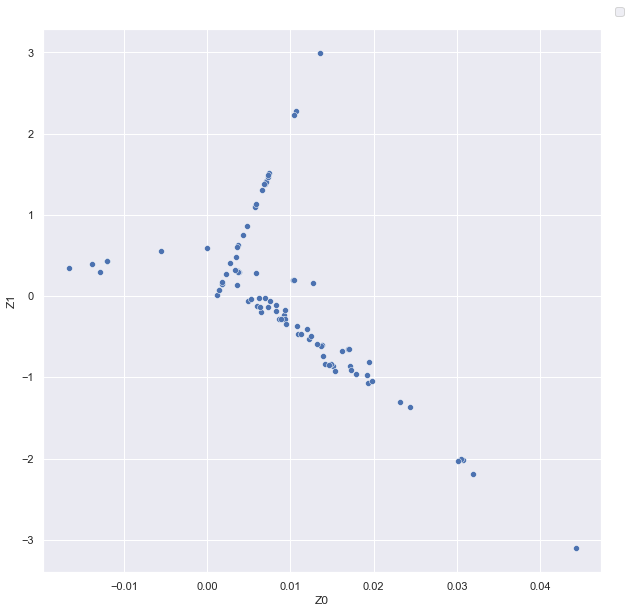

In [26]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='Z0',y='Z1',data=mu_tr_df)
plt.legend(bbox_to_anchor=(1.05, 1.05))